In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [108]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

function alpha(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[4],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    if Tₐ < t < Tₐ + Tᵣ
        arg = pi / 2 * (t - Tₐ) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
    elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
        E *= 1
        Edot *= 0
    elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
        arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
        E *= sin(arg)^2
        Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
    else
        E *= 0
        Edot *= 0
    end
    return (E, Edot)
end

function pulse(p, t)
    Tₐ = limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    Tᵣ = limit_func(p[1],0,Tₚ/2)
    # αmin = p[4]
    ϕ = p[5]
    f = p[6]
    A = p[7]
    # Φ_ext = p[8]
    λ = p[9]

    amp = pi * A / (Tₚ - Tᵣ)
    E = amp
    Edot = copy(amp)
    E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
    arg = f*(t - Tₐ) + ϕ
    return E*cos(arg) + Edot*λ*sin(arg)
end

dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

In [109]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p = [3.65, #14.84292607534555
# 11.341751839758764,
# 10.0,
# 0.501, #-649.7661732132904
#  0.5828557110984577,
# -7.161153490188593,
#  1.3640811715268795,
# -22.06506034791423,
# -4.957612200539009]
# p = [2, 10, 10, 0.51, 0.0, 1.5*2.482542369189332, 1.5/0.2949509890806259, 0.995pi, 0.0]
p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]


p[1] = inv_limit_func(p[1],0,15 - p[2])
p[2] = inv_limit_func(p[2],0,15)
p[4] = inv_limit_func(p[4],0.5,1)

-0.40546510810816466

In [110]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# fu0 = ψs[:,1:2]

# N=30
# # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# ψ0[1,1] = 1.0
# ψ0[2,2] = 1.0

u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(u0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)

sizep = length(p)

9

In [111]:
function f!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling

    du[:,1:2] = -im .* (H * x)
    du[:,3:4] = -im .* (H * ψ) - alpha(p,t) .* ((M - M') * x)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    ps = u[:,9]

    miH = -im .* (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * ψ - alpha(p,t) * dUa * x
    du[:,5:6] = miH * λ
    du[:,7:8] = miH * ϕ + alpha(p,t) * dUa * λ
    
    du[1:sizep,9] = (
    - real(im * tr(λ' * Uv * x)) .* dpulsedp(p, t) 
    - real(im * tr(λ' * Ua * x)) .* dalphadp(p,t) )
    
    du[8,9] = real(tr(λ' * dUa * x) * alpha(p,t))
    
    du[sizep+1:2*sizep,9] = (
    - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpulsedp(p,t) 
    - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dalphadp(p,t) 
    # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    - real(tr(x' * dUa * λ)) .* dalphadp(p,t) )
    # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [113]:
m = 0.001/pi
l1s = []
l2s = []
params = []
calls = [1]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][:,1:2]
        ψT = sol_f.u[end][:,3:4]

        λ = cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        ϕ = cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])

        push!(l1s, copy(infidelity))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if sum(calls)%20 == 0
            writedlm("tmp_l1s9.txt",l1s)
            writedlm("tmp_l2s9.txt",l2s)
            writedlm("tmp_params9.txt",params)
            writedlm("tmp_calls9.txt",calls)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    push!(calls, 0)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    push!(calls,1)
    println(l1s[end]," ",l2s[end]," ",loss[1],"\n",params[end])
end


get_grad! (generic function with 1 method)

In [114]:
initial_p = copy(p)
last_p = similar(initial_p);

In [115]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

2.9067421583317543e-5 0.00846187045278037 3.176091860404404e-5
[-0.4054651081081644, 0.6931471805599453, 10.0, -0.40546510810816466, 0.5418, 2.4237061150395447, 3.44314831140435, 3.1258846903218442, 0.05289]


0.9972154807446402 -2.5044412074235627 0.9980126691403292
[-0.4066281177162631, 0.6769757593630131, 10.0, -0.6409508928571203, 0.5429831924556897, 2.3041644926023195, 3.4401867574899816, 3.1174228198690637, 0.033603851287802695]


0.00032562816092784885 -2.521200934726528 0.0011281513435071168
[-0.40547855150434076, 0.6929602527647051, 10.0, -0.4081871223342174, 0.5418136766926291, 2.4223243161457115, 3.443114078374553, 3.125786878338093, 0.05266706861916809]


3.4463261609662954e-5 -0.3365904048169012 0.00014160331505748682
[-0.405466940543408, 0.6931217009061794, 10.0, -0.40583613896495296, 0.5418018642352914, 2.4235177655362317, 3.4431436451868653, 3.1258713578183666, 0.05285961278877847]


2.91678177939958e-5 -0.04186016391426947 4.249232180518174e-5
[-0.4054653753324411, 0.693143464858628, 10.0, -0.40551921558764614, 0.5418002718616819, 2.4236786480062795, 3.44314763092923, 3.1258827460410785, 0.0528855686289224]


2.9068527183429005e-5 -0.0012396049807261015 2.9463105703756792e-5
[-0.4054651596257762, 0.6931464642176265, 10.0, -0.4054755393764521, 0.5418000524116474, 2.423700819727403, 3.443148180216969, 3.1258843154880043, 0.05288914568519852]


2.9066878710903854e-5 0.0036108110530771145 3.0216235566240004e-5
[-0.4054651338687774, 0.693146822363658, 10.0, -0.40547032410821676, 0.5418000262076622, 2.4237034671977247, 3.4431482458060576, 3.125884502891776, 0.05288957281263158]


2.906793866480628e-5 -8.768985343672219e-5 2.9095851212073197e-5
[-0.40546515350879325, 0.6931465492730777, 10.0, -0.40547430081186076, 0.5418000461885105, 2.4237014484703265, 3.4431481957936025, 3.125884359994186, 0.052889247122917676]


2.9067091452505966e-5 0.0023779765005875583 2.982402488175572e-5
[-0.4054651404154494, 0.6931467313334646, 10.0, -0.40547164967609806, 0.541800032867945, 2.4237027942885923, 3.4431482291352395, 3.125884455259246, 0.052889464249393614]


2.906777642208702e-5 0.00028085420958720396 2.9157175093574963e-5
[-0.40546515155171853, 0.6931465764858193, 10.0, -0.4054739045440412, 0.5418000441974727, 2.423701649631081, 3.4431482007772094, 3.1258843742335465, 0.05288927957702146]


2.906790078444077e-5 -3.998338097916849e-6 2.9069173494985643e-5
[-0.4054651530643642, 0.693146555452777, 10.0, -0.4054742108240165, 0.5418000457363689, 2.42370149415161, 3.443148196925322, 3.1258843632277804, 0.05288925449286974]


2.9067816998629148e-5 0.00018590373360045383 2.912699199491265e-5
[-0.40546515205593375, 0.6931465694748052, 10.0, -0.4054740066373663, 0.5418000447104381, 2.4237015978045906, 3.4431481994932467, 3.125884370564958, 0.05288927121563756]


2.906788827167217e-5 2.3694773258100905e-5 2.9075430552251107e-5
[-0.40546515291731067, 0.6931465574975276, 10.0, -0.405474181048667, 0.5418000455867633, 2.4237015092667202, 3.4431481972997875, 3.1258843642977183, 0.05288925693145354]


2.9067898424384175e-5 1.0867517454117786e-6 2.9068244348208568e-5
[-0.40546515303736447, 0.6931465558282031, 10.0, -0.4054742053571186, 0.5418000457089005, 2.4237014969268174, 3.4431481969940756, 3.1258843634242264, 0.0528892549406055]


2.9067899617651882e-5 -1.4523440433365972e-6 2.9068361913119018e-5
[-0.40546515305084535, 0.6931465556407538, 10.0, -0.4054742080867265, 0.5418000457226154, 2.4237014955411635, 3.443148196959747, 3.1258843633261413, 0.052889254717052206]


2.9067898877188636e-5 7.958830063891309e-8 2.9067924210931555e-5
[-0.40546515304271286, 0.6931465557538345, 10.0, -0.40547420644006277, 0.5418000457143418, 2.423701496377073, 3.4431481969804563, 3.125884363385312, 0.052889254851913]


2.9067899410817333e-5 -9.420805033983424e-7 2.9068199284355145e-5
[-0.4054651530481345, 0.6931465556784474, 10.0, -0.4054742075378386, 0.5418000457198575, 2.4237014958198, 3.4431481969666504, 3.125884363345865, 0.0528892547620058]


2.9067898922319202e-5 -8.406199743593091e-8 2.906792568008404e-5
[-0.4054651530435834, 0.6931465557417303, 10.0, -0.405474206616321, 0.5418000457152274, 2.423701496287598, 3.44314819697824, 3.1258843633789786, 0.052889254837477556]


2.9067898975498885e-5 3.8438902051293385e-10 2.906789909785371e-5
[-0.40546515304313024, 0.6931465557480312, 10.0, -0.4054742065245696, 0.5418000457147664, 2.4237014963341745, 3.4431481969793936, 3.1258843633822755, 0.05288925484499195]


2.9067898989931784e-5 -5.6355054008382815e-8 2.906791692830261e-5
[-0.40546515304343234, 0.6931465557438307, 10.0, -0.4054742065857372, 0.5418000457150737, 2.4237014963031234, 3.4431481969786244, 3.1258843633800772, 0.05288925483998235]


2.906789895740225e-5 -7.3984016419702395e-9 2.9067901312386635e-5
[-0.4054651530431732, 0.6931465557474333, 10.0, -0.40547420653327504, 0.5418000457148101, 2.423701496329755, 3.443148196979284, 3.1258843633819624, 0.05288925484427898]


2.9067899009638243e-5 -1.1832008785635862e-9 2.906789938626278e-5
[-0.40546515304313707, 0.6931465557479364, 10.0, -0.40547420652595095, 0.5418000457147734, 2.4237014963334733, 3.4431481969793762, 3.1258843633822258, 0.052889254844878816]


2.906789901524487e-5 -1.9872639423249702e-10 2.9067899078501445e-5
[-0.4054651530431315, 0.6931465557480138, 10.0, -0.40547420652482435, 0.5418000457147677, 2.423701496334045, 3.4431481969793905, 3.125884363382266, 0.05288925484497108]


2.906789899559392e-5 9.143161628516231e-11 2.906789902469751e-5
[-0.40546515304313085, 0.6931465557480224, 10.0, -0.4054742065246968, 0.541800045714767, 2.4237014963341097, 3.443148196979392, 3.1258843633822706, 0.052889254844981526]


2.906789903939222e-5 -3.5600002744696043e-10 2.9067899152710547e-5
[-0.4054651530431312, 0.6931465557480181, 10.0, -0.4054742065247605, 0.5418000457147674, 2.4237014963340773, 3.443148196979391, 3.1258843633822684, 0.052889254844976315]


2.906789899559392e-5 9.143161628516231e-11 2.906789902469751e-5
[-0.40546515304313085, 0.6931465557480224, 10.0, -0.4054742065246968, 0.541800045714767, 2.4237014963341097, 3.443148196979392, 3.1258843633822706, 0.052889254844981526]


0.9123230776486657 -21.75752691587422 0.9192487135648983
[-0.5046518981260302, -0.6862344410662337, 10.0, -20.47312897871745, 0.6427838025562438, -7.765845890751617, 3.188314366151664, 4.852066637593162, -1.5912077716721478]


0.9950973805248405 -0.7571042545736382 0.9953383742939431
[-0.4122758181325594, 0.5984312589392381, 10.0, -1.783421185926501, 0.5487341027477382, 1.7240354814013579, 3.4256500133886996, 3.2444127952118724, -0.060002787461426066]


0.23562897416368628 -57.16092744592906 0.25382386247315986
[-0.40584637981391497, 0.6878448698961781, 10.0, -0.4826047466953591, 0.5421881793458299, 2.3845377124748457, 3.4421687366862668, 3.1325189887410545, 0.04657012621795514]


8.983116906768895e-5 -1.140106827571359 0.00045273844358929095
[-0.4054712133931291, 0.6930622750145978, 10.0, -0.40670034829859225, 0.5418062158629061, 2.4230789108925013, 3.4431326265298834, 3.1259898338131604, 0.05278879985572472]


3.0051691797594593e-5 -0.1410210387521562 7.494008259231337e-5
[-0.40546590245864045, 0.6931361336950378, 10.0, -0.40562582972510003, 0.5418008087077811, 2.423624508175651, 3.443146271556544, 3.125897405727471, 0.05287683270319347]


2.909419949226333e-5 -0.019471997376665787 3.5292328761000886e-5
[-0.40546525651977744, 0.6931451167077577, 10.0, -0.4054951421206657, 0.5418001510661474, 2.4236908660811167, 3.443147931123806, 3.1258861642232296, 0.05288753963951923]


2.906946930791854e-5 -0.0027272102645097447 2.99375672968139e-5
[-0.4054651675358422, 0.6931463541992103, 10.0, -0.4054771387181884, 0.5418000604700495, 2.423700007484273, 3.4431481597442435, 3.125884615604092, 0.05288901461707969]


2.9068077826877037e-5 -0.0003827232163411621 2.9189902410310487e-5
[-0.40546515507696745, 0.6931465274636431, 10.0, -0.40547461801446, 0.5418000477854515, 2.42370128739617, 3.443148191753992, 3.1258843987778535, 0.052889221132567006]


2.90679233027058e-5 -5.372455717361036e-5 2.9085024360385007e-5
[-0.405465153328629, 0.693146551777626, 10.0, -0.4054742642872333, 0.5418000460054376, 2.4237014670046184, 3.4431481962458808, 3.1258843683508966, 0.052889250112629106]


2.9067902282742253e-5 -7.540675240303231e-6 2.9070302554219743e-5
[-0.4054651530832089, 0.6931465551906604, 10.0, -0.4054742146333699, 0.5418000457555712, 2.423701492216852, 3.4431481968764217, 3.1258843640797638, 0.05288925418065649]


2.9067899477874803e-5 -1.058822805665033e-6 2.9068236511641564e-5
[-0.40546515304875796, 0.6931465556697666, 10.0, -0.40547420766318704, 0.5418000457204961, 2.4237014957560303, 3.4431481969649345, 3.1258843634802016, 0.05288925475170762]


2.9067898985046803e-5 -1.478315833161841e-7 2.906794604130126e-5
[-0.4054651530439209, 0.6931465557370355, 10.0, -0.405474206684537, 0.5418000457155714, 2.4237014962529493, 3.443148196977362, 3.1258843633960196, 0.05288925483188618]


2.906789902112905e-5 -2.1044415505262296e-8 2.9067905719774555e-5
[-0.4054651530432425, 0.6931465557464701, 10.0, -0.40547420654727984, 0.5418000457148807, 2.423701496322643, 3.443148196979105, 3.125884363384213, 0.052889254843131346]


In [22]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,GradientDescent(linesearch=LineSearches.MoreThuente()),Optim.Options(g_tol=1e-4,f_tol=1e-6))

0.992054379299719 -1.2523176360983437 0.9924530043839314
[-0.4054651081081644, 0.6931471805599453, 10.0, -3.8918202981106256, 0.0, 3.723813553783998, 5.0855906761850855, 3.1258846903218442, 0.0]


0.9810796974896567 -1.5691754629758004 0.981579181552679
[-0.38913812225290095, 0.773979679459092, 10.0, -3.8854977532843598, -0.0018091814344179632, 3.746469904750472, 5.085630953126694, 4.378202326420188, 0.0043168258437575645]


0.9693544743630728 -3.261456052037678 0.9703926280677904
[-0.3238301788318473, 1.0973096750556788, 10.0, -3.8602075739792956, -0.009045907172089815, 3.8370953086163695, 5.08579206089313, 9.387472870813562, 0.02158412921878782]


0.8140794392004321 2.540611569091483 0.8148881409798269
[-0.0625984051476326, 2.3906296574420263, 10.0, -3.759046856759039, -0.03799281012277723, 4.199596924079957, 5.0864364919588745, 29.42455504838706, 0.09065334271890886]


0.7118052601170631 -1.7433908383334924 0.7123601986563869
[-0.20247076497790456, 1.6981422337234187, 10.0, -3.8132117389254194, -0.022493655604211977, 4.005501253089833, 5.086091441689367, 18.696021039050958, 0.05367134107480112]


0.3593865593683613 -3.3092481728982355 0.36043992577763045
[-0.1288843451316823, 2.062457745106946, 10.0, -3.784715760414347, -0.030647713296872544, 4.107614390761529, 5.086272971578695, 24.340269902110595, 0.07312745880270136]


0.8400481698204808 1.4125943878799936 0.8404978125793108
[-0.09936860438158229, 2.2085858242784497, 10.0, -3.7732859352385755, -0.03391833107418629, 4.148572286321544, 5.086345783779139, 26.604195590019536, 0.08093136783999648]


0.5200121545865017 -1.165660456941663 0.5203831958338798
[-0.1179312078761181, 2.116685112178938, 10.0, -3.7804742119803336, -0.031861422474247135, 4.122813651913949, 5.086299991806041, 25.180400902244145, 0.07602344869294803]


0.9147956882021769 1.1397421803487868 0.9151584794058826
[-7.403240976818255, -54.92009129728253, 10.0, -7.402254150663683, 0.6188810379723119, -8.245157306224081, 8.781416632718248, 45.70880096958763, 1.4826936643987998]


0.8250069648502635 7.477829797187692 0.827387232001908
[-2.6493306977432254, -17.701671455456772, 10.0, -5.038920617139193, 0.19424964001369427, -0.17463921791342685, 6.370228428134266, 32.31332772435329, 0.5647939168519291]


0.9672020835995886 -3.304560361982538 0.9682539578322987
[-1.260978673162265, -6.832247022575624, 10.0, -4.3487227161667725, 0.07023849414680242, 2.1823089509744946, 5.666054847026791, 28.40125717432606, 0.2967266000415234]


0.9297706697804667 -17.92934190106333 0.9354777565603445
[-0.43705699903355566, -0.38175448394303535, 10.0, -3.9391227011986976, -0.0033562924089403645, 3.5810469127899482, 5.248160922754671, 26.079627169961054, 0.13764124666201316]


0.5319924881645792 0.929338038976082 0.532288305649992
[-0.16630765795063113, 1.7379453119653188, 10.0, -3.8045238216663235, -0.02754031449839097, 4.040686940963363, 5.110836577259229, 25.316715095114997, 0.08536412378016257]


0.30461031654759896 -1.8972195712648023 0.3052142202933939
[-0.1399689362856399, 1.9441514756237903, 10.0, -3.791429930430086, -0.029892956333109035, 4.085401106175091, 5.097477550421472, 25.24249837231944, 0.08027856167491672]


0.28012188317196074 -2.670274827951136 0.2809718580485253
[-0.13028586845629062, 1.9750843915812055, 10.0, -3.7893919388329715, -0.029879371196521856, 4.091370288841034, 5.102734813805832, 25.34356771446902, 0.10104753101505683]


0.5265246810543596 -0.7968914506236164 0.5267783394813084
[-0.09155359713889358, 2.0988160554108664, 10.0, -3.7812399724445154, -0.029825030650173143, 4.115247019504806, 5.12376386734327, 25.747845083067354, 0.18412340837561725]


0.27617627114880006 -3.067955401934138 0.27715283168360666
[-0.12036263340818851, 2.0067845305431824, 10.0, -3.7873033993328225, -0.02986544911047527, 4.0974875239655955, 5.108122472055489, 25.447143859548525, 0.122331628999413]


0.2960498957452916 -3.027907846396814 0.2970137087472532
[-0.11369274728734893, 2.0280917268220424, 10.0, -3.7858995909419755, -0.029856091403231096, 4.10159921349602, 5.111743777689087, 25.51676239515381, 0.13663770046222673]


0.27835837741522884 -3.084009302262842 0.2793400480652219
[-0.11906213153041764, 2.0109390315749334, 10.0, -3.7870296831980563, -0.029863624534219813, 4.0982892258025165, 5.108828558290119, 25.460718159715277, 0.12512104286103548]


0.2765476959674269 -3.0719413428475986 0.277525525266632
[-0.12010559156065848, 2.0076056601693826, 10.0, -3.787249299833097, -0.02986508848627343, 4.097645978885848, 5.108262028724623, 25.44982679546229, 0.12288295161168504]


0.2762477937411082 -3.0687801340413383 0.27722461679629795
[-0.12031155251109318, 2.0069477103457745, 10.0, -3.787292648355871, -0.029865377445071672, 4.0975190130774015, 5.108150205593524, 25.447677028659477, 0.12244119113450658]


0.27619041211254647 -3.068110325217511 0.27716702196096576
[-0.12035247051938994, 2.0068169962648557, 10.0, -3.787301260353489, -0.029865434852160148, 4.0974937889366485, 5.108127989829825, 25.447249937137087, 0.12235342712471634]


0.276179093238472 -3.067988257976389 0.2771556642316817
[-0.12036061093817396, 2.0067909913979536, 10.0, -3.787302973664329, -0.029865446272993194, 4.0974887707288286, 5.108123570122521, 25.447164969564227, 0.12233596694462455]


0.27617684638622186 -3.067961992111587 0.2771534090187471
[-0.12036223100782983, 2.0067858160259133, 10.0, -3.787303314639772, -0.029865448545916193, 4.097487772027603, 5.108122690532185, 25.447148059698755, 0.1223324920978503]


0.2761763766483589 -3.067956309063619 0.27715293747191383
[-0.12036255345866186, 2.0067847859448826, 10.0, -3.787303382505876, -0.029865448998307797, 4.097487573250939, 5.108122515462777, 25.44714469404088, 0.1223318004811476]


0.2761762912145569 -3.067955520104515 0.2771528517869783
[-0.12036261744984586, 2.006784581522694, 10.0, -3.7873033959740763, -0.029865449088086058, 4.097487533803207, 5.1081224807198105, 25.447144026117556, 0.12233166322806191]


0.27617627499660635 -3.0679554242280256 0.27715283553850933
[-0.12036263021436752, 2.006784540745961, 10.0, -3.78730339866062, -0.029865449105994406, 4.0974875259344445, 5.108122473789522, 25.4471438928848, 0.12233163584975953]


0.2761762712497293 -3.06795535673554 0.27715283177014877
[-0.12036263276757952, 2.006784532589631, 10.0, -3.787303399197994, -0.02986544910957651, 4.097487524360503, 5.108122472403297, 25.447143866235038, 0.12233163037343914]


0.27617627073108525 -3.067955357296329 0.2771528312516832
[-0.1203626332736224, 2.006784530973059, 10.0, -3.7873033993045, -0.029865449110286477, 4.0974875240485495, 5.108122472128549, 25.447143860953094, 0.12233162928804045]


0.2761762714611201 -3.067955384940582 0.2771528319905175
[-0.12036263293626048, 2.006784532050774, 10.0, -3.787303399233496, -0.029865449109813164, 4.097487524256518, 5.108122472311715, 25.447143864474388, 0.12233163001163957]


0.27617627121544236 -3.0679553935414376 0.2771528317475775
[-0.1203626332086263, 2.006784531180691, 10.0, -3.7873033992908205, -0.02986544911019529, 4.097487524088617, 5.108122472163838, 25.447143861631506, 0.12233162942744899]


0.27617627073108525 -3.067955357296329 0.2771528312516832
[-0.1203626332736224, 2.006784530973059, 10.0, -3.7873033993045, -0.029865449110286477, 4.0974875240485495, 5.108122472128549, 25.447143860953094, 0.12233162928804045]


0.2784830136054576 -2.3189232223711405 0.2792211497924395
[-0.11319370250898753, 1.9672654399577771, 10.0, -3.793326572138318, -0.02908777321893383, 4.085088983822654, 5.120853548372832, 25.77807193733889, 0.10827899746583675]


0.27297571416148597 -2.9528269090183366 0.27391562815881604
[-0.11867021318498677, 1.9974549802053456, 10.0, -3.7887253322308947, -0.029681857673266945, 4.0945605131403715, 5.111127987161846, 25.5252683878535, 0.11901412530105514]


0.2745436274707913 -2.56684721876403 0.27536068031684724
[-0.11501920606765394, 1.9773286200403, 10.0, -3.7917928255025104, -0.0292858013703782, 4.088246160261893, 5.117611694635837, 25.693804087510426, 0.11185737341090954]


0.27104717928264227 -3.2411656282106738 0.27207887434486083
[-0.09992571397833057, 2.0054396432232076, 10.0, -3.792090517939911, -0.02906916009890733, 4.0926310728892235, 5.125487889895098, 25.900175772487078, 0.11134192809968291]


0.5393850919063948 -0.8665619409435107 0.5396609271391878
[-0.03955174562103711, 2.1178837359548384, 10.0, -3.7932812876895126, -0.028202595013023857, 4.110170723398544, 5.156992670932141, 26.725662512393694, 0.1092801468547764]


0.29776865602662994 -3.428906358116411 0.2988601108192169
[-0.08394165097665324, 2.035209318983998, 10.0, -3.7924057753135108, -0.028839736204724267, 4.09727471130486, 5.133828809312056, 26.118724137233134, 0.1107960696409639]


0.2736211882696437 -3.331133991866671 0.2746815211514578
[-0.09672611798034918, 2.0113987623417593, 10.0, -3.7921536243122267, -0.02902323536915668, 4.0935606091960555, 5.12715752623119, 25.943923502531277, 0.11123266135443807]


0.2714670813840448 -3.261460483254008 0.2725052364992623
[-0.09927101727451398, 2.006658989555378, 10.0, -3.7921034306745094, -0.029059763047151303, 4.092821273263441, 5.125829528466499, 25.909127369712937, 0.11131957009636197]


0.2711295798607753 -3.2454411227726543 0.27216263585518125
[-0.09979034931220926, 2.005691754480494, 10.0, -3.792093187768547, -0.029067217170577215, 4.092670398595313, 5.125558526864678, 25.90202659892727, 0.11133730537340823]


0.27106404539933227 -3.2420596705723708 0.2720960250440732
[-0.09989766021727979, 2.0054918922271225, 10.0, -3.792091071250732, -0.02906875743513492, 4.092639222977377, 5.125502529111688, 25.900559348527914, 0.11134097005899157]


0.27105065699241293 -3.241353329490195 0.2720824118018044
[-0.09991989694238015, 2.005450477219177, 10.0, -3.792090632670657, -0.02906907660530247, 4.092632762835741, 5.1254909253828895, 25.900255308190516, 0.11134172944691997]


0.27104788321307327 -3.2412088164353974 0.27207959202253074
[-0.09992450760484649, 2.0054418900453994, 10.0, -3.792090541733494, -0.029069142783478674, 4.092631423360956, 5.125488519413639, 25.900192267101257, 0.1113418869018241]


0.27104733478341125 -3.2411708161883377 0.2720790314970144
[-0.09992546368881666, 2.005440109377381, 10.0, -3.792090522876429, -0.029069156506429314, 4.0926311456025255, 5.125488020502983, 25.900179194668535, 0.11134191955225362]


0.27104722157854866 -3.2411675979421455 0.27207891726775224
[-0.09992566210222355, 2.0054397398403747, 10.0, -3.792090518963075, -0.029069159354314516, 4.092631087960103, 5.125487916965463, 25.90017648178348, 0.11134192632810506]


0.27104716238646953 -3.241163609469644 0.27207885680610283
[-0.09992570329135689, 2.0054396631272673, 10.0, -3.7920905181506925, -0.029069159945514098, 4.092631075993968, 5.125487895471852, 25.900175918608916, 0.11134192773472094]


0.271047186984843 -3.241166079794078 0.272078882190805
[-0.09992567583193467, 2.0054397142693388, 10.0, -3.792090518692281, -0.029069159551381042, 4.0926310839713915, 5.125487909800926, 25.900176294058625, 0.11134192679697703]


0.2710471754334741 -3.241163611419329 0.27207886985372803
[-0.09992569765104733, 2.005439673632117, 10.0, -3.7920905182619378, -0.029069159864557097, 4.092631077632573, 5.125487898415119, 25.900175995728258, 0.11134192754210342]


0.27104717541996726 -3.24116343037887 0.2720788697825942
[-0.09992570217931665, 2.0054396651983977, 10.0, -3.7920905181726257, -0.02906915992955266, 4.092631076317035, 5.125487896052145, 25.90017593381372, 0.11134192769674459]


0.2710471872506406 -3.2411668437526666 0.2720788826997782
[-0.09992570311807676, 2.0054396634499945, 10.0, -3.7920905181541102, -0.02906915994302696, 4.092631076044309, 5.125487895562274, 25.900175920978153, 0.1113419277288034]


0.27104717260088806 -3.2411634290317037 0.2720788669630862
[-0.09992570328455527, 2.005439663139935, 10.0, -3.7920905181508267, -0.02906915994541647, 4.092631075995945, 5.125487895475401, 25.900175918701912, 0.11134192773448867]


0.27104716238646953 -3.241163609469644 0.27207885680610283
[-0.09992570329135689, 2.0054396631272673, 10.0, -3.7920905181506925, -0.029069159945514098, 4.092631075993968, 5.125487895471852, 25.900175918608916, 0.11134192773472094]


0.2702608669039436 -2.452590177455543 0.27104155060418494
[-0.09660138022464765, 1.9755259896064876, 10.0, -3.7963302291108825, -0.028306168718031998, 4.083186218214957, 5.136277631661426, 26.16076208208853, 0.11552832338855952]


0.26679226031250003 -3.2372120049586197 0.2678226968973512
[-0.08059347726875338, 2.004863977504983, 10.0, -3.7965157680960124, -0.028162612305622864, 4.088061640868652, 5.143719790120468, 26.35794776659506, 0.11195804201325327]


0.5547630840327613 -0.7638077836184016 0.5550062116014312
[-0.016561865445176266, 2.122215929098964, 10.0, -3.7972579240365323, -0.02758838665598632, 4.107563331483432, 5.173488423956633, 27.14669050462118, 0.09767691651202823]


0.2968522023806965 -3.482959220362081 0.2979608627337127
[-0.06366066767864507, 2.0358970593652903, 10.0, -3.7967120271760058, -0.02801076147272736, 4.093218756306806, 5.151591942548776, 26.56652647042927, 0.10818147647073723]


0.2697261961646946 -3.3435628860090434 0.2707904852863885
[-0.07724833702504594, 2.010994679587514, 10.0, -3.796554539815684, -0.028132613602250212, 4.089080448426949, 5.145274963451414, 26.399153274308546, 0.11121196728111613]


0.2672740276764211 -3.260874165919934 0.26831199616103474
[-0.07991360629147268, 2.0061099899626393, 10.0, -3.796523648114494, -0.02815651532723235, 4.088268704740376, 5.1440358657212855, 26.366322431559023, 0.1118064087422068]


0.266886697635613 -3.2421678690155136 0.2679187117209881
[-0.08045359577502866, 2.00512034097629, 10.0, -3.7965173893870996, -0.028161357869894654, 4.08810424366336, 5.143784821764191, 26.359670829769914, 0.11192684390484572]


0.2668115537408505 -3.23823521070474 0.2678423160222063
[-0.08056461839758125, 2.0049168677065006, 10.0, -3.796516102583652, -0.028162353503703393, 4.088070430226924, 5.143733206761786, 26.35830325077571, 0.11195160554930529]


0.2667962385732898 -3.2374172066081344 0.2678267404758547
[-0.08058752005341434, 2.004874895406722, 10.0, -3.796515837142888, -0.028162558882231657, 4.088063455218895, 5.143722559661278, 26.358021147698608, 0.11195671336108488]


0.2667930737227129 -3.2372564106834614 0.2678235244423453
[-0.08059224741405492, 2.004866231483056, 10.0, -3.796515782350596, -0.028162601276475022, 4.0880620154374805, 5.143720361886399, 26.357962915971044, 0.11195776771578055]


0.2667924299498208 -3.2372206994206287 0.26782286930220517
[-0.0805932233135911, 2.004864442933434, 10.0, -3.79651577103947, -0.028162610028192016, 4.08806171821412, 5.1437199081855605, 26.35795089482008, 0.11195798537301821]


0.26679229518163894 -3.2372138482951898 0.2678227323532424
[-0.08059342483954621, 2.0048640735929872, 10.0, -3.7965157687036912, -0.028162611835445793, 4.088061656836674, 5.143719814495082, 26.357948412419134, 0.11195803031984018]


0.26679226750570006 -3.2372123862769113 0.2678227042119286
[-0.08059346644374242, 2.004863997344186, 10.0, -3.796515768221479, -0.02816261220854583, 4.088061644165554, 5.143719795153072, 26.357947899937773, 0.11195803959892485]


0.2667922618136429 -3.2372120959751913 0.26782269842746553
[-0.08059347503368124, 2.004863981601242, 10.0, -3.796515768121918, -0.028162612285579078, 4.088061641549373, 5.1437197911595645, 26.357947794126726, 0.11195804151475972]


0.26679226063454126 -3.237212025021127 0.2678226972257785
[-0.08059347680741032, 2.004863978350495, 10.0, -3.7965157681013597, -0.028162612301485607, 4.08806164100916, 5.1437197903349485, 26.357947772277896, 0.1119580419103588]


0.2667922603921319 -3.2372120026063618 0.26782269697623434
[-0.0805934771736152, 2.0048639776793444, 10.0, -3.796515768097115, -0.02816261230476968, 4.088061640897627, 5.143719790164698, 26.357947767766976, 0.11195804199203437]


0.26679226031250003 -3.2372120049586197 0.2678226968973512
[-0.08059347726875338, 2.004863977504983, 10.0, -3.7965157680960124, -0.028162612305622864, 4.088061640868652, 5.143719790120468, 26.35794776659506, 0.11195804201325327]


0.26621523140716674 -2.3541277572181225 0.26696457354562897
[-0.07765694406833668, 1.9727359271475264, 10.0, -3.800795323003061, -0.027423800892546816, 4.078074682773419, 5.154548014535242, 26.618216225205934, 0.11674957781064314]


0.2624265467523377 -3.224251985967207 0.2634528580350188
[-0.061047830227454365, 2.0039810793837876, 10.0, -3.8007550565691197, -0.02734240429301532, 4.0834783963726125, 5.161775769822845, 26.807485634131183, 0.11321821445893035]


0.5845252243159246 -0.4409595827495486 0.5846655861105212
[0.005388625136074882, 2.1289616883288325, 10.0, -3.800593990833354, -0.02701681789488934, 4.105093250769385, 5.190686790973258, 27.56456326983217, 0.0990927610520792]


0.29805714852529996 -3.475872991151309 0.2991635532615026
[-0.04306572091770575, 2.0378091179109976, 10.0, -3.800711461502966, -0.027254279028522618, 4.08932880895634, 5.169601008838661, 27.012401033766043, 0.10939493030233466]


0.26584524232616646 -3.342471998838135 0.26690918420768917
[-0.05752565195319426, 2.0106070196619275, 10.0, -3.8007465175489066, -0.02732514308707652, 4.084624324013409, 5.163308509190492, 26.847622670127507, 0.11246934300226627]


0.26298294050831084 -3.2505009224950947 0.26401760708699057
[-0.06033673601835848, 2.005318793546649, 10.0, -3.8007533326223593, -0.027338919420124362, 4.083709748236704, 5.162085215286282, 26.815588918986418, 0.1130670244524271]


0.2625350511507188 -3.2297266910422575 0.2635631050861492
[-0.06090226248533444, 2.0042549221852037, 10.0, -3.8007547036608353, -0.027341690906417845, 4.083525756297726, 5.161839116249866, 26.80914445354645, 0.11318726442784269]


0.26244861667164615 -3.2253836525295703 0.2634752881749819
[-0.06101793931107376, 2.004037310332756, 10.0, -3.800754984102845, -0.027342257806033922, 4.083488121271417, 5.161788777393928, 26.807826256522585, 0.1132118591718472]


0.2624311051650887 -3.224500548072441 0.2634574955675452
[-0.0610416886036758, 2.0039926330387132, 10.0, -3.8007550416796265, -0.027342374194643068, 4.083480394527134, 5.161778442461142, 26.80755562109819, 0.11321690865144782]


0.26242749463584536 -3.2242992273726654 0.26345382095593284
[-0.06104656844504239, 2.0039834530554916, 10.0, -3.8007550535101076, -0.027342398109374298, 4.0834788068888415, 5.161776318910206, 26.807500012791813, 0.1132179461838008]


0.26242676173945556 -3.22427139910086 0.263453079201529
[-0.061047571069146635, 2.003981566913758, 10.0, -3.800755055940827, -0.027342403022953283, 4.0834784806888065, 5.161775882600254, 26.807488587373612, 0.11321815935772755]


0.26242661510004683 -3.224265142470453 0.26345293057057295
[-0.06104777717431367, 2.0039811791876345, 10.0, -3.8007550564405, -0.027342404033016788, 4.083478413633255, 5.161775792909875, 26.807486238699052, 0.11321820317898379]


0.26242655078376165 -3.2242663370901354 0.26345286663454703
[-0.06104781956666397, 2.0039810994389224, 10.0, -3.800755056543274, -0.027342404240769783, 4.083478399841061, 5.16177577446208, 26.80748575561638, 0.11321821219227574]


0.26242656982305 -3.2242552635360733 0.2634528821490137
[-0.06104782804131211, 2.00398108349637, 10.0, -3.8007550565638195, -0.02734240428230165, 4.083478397083866, 5.1617757707741845, 26.807485659043397, 0.11321821399412153]


0.26242656902704425 -3.2242556065229753 0.26345288146218404
[-0.06104782989932298, 2.0039810800010702, 10.0, -3.8007550565683244, -0.027342404291407243, 4.083478396479369, 5.1617757699656375, 26.807485637870407, 0.11321821438916438]


0.2624265222542888 -3.2242509118926312 0.26345283319508134
[-0.061047830207969195, 2.003981079420443, 10.0, -3.8007550565690726, -0.02734240429291983, 4.083478396378951, 5.1617757698313245, 26.807485634353224, 0.1132182144547875]


0.26242654998638787 -3.224253524104607 0.2634528617586733
[-0.061047830207875305, 2.00398107942062, 10.0, -3.800755056569072, -0.02734240429291937, 4.0834783963789825, 5.161775769831365, 26.807485634354293, 0.11321821445476754]


0.2624265222542888 -3.2242509118926312 0.26345283319508134
[-0.061047830207969195, 2.003981079420443, 10.0, -3.8007550565690726, -0.02734240429291983, 4.083478396378951, 5.1617757698313245, 26.807485634353224, 0.1132182144547875]


0.26202500178554844 -2.263905027937593 0.2627456251373222
[-0.058294270949871295, 1.970145654339001, 10.0, -3.8050521119677465, -0.026642612620336847, 4.073063031904372, 5.172563393701746, 27.066712034944867, 0.11795746639743668]


0.2579495015915302 -3.208029199540405 0.25897064900091016
[-0.04119885737433375, 2.00280473386734, 10.0, -3.804824253045613, -0.02661635378354577, 4.078859091494039, 5.179625800929998, 27.2487276310354, 0.11475747880423974]


0.6069043883589883 -0.21649443932977913 0.6069733006793308
[0.02718279692781645, 2.133441051980697, 10.0, -3.8039128173570784, -0.026511318436381447, 4.102043329852704, 5.207875429843003, 27.976790015397537, 0.10195752843145196]


0.2977464051582589 -3.472806558130001 0.2988518338185156
[-0.022471414936131175, 2.0385816414717777, 10.0, -3.8045746413688066, -0.026587588123544257, 4.085208477067792, 5.187362427146018, 27.448119507902202, 0.11125200154919919]


0.2617093701455388 -3.336494594058456 0.26277140936002635
[-0.037561587115461474, 2.0097533752749137, 10.0, -3.80477577311402, -0.026610766876527067, 4.080092278106985, 5.181128419375223, 27.287453802320215, 0.11407664007225664]


0.2585571290436021 -3.236446878167874 0.25958732208103164
[-0.040468800838896674, 2.004199433933862, 10.0, -3.8048145223716796, -0.02661523240468426, 4.079106611167343, 5.179927399749477, 27.256500574046708, 0.11462082391458711]


0.2580674383049702 -3.213927585542866 0.2590904632289273
[-0.04105006685572882, 2.0030889832865606, 10.0, -3.804822269867666, -0.026616125238858805, 4.078909537697542, 5.179687268833622, 27.250311810021, 0.11472962760242954]


0.2579733430294771 -3.209219958852004 0.25899486946931805
[-0.04116842995981522, 2.002862862402588, 10.0, -3.804823847489009, -0.02661630704653597, 4.078869407659069, 5.17963837101444, 27.249051593013075, 0.11475178327961717]


0.2579543764901687 -3.2082769404452263 0.2589756027579279
[-0.041192630319756895, 2.002816630032926, 10.0, -3.8048241700473318, -0.026616344218687384, 4.078861202725758, 5.179628373432561, 27.248793930750566, 0.11475631319936565]


0.25795046919821263 -3.2080851438436886 0.2589716344152174
[-0.041197582867095725, 2.0028071686860747, 10.0, -3.804824236058142, -0.02661635182588166, 4.078859523605251, 5.1796263274506975, 27.24874120076822, 0.11475724023689937]


0.25794971494870295 -3.2080408866727663 0.2589708660782127
[-0.04119859628346613, 2.0028052326553554, 10.0, -3.804824249565622, -0.026616353382505894, 4.078859180014753, 5.179625908791093, 27.248730410880984, 0.11475742993221137]


0.2579495838555417 -3.208035199063923 0.2589707331746293
[-0.0411988040106881, 2.0028048358132535, 10.0, -3.804824252334347, -0.02661635370157833, 4.078859109586544, 5.179625822975431, 27.248728199200407, 0.11475746881542002]


0.2579495147489529 -3.2080300984148025 0.2589706624444535
[-0.04119884677784763, 2.0028047541108682, 10.0, -3.804824252904376, -0.02661635376726939, 4.07885909508669, 5.1796258053075865, 27.24872774385664, 0.11475747682074726]


0.2579495036213117 -3.2080293499974526 0.25897065107858364
[-0.04119885524513856, 2.0028047379349547, 10.0, -3.804824253017234, -0.026616353780275288, 4.078859092215924, 5.179625801809604, 27.248727653705032, 0.1147574784056885]


0.2579495015638963 -3.2080291847728737 0.25897064896857563
[-0.041198856941611, 2.002804734694014, 10.0, -3.8048242530398455, -0.0266163537828811, 4.07885909164075, 5.179625801108762, 27.24872763564262, 0.11475747872324096]


0.257949503139972 -3.2080293040424497 0.25897065058261604
[-0.041198855810629376, 2.002804736854641, 10.0, -3.804824253024771, -0.02661635378114389, 4.078859092024199, 5.17962580157599, 27.248727647684227, 0.11475747851153932]


0.25794950128939703 -3.2080291279799145 0.2589706486759986
[-0.04119885671573832, 2.0028047351255207, 10.0, -3.8048242530368346, -0.026616353782534154, 4.07885909171733, 5.179625801202074, 27.248727638047495, 0.11475747868096121]


0.25794950161883473 -3.2080291532104845 0.25897064901346745
[-0.041198856539551854, 2.0028047354621075, 10.0, -3.8048242530344862, -0.026616353782263527, 4.078859091777065, 5.17962580127486, 27.24872763992336, 0.11475747864798194]


0.2579495015262576 -3.208029172493119 0.2589706489270282
[-0.04119885668119665, 2.0028047351915093, 10.0, -3.8048242530363745, -0.026616353782481096, 4.078859091729041, 5.1796258012163445, 27.24872763841526, 0.11475747867449557]


0.25794950128939703 -3.2080291279799145 0.2589706486759986
[-0.04119885671573832, 2.0028047351255207, 10.0, -3.8048242530368346, -0.026616353782534154, 4.07885909171733, 5.179625801202074, 27.248727638047495, 0.11475747868096121]


0.2576780672814066 -2.1798502420012995 0.2583719351638357
[-0.038493957981373506, 1.9677188359166784, 10.0, -3.8091130899163304, -0.025962146145271765, 4.068120238296435, 5.190337259715009, 27.506649834117706, 0.11926078454387176]


0.25336863316588476 -3.1897629287481877 0.2543839662406879
[-0.020986718129760384, 2.001392395569145, 10.0, -3.80873092628643, -0.02598526855225779, 4.074200048509104, 5.1972669458702185, 27.681907520096136, 0.116552441148702]


0.6232287106437286 -0.07158142994387709 0.6232514957205469
[0.0490422412766921, 2.1360866341790112, 10.0, -3.8072022717668275, -0.02607775818020189, 4.098519289359778, 5.224985690491056, 28.382938264009855, 0.10571906756802299]


0.29596821124206857 -3.477739814391152 0.29707521020656424
[-0.0017556236554464866, 2.0383816304486433, 10.0, -3.8083111328219226, -0.026010667712661754, 4.080878508710525, 5.20487896525521, 27.874421996676535, 0.11357742006354822]


0.25734071190851526 -3.3272747802107765 0.25839981636510634
[-0.017284120021572612, 2.008514001220403, 10.0, -3.8086501026760216, -0.025990158699481958, 4.075485864776109, 5.198732502009626, 27.71897268753824, 0.11597965484907555]


0.25400743253348995 -3.2199681175705517 0.25503238021850927
[-0.02024736626443242, 2.002814470627938, 10.0, -3.808714787055173, -0.025986245039407156, 4.074456806231034, 5.197559594878767, 27.68930886366254, 0.11643806453890289]


0.253492199158929 -3.1959936985152204 0.2545095155493475
[-0.020836617536097883, 2.001681100204336, 10.0, -3.808727649756936, -0.025985466795215843, 4.074252174551245, 5.197326358434084, 27.683410114618873, 0.11652922081500564]


0.2533935622609839 -3.1910288843648984 0.2544092983019753
[-0.020956134153207476, 2.001451221024648, 10.0, -3.8087302586721403, -0.025985308945555598, 4.074210669530725, 5.197279051568243, 27.682213683546465, 0.11654770985401494]


0.25337371628197725 -3.190016606538255 0.25438913010492886
[-0.02098048176762287, 2.001404390635999, 10.0, -3.8087307901535605, -0.025985276788833327, 4.074202214235886, 5.197269414336563, 27.681969949719903, 0.11655147639295821]


0.2533696662324408 -3.1898162836188755 0.2543850162906267
[-0.020985446357318794, 2.001394841706031, 10.0, -3.808730898525048, -0.0259852702319309, 4.07420049016268, 5.197267449261042, 27.681920251280324, 0.1165522444074383]


0.25336884549126193 -3.1897738760991383 0.25438418205071506
[-0.020986458748981193, 2.0013928944641286, 10.0, -3.808730920624435, -0.025985268894830806, 4.0742001385853195, 5.197267048537881, 27.681910116649078, 0.1165524010228897]


0.253368675479577 -3.1897650810728506 0.2543840092394863
[-0.020986665242469303, 2.001392497292967, 10.0, -3.8087309251319588, -0.025985268622107833, 4.0742000668754885, 5.197266966803976

, 27.68190804952878, 0.11655243296711847]


0.2533686551714131 -3.18976432519278 0.2543839886907183
[-0.02098670733749403, 2.001392416327073, 10.0, -3.8087309260508464, -0.025985268566511503, 4.074200052256979, 5.197266950141995, 27.68190762813302, 0.1165524394791548]


0.2533686451310127 -3.1897638209899117 0.2543839784898252
[-0.02098671603864561, 2.0013923995912113, 10.0, -3.808730926240783, -0.025985268555019595, 4.074200049235294, 5.19726694669792, 27.681907541029414, 0.11655244082520973]


0.2533686435710364 -3.1897637284027116 0.25438397690037745
[-0.02098671777695961, 2.001392396247725, 10.0, -3.8087309262787286, -0.025985268552723748, 4.0742000486316226, 5.197266946009863, 27.681907523627878, 0.11655244109412427]


0.2533686320428324 -3.189762827489526 0.25438396508540384
[-0.020986718096869878, 2.001392395632407, 10.0, -3.808730926285712, -0.02598526855230123, 4.074200048520526, 5.1972669458832375, 27.68190752042539, 0.11655244114361389]


0.25336863314391694 -3.1897628688610076 0.25438396619965736
[-0.020986718072533612, 2.0013923956792152, 10.0, -3.8087309262851807, -0.025985268552333372, 4.0742000485289775, 5.19726694589287, 27.68190752066901, 0.11655244113984911]


0.2533686320428324 -3.189762827489526 0.25438396508540384
[-0.020986718096869878, 2.001392395632407, 10.0, -3.808730926285712, -0.02598526855230123, 4.074200048520526, 5.1972669458832375, 27.68190752042539, 0.11655244114361389]


0.2531945382461071 -2.0988281872695635 0.2538626160075162
[-0.01822799807382574, 1.9653486876800532, 10.0, -3.8129949167780084, -0.025380367645047187, 4.063209499168329, 5.207875793837963, 27.93836112546884, 0.12068476179235202]


0.24868796368887425 -3.1705131380609655 0.24969716936499464
[-0.0003458880785154328, 1.9997823114090625, 10.0, -3.8124795195554313, -0.02544792503669909, 4.06950512496095, 5.214693101814521, 28.107104723065945, 0.1185958301150541]


0.6358819156001589 0.022532918097100417 0.6358890880507538
[0.0711825519027258, 2.1375168063250993, 10.0, -3.810417930665122, -0.025718154603306707, 4.094687628131435, 5.2419623337207515, 28.78207911345435, 0.11024010340586242]


0.2931698914685789 -3.4900572130034817 0.29428081118282495
[0.019247308678895222, 2.0375107878008336, 10.0, -3.811914805481263, -0.025521946797408556, 4.076403160757521, 5.222162738036174, 28.291994901581813, 0.11630701468014067]


0.25278555418297954 -3.3163728086659323 0.253841188434249
[0.0033918084880962783, 2.006979584953497, 10.0, -3.812371791863913, -0.025462045799343587, 4.070821028895996, 5.216118047115953, 28.142375301624167, 0.11815920419338319]


0.24934467067644384 -3.2022854849312026 0.2503639898046803
[0.00039690991434637724, 2.001212636275623, 10.0, -3.8124581106712134, -0.02545073127684274, 4.069766636505382, 5.214976283311729, 28.11411409755454, 0.11850905879681876]


0.2488146319027732 -3.1770399453393603 0.24982591512617552
[-0.0001956320732586815, 2.000071642967217, 10.0, -3.8124751888848443, -0.025448492693636547, 4.069558024511531, 5.21475038484563, 28.108522606016795, 0.11857827768252978]


0.24871345600982642 -3.1718343907042423 0.2497230822537253
[-0.00031537626010629677, 1.9998410646811686, 10.0, -3.8124786401454247, -0.025448040308267535, 4.069515867037305, 5.214704734024762, 28.107392646247767, 0.1185922658206826]


0.2486931522597935 -3.1707667324886084 0.24970243865752728
[-0.00033968744122269204, 1.9997942512982296, 10.0, -3.812479340840993, -0.02544794846228378, 4.069507307974704, 5.214695465722029, 28.107163235056106, 0.1185951057761666]


0.24868903756137073 -3.1705530126566117 0.24969825592996914
[-0.0003446278993719694, 1.9997847379982328, 10.0, -3.8124794832346147, -0.025447929797569924, 4.069505568623153, 5.214693582240451, 28.107116614680653, 0.11859568290490202]


0.24868821450387602 -3.170509678248993 0.24969741907870405
[-0.0003456321057923768, 1.9997828043077435, 10.0, -3.812479512177799, -0.025447926003746575, 4.069505215079425, 5.214693199400593, 28.107107138539185, 0.1185958002131281]


0.2486880051541714 -3.1705141138681863 0.24969721114090088
[-0.0003458363468751176, 1.9997824110230251, 10.0, -3.8124795180644244, -0.025447925232137698, 4.069505143173737, 5.214693121536495, 28.107105211228866, 0.11859582407192708]


0.2486879730825256 -3.1705134965829025 0.24969717887276707
[-0.0003458775447131024, 1.9997823316928536, 10.0, -3.8124795192518266, -0.025447925076495077, 4.069505128669511, 5.214693105830388, 28.10710482246762, 0.11859582888452855]


0.2486879655745472 -3.1705131967078155 0.24969717126933547
[-0.00034588594270651765, 1.999782315521756, 10.0, -3.812479519493873, -0.02544792504476803, 4.069505125712889, 5.214693102628768, 28.107104743220393, 0.11859582986555564]


0.24868796276545774 -3.170513272733555 0.24969716848444576
[-0.0003458876452511646, 1.999782312243352, 10.0, -3.8124795195429435, -0.025447925038335935, 4.069505125113487, 5.214693101979696, 28.107104727154418, 0.11859583006444153]


0.248687965094275 -3.1705131949158187 0.24969717078849285
[-0.00034588651022139996, 1.9997823144289548, 10.0, -3.8124795195102297, -0.025447925042623998, 4.069505125513088, 5.2146931024124115, 28.10710473786507, 0.11859582993185094]


0.24868796343498162 -3.1705132444695905 0.24969716914497295
[-0.0003458874261245519, 1.9997823126653003, 10.0, -3.812479519536628, -0.02544792503916378, 4.069505125190633, 5.214693102063236, 28.107104729222197, 0.11859583003884386]


0.2486879633457874 -3.170513224008779 0.24969716904926584
[-0.0003458876046322952, 1.9997823123215674, 10.0, -3.812479519541773, -0.02544792503848939, 4.069505125127788, 5.214693101995182, 28.107104727537717, 0.11859583005969657]


0.24868796276545774 -3.170513272733555 0.24969716848444576
[-0.0003458876452511646, 1.999782312243352, 10.0, -3.8124795195429435, -0.025447925038335935, 4.069505125113487, 5.214693101979696, 28.107104727154418, 0.11859583006444153]


0.24858836775914955 -2.018103054160487 0.24923074991262653
[0.002546634044097083, 1.9629453326841682, 10.0, -3.8167090052861727, -0.024893788335539634, 4.0583092851891935, 5.225179129765656, 28.362010694245033, 0.12225282632554008]


0.24390230199789303 -3.1510683304828526 0.24490531819952638
[0.020793973718310262, 1.9979885780703728, 10.0, -3.8160721666337443, -0.025000895826036425, 4.064783982482217, 5.231895328433909, 28.52426407925161, 0.120893497371823]


0.6466095856035667 0.08481041011210698 0.6466365815955567
[0.09378333241516297, 2.138161559615191, 10.0, -3.8135248120240295, -0.025429325788023587, 4.090682771654309, 5.258760123106922, 29.17327761927792, 0.1154561815569547]


0.28954652194360614 -3.509629363739519 0.29066367166692536
[0.04063299886004997, 2.0360885881911654, 10.0, -3.8153797775917067, -0.02511734612699933, 4.071823456985065, 5.239197370080269, 28.700670560522237, 0.11941559638624547]


0.24805993104683283 -3.3047947895703964 0.24911187990016176
[0.024541220355130552, 2.005185007016248, 10.0, -3.815941386391741, -0.025022891261574327, 4.066113616724188, 5.233274557040444, 28.557584193971557, 0.12061434759212404]


0.24456706128856315 -3.184243037731029 0.24558063732748484
[0.021535190548842675, 1.9994120536969835, 10.0, -3.8160462979024143, -0.025005246590369734, 4.065046988196577, 5.232168144065064, 28.530854899717767, 0.1208382806927501]


0.24403015042013837 -3.157861688543499 0.2450353290148028
[0.020943375000227634, 1.998275496924119, 10.0, -3.816066952475804, -0.025001772775590108, 4.06483699448796, 5.231950317747889, 28.525592539407896, 0.12088236777748987]


0.24392794549364416 -3.1524491582213985 0.2449314012263978
[0.02082421008007106, 1.9980466457264632, 10.0, -3.816071111373952, -0.025001073306199988, 4.064794711240115, 5.231906457366467, 28.524532937733643, 0.12089124492501539]


0.24390749102785125 -3.151352128573736 0.2449105975652226
[0.020800097975747552, 1.9980003394481962, 10.0, -3.816071952894979, -0.02500093177395305, 4.0647861555503875, 5.2318975825559, 28.524318535491126, 0.12089304114748547]


0.24390334916036005 -3.1511355094764526 0.2449063867457312
[0.02079521430907336, 1.9979909605725517, 10.0, -3.8160721233366846, -0.02500090310800551, 4.064784422680613, 5.2318957850513765, 28.524275110451462, 0.12089340495446387]


0.24390251089929627 -3.151079832174227 0.24490553076203167
[0.02079422503784306, 1.997989060718924, 10.0, -3.816072157862603, -0.025000897301221573, 4.06478407165784, 5.231895420935717, 28.52426631395791, 0.12089347864986552]


0.24390234634711228 -3.151070940401614 0.24490536337950855
[0.020794024668887617, 1.9979886759188052, 10.0, -3.8160721648555507, -0.025000896125104047, 4.0647840005609925, 5.2318953471870095, 28.524264532298673, 0.12089349357627821]


0.24390232568570097 -3.1510702983979395 0.24490534251374113
[0.020793984027424647, 1.9979885978685916, 10.0, -3.8160721662739525, -0.025000895886548444, 4.064783986140196, 5.231895332228328, 28.52426417091915, 0.12089349660384927]


0.2439022991061981 -3.151068578031327 0.24490531538662857
[0.02079397566785836, 1.9979885818143974, 10.0, -3.816072166565704, -0.025000895837479803, 4.0647839831739745, 5.2318953291514685, 28.524264096586784, 0.12089349722659212]


0.2439023291049059 -3.1510696199598653 0.24490534571699252
[0.02079398124090255, 1.9979885925171936, 10.0, -3.816072166371203, -0.02500089587019223, 4.064783985151456, 5.2318953312027086, 28.524264146141693, 0.12089349681143022]


0.24390231863369055 -3.151069192106672 0.24490533510958729
[0.020793976596281048, 1.997988583597394, 10.0, -3.816072166533302, -0.02500089584292942, 4.064783983503406, 5.231895329493188, 28.524264104842217, 0.12089349715742961]


0.24390228775751194 -3.151067972275564 0.24490530384512435
[0.020793975764795303, 1.9979885820005607, 10.0, -3.816072166562321, -0.0250008958380488, 4.06478398320837, 5.2318953291871475, 28.524264097448736, 0.12089349721937084]


0.24390231806215895 -3.1510692239264997 0.24490533454818425
[0.020793975769353993, 1.9979885820093155, 10.0, -3.816072166562162, -0.02500089583807556, 4.0647839832099875, 5.231895329188825, 28.52426409748927, 0.12089349721903124]


0.24390228775751194 -3.151067972275564 0.24490530384512435
[0.020793975764795303, 1.9979885820005607, 10.0, -3.816072166562321, -0.0250008958380488, 4.06478398320837, 5.2318953291871475, 28.524264097448736, 0.12089349721937084]


0.24386059227461498 -1.9355994351843897 0.24447671271052593
[0.023887815109041376, 1.9604411596724793, 10.0, -3.8202615243500504, -0.024497331899766262, 4.053414689386555, 5.24224165171216, 28.77760671103523, 0.12398923367000904]


0.2389968481922894 -3.1320347814833602 0.23999380582710703
[0.042508183969911476, 1.9960049370081485, 10.0, -3.8195090057801298, -0.02463855458314377, 4.060052487380588, 5.248862218324265, 28.933226908403434, 0.12346389156042147]


0.656459617055938 0.12516619938819992 0.6564994586946193
[0.11698965941339187, 2.1382600463508257, 10.0, -3.816498931500448, -0.025203445316653805, 4.086603679356722, 5.275344484772686, 29.55570769787625, 0.12136252312207119]


0.2853133788810828 -3.536038937235015 0.28643893503273554
[0.06251867557047844, 2.034223764625218, 10.0, -3.8187003071643733, -0.0247903203908273, 4.067185836993495, 5.255977050128748, 29.10046509125485, 0.12289932949670115]


0.24316934010238284 -3.293320424465557 0.2442176365518612
[0.04624729714684245, 2.003146416827954, 10.0, -3.8193578942676942, -0.02466691318335432, 4.061385408233593, 5.250191678983344, 28.964476640077592, 0.12335839882721984]


0.23966276635235184 -3.166503417828562 0.24067069569488145
[0.04324425524711707, 1.9974107885893562, 10.0, -3.8194792583938657, -0.0246441371772213, 4.060314882421407, 5.249123932201063, 28.939378642469052, 0.12344312455841075]


0.23912456413419708 -3.139064168224632 0.24012375929230828
[0.042655998351864774, 1.9962872535296996, 10.0, -3.819503032049526, -0.024639675653505867, 4.060105180322138, 5.24891477447765, 28.934462270788856, 0.12345972122846817]


0.23902239502227024 -3.1334512726935544 0.24001980354024377
[0.042537994114362654, 1.9960618725794859, 10.0, -3.8195078010409844, -0.02463878067257426, 4.060063114115135, 5.248872817472355, 28.933476047429505, 0.12346305051778209]


0.2390019896024274 -3.132328161301756 0.23999904062294167
[0.042514200784067285, 1.9960164287589568, 10.0, -3.819508762618224, -0.024638600216538405, 4.060054632257375, 5.248864357633062, 28.93327719407787, 0.1234637218062203]


0.23899783735605562 -3.132102469135358 0.23999481653652208
[0.04250939863042937, 1.996007256936208, 10.0, -3.819508956691167, -0.024638563795507877, 4.060052920383351, 5.248862650202974, 28.93323705995902, 0.12346385729083617]


0.23899705428915247 -3.1320523678713643 0.23999401752189128
[0.04250842966406154, 1.9960054062691022, 10.0, -3.819508995850713, -0.024638556446564815, 4.0600525749657566, 5.248862305682066, 28.933228961798424, 0.12346388462857795]


0.23899685643548074 -3.13203518032398 0.2399938141972533
[0.04250823359254839, 1.9960050317843812, 10.0, -3.819509003774694, -0.024638554959497322, 4.0600525050700895, 5.248862235967845, 28.93322732312586, 0.12346389016040298]


0.23899682745658674 -3.132038137823376 0.23999378615976058
[0.04250819436185376, 1.9960049568561293, 10.0, -3.819509005360153, -0.0246385546619595, 4.060052491085113, 5.248862222019173, 28.93322699525435, 0.12346389126723045]


0.2389968421724321 -3.1320363464253598 0.23999380030538625
[0.042508202345329746, 1.9960049721040851, 10.0, -3.819509005037511, -0.02463855472250867, 4.0600524939310665, 5.248862224857738, 28.93322706197645, 0.12346389104199022]


0.23899677918991336 -3.1320366657369654 0.23999373742450755
[0.04250819590276497, 1.9960049597991765, 10.0, -3.8195090052978786, -0.024638554673646253, 4.060052491634417, 5.248862222567052, 28.933227008132555, 0.12346389122375626]


0.23899680320108385 -3.1320369432321855 0.2399937615240075
[0.04250819660750946, 1.9960049611451958, 10.0, -3.8195090052693974, -0.024638554678991256, 4.060052491885646, 5.2488622228176265, 28.933227014022474, 0.12346389120387309]


0.23899682718967358 -3.1320388158969332 0.23999378610868494
[0.04250819595686675, 1.9960049599025076, 10.0, -3.8195090052956924, -0.024638554674056578, 4.060052491653704, 5.248862222586288, 28.933227008584712, 0.12346389122222987]


0.23899677918991336 -3.1320366657369654 0.23999373742450755
[0.04250819590276497, 1.9960049597991765, 10.0, -3.8195090052978786, -0.024638554673646253, 4.060052491634417, 5.248862222567052, 28.933227008132555, 0.12346389122375626]


0.2389983929663841 -1.8498036435209948 0.2395872037536156
[0.045867916329501754, 1.9577876967624113, 10.0, -3.8236542823919866, -0.02418418540841812, 4.048535989756441, 5.259052772246048, 29.185039685684444, 0.12592035429084442]


0.23394840222389246 -3.1137420293823848 0.23493953709487087
[0.06487724633711511, 1.993809635145033, 10.0, -3.8227885392730188, -0.024353037616264873, 4.055332757765474, 5.265580087487877, 29.333762085238682, 0.1263362088982421]


0.6658941802336685 0.1468809752818491 0.665940933900193
[0.14091456636756855, 2.13789738867552, 10.0, -3.819325566797147, -0.025028446447651894, 4.082519829801607, 5.291689348455194, 29.928651683455637, 0.12799962732783288]


0.2804990959442282 -3.569643793123588 0.2816353488537341
[0.08498839407627504, 2.031919475122227, 10.0, -3.821872615999408, -0.024531676826417437, 4.062523479664863, 5.272485738613716, 29.49110472426698, 0.12677616724732838]


0.2380958397762743 -3.2823954177924732 0.239140658688122
[0.0685910439711221, 2.000847136702644, 10.0, -3.8226194015524575, -0.024386025782062774, 4.056660622605567, 5.266855310122858, 29.362817548811947, 0.12641745320598077]


0.23460947735987425 -3.149368339865846 0.2356119524376878
[0.06560465233500692, 1.9951880411185583, 10.0, -3.822755410975645, -0.02435949887022258, 4.055592841093717, 5.265829860007747, 29.33945305727259, 0.12635212188073813]


0.23407481379497685 -3.1209651162411287 0.23506824784591115
[0.06502274024398594, 1.9940853404195613, 10.0, -3.822781913034815, -0.024354329979930166, 4.055384778974603, 5.265630046355209, 29.33490037906291, 0.1263393917727304]


0.23397356246083123 -3.1151818419393953 0.23496515563838077
[0.06490647740215984, 1.993865026872331, 10.0, -3.8227872080007743, -0.0243532972640204, 4.055343209305201, 5.265590124684156, 29.33399077894505, 0.1263368483670226]


0.23395343626388437 -3.1140026127831626 0.2349446540811354
[0.06488312454174112, 1.9938207741133582, 10.0, -3.8227882715615737, -0.024353089829984603, 4.055334859511992, 5.265582105912232, 29.333808074271264, 0.12633633749185777]


0.23394942213612346 -3.1137836732714868 0.23494057026276347
[0.0648784289099009, 1.9938118760743033, 10.0, -3.8227884854150314, -0.02435304812058174, 4.055333180593258, 5.265580493552971, 29.33377133727767, 0.126336234768609]


0.2339485733540897 -3.1137393416576087 0.23493970736953873
[0.0648774842089957, 1.993810085902962, 10.0, -3.8227885284396046, -0.024353039729184803, 4.05533284281634, 5.265580169166966, 29.33376394626571, 0.12633621410200876]


0.23394844583049762 -3.1137445348210435 0.23493958149898192
[0.06487729460308506, 1.9938097266071622, 10.0, -3.8227885370748385, -0.02435303804499201, 4.055332775022926, 5.26558010406117, 29.333762462854878, 0.12633620995412498]


0.2339484104625475 -3.1137425062163944 0.23493954548530688
[0.06487725602111709, 1.9938096534958387, 10.0, -3.8227885388319796, -0.024353037702283958, 4.055332761227979, 5.265580090813114, 29.33376216100295, 0.12633620911009266]


0.23394840376225012 -3.1137421192618233 0.23493953866183803
[0.0648772482858097, 1.993809638837733, 10.0, -3.8227885391842693, -0.024353037633574343, 4.055332758462228, 5.265580088157009, 29.33376210048459, 0.1263362089408724]


0.2339484132347312 -3.1137410578017266 0.23493954779644585
[0.0648772467305942, 1.9938096358906605, 10.0, -3.8227885392550984, -0.02435303761975999, 4.055332757906162, 5.265580087622988, 29.333762088317126, 0.12633620890685]


0.23394840323920763 -3.113742031432139 0.23493953811083848
[0.06487724637029821, 1.9938096352079138, 10.0, -3.8227885392715075, -0.024353037616559627, 4.055332757777339, 5.265580087499272, 29.333762085498297, 0.12633620889896804]


0.23394840222389246 -3.1137420293823848 0.23493953709487087
[0.06487724633711511, 1.993809635145033, 10.0, -3.8227885392730188, -0.024353037616264873, 4.055332757765474, 5.265580087487877, 29.333762085238682, 0.1263362088982421]


0.23397738066997398 -1.7596381224301003 0.23453749088044937
[0.06857160205471881, 1.9549482610081996, 10.0, -3.8268858053402317, -0.023945610600733316, 4.0436962990227245, 5.275597659429821, 29.584103891962116, 0.12807578214361456]


0.22872862993971088 -3.096394415574249 0.22971424289371245
[0.0879882284461654, 1.991374139508547, 10.0, -3.825907800467871, -0.024134239931095338, 4.050653572462916, 5.282032753357606, 29.725577072010996, 0.12954828678855804]


0.6750636447863717 0.14979349706763506 0.6751113255373744
[0.16565473401195174, 2.137077653509936, 10.0, -3.8219957809784284, -0.024888757252543425, 4.078482666223683, 5.307773129068742, 30.291469792206517, 0.13543830536833187]


0.2750672187821975 -3.6107003502193065 0.27621654039971955
[0.10811964012286879, 2.0291409657837387, 10.0, -3.824893792250873, -0.02432981328288479, 4.057866964374994, 5.2887047427355105, 29.872258311653688, 0.13107499882419124]


0.23281226245055986 -3.272140945563115 0.2338538172625194
[0.09165782925224297, 1.9982583649353616, 10.0, -3.8257229646783983, -0.024169889499088843, 4.051968446412156, 5.283248939186622, 29.752314471447924, 0.12982657942926196]


0.22937896741817976 -3.133118190325177 0.23037626991274254
[0.08870309517663146, 1.9927152400758097, 10.0, -3.8258717930208825, -0.024141184743749575, 4.050909720117863, 5.282269675800447, 29.73078572502987, 0.12960250035583307]


0.2288526191659912 -3.103810723848496 0.22984059280423544
[0.088130589582649, 1.9916412111077104, 10.0, -3.8259006298151372, -0.024135622946110567, 4.050704582629863, 5.282079934946542, 29.72661434194078, 0.12955908307368527]


0.228753243375314 -3.0978937087683818 0.22973933356916154
[0.08801670990795449, 1.9914275711524239, 10.0, -3.825906365872188, -0.024134516623809957, 4.050663777805165, 5.282042192735905, 29.725784593281194, 0.1295504467459025]


0.22873355157443087 -3.096700330549112 0.22971926190419326
[0.0879939315381697, 1.9913848385935597, 10.0, -3.82590751320624, -0.024134295335695707, 4.050655615967783, 5.282034643486817, 29.725618625808536, 0.1295487192956938]


0.22872957701715546 -3.0964558897981873 0.22971520953901026
[0.0879893705975886, 1.991376282201522, 10.0, -3.8259077429383272, -0.02413425102690847, 4.050653981713195, 5.282033131891525, 29.725585393940392, 0.12954837340624548]


0.22872880996930578 -3.0964071285986283 0.2297144269699887
[0.08798845764516365, 1.99137456948926, 10.0, -3.8259077889232427, -0.02413424215772589, 4.050653654588413, 5.282032829319158, 29.725578741997868, 0.12954830417039268]


0.22872867080600567 -3.0963968799474917 0.2297142845444416
[0.0879882745585488, 1.9913742260160607, 10.0, -3.8259077981452156, -0.024134240379069555, 4.0506535889856865, 5.282032768640256, 29.725577407994464, 0.12954829028559697]


0.2287286379733212 -3.0963949203830117 0.2297142510880084
[0.08798823766862088, 1.9913741568100098, 10.0, -3.825907800003341, -0.024134240020689975, 4.050653575767463, 5.282032756414129, 29.725577139207534, 0.1295482874879642]


0.22872863286729733 -3.0963944990890044 0.22971424584788247
[0.08798823029225789, 1.9913741429718437, 10.0, -3.8259078003748845, -0.024134239949029822, 4.050653573124399, 5.282032753969441, 29.72557708546197, 0.1295482869285607]


0.22872863066570043 -3.0963944508945174 0.22971424363094478
[0.0879882288008337, 1.9913741401739098, 10.0, -3.8259078004500067, -0.024134239934540884, 4.050653572589999, 5.282032753475151, 29.725577074595176, 0.1295482868154551]


0.22872864314493357 -3.096394174724393 0.22971425602227025
[0.08798822851251789, 1.9913741396330251, 10.0, -3.825907800464529, -0.02413423993173994, 4.0506535724866914, 5.282032753379596, 29.725577072494453, 0.12954828679359]


0.22872862993971088 -3.096394415574249 0.22971424289371245
[0.0879882284461654, 1.991374139508547, 10.0, -3.825907800467871, -0.024134239931095338, 4.050653572462916, 5.282032753357606, 29.725577072010996, 0.12954828678855804]


0.2287678445015704 -1.6637468267901652 0.2292974315646446
[0.09209251165982807, 1.9518834334576254, 10.0, -3.829952789216895, -0.023770626663702325, 4.038927205607989, 5.291858069070022, 29.97452414759033, 0.13048934708480672]


0.2233022529648449 -3.080148247553106 0.22428269460295275
[0.11193512587949077, 1.9886606293267715, 10.0, -3.8288621858729175, -0.02396968568570263, 4.04605137950151, 5.298200891655954, 30.108287761473154, 0.13314463596199505]


0.6839967425065839 0.13216088787262398 0.6840388106237606
[0.19130558275814155, 2.1357694128033557, 10.0, -3.824499772497008, -0.02476592177370385, 4.074548075075595, 5.32357218199968, 30.643342217004452, 0.14376579147074836]


0.26894442503038335 -3.65918672801146 0.27010918034130194
[0.1319891272963485, 2.0258296197583383, 10.0, -3.8277599641211246, -0.024170865321865527, 4.05325144859387, 5.30461128555451, 30.243476384939513, 0.13582821214383378]


0.22728191476100013 -3.262544677757231 0.22832041498604655
[0.11553880709754025, 1.9953398545810144, 10.0, -3.828664117879279, -0.02400583743722713, 4.047345223718304, 5.299352832139667, 30.13258100316357, 0.1336268715459403]


0.223935688423628 -3.117780359969292 0.22492810873515587
[0.11263301534556697, 1.9899541291300114, 10.0, -3.8288238279944142, -0.023976686839534658, 4.046301945574092, 5.298423976629481, 30.11299239444337, 0.13323802578030552]


0.2234225885469986 -3.0876958879164644 0.22440543267365143
[0.11207342658067254, 1.9889169620821179, 10.0, -3.8288545844951196, -0.023971073103812687, 4.046101034160614, 5.298245100387796, 30.10922007822274, 0.13316314301502194]


0.22332601932772878 -3.081645653384202 0.22430693760491627
[0.11196266430498833, 1.988711670286256, 10.0, -3.8288606722871266, -0.023969961948295163, 4.046061266733597, 5.2982096944954025, 30.1084734043161, 0.1331483210850393]


0.223306972437118 -3.0804539398266604 0.22428751138009864
[0.11194061452146413, 1.9886708022232797, 10.0, -3.828861884202421, -0.023969740747182496, 4.046053350110797, 5.298202646136582, 30.10832476166766, 0.13314537043830052]


0.22330319023556622 -3.0802111918239117 0.22428365190945773
[0.11193622010983673, 1.988662657422632, 10.0, -3.82886212573108, -0.023969696662906548, 4.0460517723674485, 5.298201241433905, 30.108295137930906, 0.13314478238915603]


0.22330245120847836 -3.080154231698418 0.22428289475139881
[0.1119353440706075, 1.9886610337320252, 10.0, -3.828862173880548, -0.023969687874573, 4.046051457839547, 5.298200961402184, 30.10828923234952, 0.13314466515978315]


0.22330225639280066 -3.080153746636955 0.22428269978132123
[0.11193516926920107, 1.9886607097472169, 10.0, -3.8288621834881025, -0.023969686120983647, 4.046051395079893, 5.298200905525761, 30.108288053973144, 0.13314464176829727]


0.2233022734594346 -3.0801462887949245 0.22428271447405035
[0.1119351349742833, 1.9886606461834702, 10.0, -3.8288621853730436, -0.023969685776940634, 4.04605138276685, 5.2982008945631645, 30.108287822783236, 0.13314463717903738]


0.22330225603855464 -3.080146677514307 0.2242826971769036
[0.111935127553205, 1.988660632428909, 10.0, -3.8288621857809257, -0.023969685702493155, 4.04605138010243, 5.298200892190968, 30.108287772756047, 0.13314463618596728]


0.22330225741361143 -3.080147847085023 0.22428269892424632
[0.11193512619965879, 1.9886606299201854, 10.0, -3.8288621858553205, -0.023969685688914524, 4.046051379616461, 5.298200891758297, 30.10828776363148, 0.13314463600483914]


0.22330224101992885 -3.0801479445136293 0.2242826825615762
[0.1119351259152726, 1.9886606293930913, 10.0, -3.828862185870951, -0.02396968568606159, 4.046051379514356, 5.298200891667391, 30.10828776171437, 0.13314463596678328]


0.22330224909539875 -3.0801480957320417 0.22428269068518045
[0.1119351259280147, 1.988660629416708, 10.0, -3.8288621858702507, -0.02396968568618942, 4.046051379518931, 5.298200891671464, 30.108287761800266, 0.1331446359684884]


0.22330224101992885 -3.0801479445136293 0.2242826825615762
[0.1119351259152726, 1.9886606293930913, 10.0, -3.828862185870951, -0.02396968568606159, 4.046051379514356, 5.298200891667391, 30.10828776171437, 0.13314463596678328]


0.22333025224688785 -1.56081255042163 0.22382707431216678
[0.11653550237320215, 1.9485581134258312, 10.0, -3.83284955710589, -0.02364590085383342, 4.034271095766938, 5.307811727859479, 30.355928637393607, 0.13320151144922052]


0.21762929330413916 -3.0649488520358443 0.21860489682438983
[0.13681901348670958, 1.9856293822039672, 10.0, -3.8316457144180927, -0.02384450128111188, 4.041569644194382, 5.31406187297787, 30.481416436590404, 0.1371769976742207]


0.6926082634098887 0.09113388059171977 0.6926372722250473
[0.21795305794073924, 2.133914457316511, 10.0, -3.826830343666904, -0.024638902990225715, 4.070763837904161, 5.339062453451432, 30.983367633377597, 0.15307894257422142]


0.26204094285089796 -3.7144206711041554 0.26322327967195586
[0.15667240564123985, 2.0219145417406814, 10.0, -3.830467399636226, -0.02403889031675526, 4.048713424345561, 5.320179481579444, 30.60424322304376, 0.14106818232110868]


0.22146335493267721 -3.253310389986075 0.22249891579263423
[0.14033102529539998, 1.9920481295787866, 10.0, -3.8314372736944087, -0.023878888180002795, 4.042833359737517, 5.315144061526932, 30.503144165589564, 0.13786533779883497]


0.21823948202023596 -3.103305972293624 0.21922729499107022
[0.1374946849705155, 1.98686427684532, 10.0, -3.8316056127724467, -0.023851116932841643, 4.041812768819996, 5.314270073856037, 30.485596606730002, 0.13730942655507195]


0.21774483310081272 -3.0725752063490734 0.21872286416503683
[0.1369521568693593, 1.9858727224272952, 10.0, -3.831637812251316, -0.023845804917969206, 4.041617552735493, 5.314102899674799, 30.482240153449524, 0.13720309323926916]


0.2176519914357979 -3.0664432893642655 0.21862807065022447
[0.13684537835509497, 1.9856775680982508, 10.0, -3.8316441496419626, -0.023844759425478364, 4.0415791309773965, 5.314069997027622, 30.48157954786297, 0.13718216508189995]


0.21763380909412766 -3.065257409125383 0.21860951083115038
[0.13682423937080065, 1.9856389333192874, 10.0, -3.8316454042576713, -0.02384455244892043, 4.041571524606896, 5.314063483277672, 30.481448767516238, 0.13717802192638795]


0.21763022775851498 -3.0650066676997683 0.21860584968206306
[0.13682004914022416, 1.9856312750217138, 10.0, -3.831645652951224, -0.02384451142142878, 4.041570016850146, 5.314062192103327, 30.481422843857843, 0.1371772006581251]


0.2176294894752912 -3.064959695172731 0.21860509644701953
[0.13681921820187318, 1.985629756352743, 10.0, -3.831645702268083, -0.02384450328552417, 4.04156971785636, 5.314061936058639, 30.481417703099698, 0.13717703779756563]


0.21762932577119398 -3.0649512577088585 0.21860493005719417
[0.13681905379743364, 1.98562945587808, 10.0, -3.831645712025619, -0.02384450167580326, 4.041569658699256, 5.314061885399185, 30.481416685980367, 0.13717700557495974]


0.2176293004579649 -3.064949323780595 0.2186049041283766
[0.13681902150847874, 1.985629396864997, 10.0, -3.8316457139419944, -0.02384450135965483, 4.041569647080829, 5.314061875449691, 30.481416486218606, 0.13717699924645504]


0.21762929407384402 -3.0649489567368264 0.21860489762742205
[0.1368190150734174, 1.9856293851039224, 10.0, -3.8316457143239204, -0.023844501296647693, 4.041569644765322, 5.314061873466796, 30.481416446406875, 0.13717699798520902]


0.2176292928011596 -3.0649488806235548 0.21860489633051003
[0.1368190138097127, 1.9856293827943057, 10.0, -3.831645714398922, -0.023844501284274476, 4.0415696443106075, 5.314061873077399, 30.481416438588724, 0.137176997737528]


0.21762929457322377 -3.064948925079278 0.2186048981167249
[0.1368190146521825, 1.98562938433405, 10.0, -3.831645714348921, -0.023844501292523287, 4.041569644613751, 5.314061873336998, 30.481416443800825, 0.13717699790264867]


0.21762929379542456 -3.0649488811174703 0.2186048973249322
[0.1368190139634354, 1.9856293830752578, 10.0, -3.8316457143897984, -0.02384450128577961, 4.0415696443659215, 5.314061873124768, 30.48141643953976, 0.13717699776765704]


0.2176292928011596 -3.0649488806235548 0.21860489633051003
[0.1368190138097127, 1.9856293827943057, 10.0, -3.831645714398922, -0.023844501284274476, 4.0415696443106075, 5.314061873077399, 30.481416438588724, 0.137176997737528]


0.21762239256209887 -1.4488043905922505 0.21808356132277085
[0.14201182208264335, 1.9449267489557147, 10.0, -3.835569423619613, -0.023555560299458066, 4.029776409569963, 5.323432728513226, 30.7278353283529, 0.13625942739348673]


0.21166447739089234 -3.050670917021681 0.2126355361032737
[0.1627471375495295, 1.9822384564265279, 10.0, -3.834250741908022, -0.023741519403528713, 4.037259315106359, 5.3295888638505335, 30.844317783141044, 0.14170373849076534]


0.700963928622436 0.024934285605621494 0.7009718654520491
[0.2456883994170741, 2.131485286309781, 10.0, -3.8289760150616567, -0.02448535581981131, 4.067190937251944, 5.354213405199764, 31.310247602293618, 0.16348098287987972]


0.25427696554815393 -3.7745465950854244 0.255478441045231
[0.18224567674686898, 2.017324674034413, 10.0, -3.8330107141359178, -0.023916386812014214, 4.044295896109643, 5.335377811039224, 30.953852538670375, 0.14682331882714006]


0.2153111926179897 -3.2439898775983704 0.2163437866667094
[0.16613696438738954, 1.9883382057914667, 10.0, -3.834035162711087, -0.023771920154495335, 4.038482626806292, 5.330595274040783, 30.863360432962853, 0.1425937790546857]


0.21224483090975055 -3.0894733146362325 0.21322824080890027
[0.16339435259946686, 1.9834030733166126, 10.0, -3.834209581663743, -0.023747323777762595, 4.037492880353445, 5.329781016385957, 30.84795357049682, 0.14187367273094253]


0.2117738035190495 -3.058340680307064 0.2127473035929093
[0.1628738138305168, 1.9824664012748827, 10.0, -3.8342426858118754, -0.02374265546571002, 4.037305029705967, 5.329626472939772, 30.845029398269176, 0.1417369989002075]


0.21168583052339263 -3.05219758867557 0.21265737519045438
[0.1627720559319748, 1.982283295261892, 10.0, -3.8342491572002673, -0.023741742877344766, 4.037268307585989, 5.3295962619021795, 30.844457764341772, 0.14171028111734316]


0.211668665789085 -3.050977132847759 0.2126398219729911
[0.1627520438369943, 1.9822472849376227, 10.0, -3.834250429888098, -0.02374156340424926, 4.03726108567434, 5.329590320484733, 30.844345344641553, 0.1417050266966445]


0.21166529926311933 -3.0507249536619967 0.21263637517589754
[0.1627481038785834, 1.9822401952660955, 10.0, -3.834250680453425, -0.02374152806979113, 4.03725966383262, 5.3295891507452495, 30.84432321157933, 0.14170399221229663]


0.21166460222561934 -3.0506812333866216 0.21263566422180166
[0.1627473279561147, 1.9822387990494708, 10.0, -3.8342507297989377, -0.023741521111139002, 4.037259383819781, 5.329588920380598, 30.84431885276675, 0.1417037884843469]


0.21166451407402592 -3.0506728234568246 0.21263557339324446
[0.16274717564440747, 1.9822385249755183, 10.0, -3.8342507394853427, -0.023741519745172388, 4.037259328853938, 5.329588875160573, 30.844317997142365, 0.14170374849304224]


0.211664484096722 -3.0506713379458623 0.2126355429430877
[0.16274714499218568, 1.9822384698190518, 10.0, -3.8342507414346993, -0.023741519470276175, 4.037259317792245, 5.3295888660601936, 30.844317824950817, 0.1417037404449259]


0.21166447918730497 -3.0506709569337707 0.21263553791239076
[0.1627471390103167, 1.9822384590551094, 10.0, -3.8342507418151217, -0.023741519416629393, 4.037259315633524, 5.329588864284228, 30.844317791347144, 0.1417037388743129]


0.2116644770324746 -3.050670979669372 0.21263553576479735
[0.1627471378293684, 1.982238456930078, 10.0, -3.834250741890225, -0.023741519406038376, 4.037259315207346, 5.3295888639336155, 30.844317784713063, 0.14170373856424046]


0.21166447798129873 -3.050671001870305 0.21263553672068825
[0.16274713861666726, 1.9822384583467656, 10.0, -3.8342507418401564, -0.023741519413099054, 4.037259315491465, 5.329588864167357, 30.844317789135783, 0.14170373877095543]


0.21166447788642123 -3.0506709342717064 0.21263553660429346
[0.1627471379804643, 1.982238457201964, 10.0, -3.834250741880616, -0.023741519407393438, 4.037259315261873, 5.329588863978475, 30.844317785561856, 0.14170373860391255]


0.2116644770324746 -3.050670979669372 0.21263553576479735
[0.1627471378293684, 1.982238456930078, 10.0, -3.834250741890225, -0.023741519406038376, 4.037259315207346, 5.3295888639336155, 30.844317784713063, 0.14170373856424046]


0.21159729431490687 -1.3250603070970004 0.21201907411044557
[0.16863833226407227, 1.9409387624252674, 10.0, -3.8381043153049514, -0.023481326633433632, 4.025498129650339, 5.338690740823984, 31.08958874852709, 0.1397186216377007]


0.20536108473845238 -3.0372383835713768 0.20632786774264003
[0.1898295785294991, 1.9784543226157068, 10.0, -3.8366681456571037, -0.023641691915699856, 4.033176846723949, 5.34475042162077, 31.196122301571414, 0.14679023547503572]


0.7094025147713701 -0.06540160652718688 0.7094233327492999
[0.27459456359120643, 2.1285165633774645, 10.0, -3.8309234670657117, -0.024283153044764756, 4.063891715018388, 5.368989144807912, 31.622256513748717, 0.1750766908243758]


0.2455058955508716 -3.8358788396517602 0.24672689370773596
[0.20875145916035673, 2.0119523501895444, 10.0, -3.835385775082864, -0.02378488371718092, 4.040033251771821, 5.350161172610198, 31.291247201194455, 0.15310455183102467]


0.20877567816648296 -3.2336631128711657 0.2098049851038977
[0.19305595916726342, 1.9841660903662799, 10.0, -3.8364494879204925, -0.023666107631283205, 4.034345936251713, 5.345673011852081, 31.212342102356573, 0.14786689315135879]


0.20590452977910695 -3.07603488457843 0.20688366209311448
[0.19043989253130178, 1.9795347815647895, 10.0, -3.836626783557203, -0.023646310482061846, 4.033397995989414, 5.344924942174701, 31.19919049861232, 0.14699389999227125]


0.2054628416018386 -3.0448186850993237 0.20643203749094283
[0.18994800941505097, 1.978663984707293, 10.0, -3.836660119378655, -0.023642588144366764, 4.033219760540887, 5.344784287177988, 31.196717682459823, 0.14682975639223647]


0.2053808024488879 -3.0387232147701986 0.20634805808952544
[0.18985267682383272, 1.9784952142858103, 10.0, -3.836666580243308, -0.023641866712615728, 4.033185216466099, 5.344757026625914, 31.196238422319283, 0.14679794347935896]


0.20536491871376505 -3.0375353484829266 0.2063317962448199
[0.18983408779397948, 1.9784623055149149, 10.0, -3.836667840055975, -0.023641726039670772, 4.033178480670614, 5.344751711054295, 31.196144970741535, 0.14679174023679897]


0.20536182822620824 -3.0372965216563057 0.20632862973632307
[0.18983045913292357, 1.97845588157691, 10.0, -3.8366680859769935, -0.023641698579688137, 4.033177165813466, 5.344750673431144, 31.196126728579173, 0.14679052933634448]


0.20536122526543393 -3.037250384410989 0.20632801208960747
[0.18982975059151277, 1.9784546272227483, 10.0, -3.8366681339961453, -0.023641693217783418, 4.033176909071179, 5.344750470822259, 31.196123166569038, 0.14679029289290071]


0.2053611127844145 -3.037240693562245 0.20632789652389508
[0.1898296122259611, 1.9784543822696616, 10.0, -3.8366681433734326, -0.02364169217069867, 4.033176858933972, 5.344750431256343, 31.19612247097173, 0.1467902467196961]


0.20536109024441312 -3.03723882769138 0.20632787338996855
[0.1898295851198902, 1.9784543342828929, 10.0, -3.8366681452104605, -0.023641691965572805, 4.033176849111999, 5.344750423505306, 31.196122334702913, 0.14679023767427876]


0.20536108535463893 -3.037238569003776 0.20632786841785153
[0.18982957981814563, 1.97845432489704, 10.0, -3.8366681455697695, -0.02364169192545172, 4.033176847190894, 5.344750421989261, 31.196122308049755, 0.14679023590506285]


0.2053610849899738 -3.037238388083958 0.20632786799559785
[0.18982957878897577, 1.9784543230750669, 10.0, -3.836668145639518, -0.02364169191766345, 4.033176846817971, 5.344750421694967, 31.196122302875867, 0.14679023556162427]


0.2053610842436272 -3.0372385022189636 0.20632786728558156
[0.1898295785797227, 1.9784543227046194, 10.0, -3.8366681456536997, -0.023641691916079927, 4.033176846742148, 5.344750421635132, 31.196122301823902, 0.14679023549179557]


0.2052128319545014 -1.185355609517525 0.20559014236365425
[0.19652920485298106, 1.9365252225238363, 10.0, -3.8404463101724504, -0.02340287263295568, 4.021490103825259, 5.353551337378059, 31.44031330816395, 0.14364173190237614]


0.1986734330807159 -3.02462863373771 0.19963620227686918
[0.2181730748222282, 1.974256588692536, 10.0, -3.8388872198837585, -0.023524965719989275, 4.029381241342028, 5.35950980360547, 31.535614740352248, 0.1525091658470099]


0.7189067301741736 -0.17234899980566057 0.7189615905646857
[0.3047485546992168, 2.1251820533673356, 10.0, -3.8326508587289903, -0.024013338068123665, 4.060945791409106, 5.383343668515116, 31.916820469105442, 0.18797890162554504]


0.23585429668565427 -3.8938995047889424 0.23709376339383476
[0.23628448642854918, 2.0058298842316935, 10.0, -3.8375825860086685, -0.023627132206698622, 4.035984480033231, 5.364495798926102, 31.61536219159302, 0.15992936132458935]


0.20182320095043338 -3.2218255633225525 0.20284873987879862
[0.22119185822305412, 1.9795191790722786, 10.0, -3.838669765431732, -0.023541994679459846, 4.030481859437734, 5.360340861959048, 31.548906928023573, 0.1537459530961486]


0.19917414597415617 -3.062864423553394 0.20014908600021383
[0.21873704386891865, 1.9752397457082973, 10.0, -3.838846595047947, -0.02352814706981256, 4.029586858789784, 5.359665061908297, 31.538097986552483, 0.15274022241293142]


0.19876637456191365 -3.0320175123867634 0.19973149571118873
[0.21828121114203958, 1.974445100778625, 10.0, -3.838879430413284, -0.023525575717051956, 4.029420666757695, 5.359539573078789, 31.536090881918625, 0.15255346899955638]


0.19869122724851673 -3.026071757234085 0.1996544558051459
[0.21819391405313607, 1.9742929173460153, 10.0, -3.8388857187546823, -0.02352508327410675, 4.029388839116228, 5.359515540557954, 31.535706498829548, 0.15251770362254613]


0.1986768295806544 -3.0249179273562476 0.19963969086182648
[0.21817709469441482, 1.974263596462849, 10.0, -3.8388869303170727, -0.023524988396091354, 4.029382706947036, 5.35951091025935, 31.535632440494467, 0.15251081277757877]


0.1986741025108159 -3.024680693038622 0.19963688827795933
[0.2181738509393136, 1.974257941683382, 10.0, -3.8388871639770925, -0.02352497009806635, 4.029381524306519, 5.359510017267235, 31.535618157720304, 0.15250948382004328]


0.1986735648594674 -3.0246380787448817 0.19963633706205985
[0.21817322443276999, 1.9742568495058817, 10.0, -3.838887209106742, -0.023524966563942457, 4.029381295888529, 5.359509844792623, 31.53561539911147, 0.15250922714203705]


0.19867341608858702 -3.0246356667981527 0.19963618752343298
[0.21817310361413023, 1.974256638884937, 10.0, -3.838887217809768, -0.02352496588240442, 4.029381251839267, 5.35950981153176, 31.535614867127613, 0.15250917764297292]


0.19867347520705492 -3.024632288281968 0.19963624556648576
[0.218173126120885, 1.9742566781205546, 10.0, -3.838887216188521, -0.023524966009365038, 4.029381260045003, 5.3595098177277745, 31.535614966228465, 0.1525091868639284]


0.19867345820156473 -3.024631037656405 0.1996362281629091
[0.2181731073368306, 1.974256645374653, 10.0, -3.838887217541608, -0.023524965903404173, 4.029381253196525, 5.359509812556603, 31.53561488351926, 0.15250917916815301]


0.19867345890519594 -3.024630504432086 0.19963622869680975
[0.2181731039806569, 1.9742566395238963, 10.0, -3.8388872177833657, -0.023524965884471994, 4.029381251972898, 5.359509811632663, 31.53561486874149, 0.15250917779313788]


0.19867345574590772 -3.024630722249608 0.19963622560685498
[0.21817310362032472, 1.9742566388957357, 10.0, -3.838887217809322, -0.02352496588243936, 4.029381251841524, 5.359509811533465, 31.535614867154887, 0.15250917764551078]


0.19867341608858702 -3.0246356667981527 0.19963618752343298
[0.21817310361413023, 1.974256638884937, 10.0, -3.838887217809768, -0.02352496588240442, 4.029381251839267, 5.35950981153176, 31.535614867127613, 0.15250917764297292]


0.1984353550110341 -1.0238168336151403 0.1987612460308152
[0.225787042092205, 1.9316045036449363, 10.0, -3.8425879532121616, -0.023298941797881657, 4.017799667247112, 5.36797553262298, 31.778792941309323, 0.14809703800753565]


0.19156852717112294 -3.01363331549284 0.19252779644877716
[0.24787047005064494, 1.9696586806092062, 10.0, -3.8408962411380396, -0.023372090526549746, 4.025926627872284, 5.373825044640248, 31.86110692333576, 0.15894012336264127]


0.731441040308543 -0.2765859933567594 0.7315290803646084
[0.33620418188440476, 2.1218753884662855, 10.0, -3.8341293928415507, -0.023664685441222105, 4.058434470372974, 5.397223092709321, 32.19036285144151, 0.20231246478306372]


0.2251385937378656 -3.940125762584046 0.22639277472090355
[0.26480345588754023, 1.9988376124663148, 10.0, -3.8395990812657077, -0.023428179028246798, 4.03215816535922, 5.378310295042838, 31.924223097801757, 0.16725431312936534]


0.19441143765332736 -3.207209333251418 0.1954323240911622
[0.25061304296533526, 1.9743846839828423, 10.0, -3.840686144964444, -0.02338117497314774, 4.026935926887424, 5.374551504012992, 31.871329616027804, 0.16028674184336597]


0.19201859328770043 -3.0502266770616107 0.19298951059411068
[0.24837329127758315, 1.9705251424641006, 10.0, -3.840857722265773, -0.023373756062062035, 4.026111671984118, 5.373958233147714, 31.86298114401901, 0.15918701136808638]


0.19165078525248758 -3.0205391024817287 0.1926122527104122
[0.24796509960276328, 1.969821746313006, 10.0, -3.8408889919937406, -0.02337240397568658, 4.025961452657888, 5.373850110345779, 31.86145964643957, 0.15898658699648768]


0.19158401194176944 -3.0149415283587406 0.1925436976365121
[0.24788836871450956, 1.9696895235980487, 10.0, -3.8408948700019176, -0.02337214981374506, 4.0259332147906175, 5.373829785681791, 31.861173638987808, 0.15894891170566444]


0.1915714582062148 -3.0138825378956198 0.19253080681382367
[0.2478738584082234, 1.9696645194291191, 10.0, -3.840895981571208, -0.02337210175008124, 4.025927874827634, 5.373825942156631, 31.86111955313243, 0.1589417870649662]


0.19156906937447804 -3.013683493636378 0.1925283546243314
[0.24787111153741323, 1.9696597860196092, 10.0, -3.840896191996624, -0.023372092651398373, 4.0259268639469425, 5.373825214558821, 31.861109314419718, 0.158940438336195]


0.19156863999318513 -3.013643144856387 0.19252791239962294
[0.2478705917582105, 1.9696588903357597, 10.0, -3.8408962318145705, -0.023372090929691582, 4.025926672662097, 5.373825076878444, 31.861107376989715, 0.15894018312172958]


0.19156855286892166 -3.013634243506299 0.19252782244197172
[0.2478704929221517, 1.969658720021401, 10.0, -3.8408962393859563, -0.023372090602308892, 4.025926636289268, 5.373825050698509, 31.861107008587236, 0.15894013459267767]


0.19156853320067674 -3.013637487992934 0.19252780380647896
[0.24787047425971148, 1.9696586878622722, 10.0, -3.840896240815602, -0.023372090540491778, 4.02592662942127, 5.373825045755156, 31.861106939024676, 0.15894012542931624]


0.1915685392163553 -3.0136300139294665 0.19252780744308925
[0.24787047077557353, 1.9696586818584034, 10.0, -3.840896241082506, -0.023372090528950985, 4.025926628139066, 5.373825044832269, 31.861106926037866, 0.1589401237185852]


0.1915685120834414 -3.013645821639846 0.19252778534192583
[0.24787047010347887, 1.9696586807002496, 10.0, -3.840896241133992, -0.023372090526724752, 4.025926627891728, 5.373825044654243, 31.861106923532695, 0.15894012338858302]


0.1915685449092963 -3.0136309764607283 0.19252781344241346
[0.24787047013144073, 1.9696586807484335, 10.0, -3.84089624113185, -0.023372090526817373, 4.0259266279020185, 5.37382504466165, 31.86110692363692, 0.15894012340231245]


0.1915685120834414 -3.013645821639846 0.19252778534192583
[0.24787047010347887, 1.9696586807002496, 10.0, -3.840896241133992, -0.023372090526724752, 4.025926627891728, 5.373825044654243, 31.861106923532695, 0.15894012338858302]


0.19126434796856545 -0.8311326234639513 0.1915289056993439
[0.25648330257661134, 1.9260620697689999, 10.0, -3.8445250150527395, -0.02314934822644566, 4.014450299757048, 5.3819209518547195, 32.10340142431178, 0.15315132791255387]


0.1840438418450711 -3.0067094599081434 0.1850009071910422
[0.2789835640947394, 1.964731173799795, 10.0, -3.8426824473906063, -0.023167621881563457, 4.022853001149928, 5.387648946008958, 32.170223763764334, 0.1661697260771044]


0.7508048583021821 -0.3368920272870228 0.7509120943650441
[0.3689846101672517, 2.1194075899229756, 10.0, -3.8353121767420744, -0.023240716502034648, 4.056463806721449, 5.410560922625913, 32.437513121574575, 0.21824331873530645]


0.21297412805163907 -3.9578866984680086 0.21423396251615676
[0.2941163587101483, 1.990738498594151, 10.0, -3.841443208550045, -0.023179912026260116, 4.028504328992967, 5.391501370525203, 32.215165852008155, 0.17492539078291397]


0.1865053380140333 -3.187828494418159 0.187520055339265
[0.2813340203869951, 1.9687706841322348, 10.0, -3.842489966305359, -0.023169530811716094, 4.023730776830221, 5.3882473123831, 32.17720425988448, 0.1675296736428829]


0.1844283792452862 -3.0396227269463463 0.18539592120954215
[0.2794002611706921, 1.9654473122574019, 10.0, -3.8426483236735804, -0.023167960303347952, 4.02300861627901, 5.387755026483322, 32.17146129042312, 0.166410822317003]


0.1841121103319705 -3.0127159125526344 0.18507108759119922
[0.27905934916336855, 1.9648614185394147, 10.0, -3.8426762412797744, -0.02316768343063506, 4.022881303012163, 5.387668238959386, 32.170448833840844, 0.16621357446515744]


0.18405623183703212 -3.00778801534812 0.18501364049786256
[0.2789974123490172, 1.9647549735047398, 10.0, -3.842681313343987, -0.023167633128464853, 4.022858172767396, 5.387652471422184, 32.17026489096401, 0.16617773852122317]


0.18404607634277548 -3.0068924299415745 0.1850031999299171
[0.27898609772746474, 1.9647355281184038, 10.0, -3.84268223990903, -0.023167623939260903, 4.022853947332674, 5.387649591007392, 32.17023128826648, 0.16617119200849342]


0.18404427662077527 -3.006739568099918 0.18500135155048145
[0.27898402864185334, 1.9647319721736567, 10.0, -3.8426824093484044, -0.023167622258846797, 4.022853174634609, 5.387649064270835, 32.1702251433983, 0.1661699948588379]


0.1840438848974632 -3.006716428084485 0.18500095246147372
[0.27898364863968206, 1.9647313190993143, 10.0, -3.8426824404671414, -0.02316762195022689, 4.022853032723157, 5.387648967531949, 32.1702240148499, 0.166169774993857]


0.18404382518135665 -3.006706444993069 0.18500088956765046
[0.2789835804758064, 1.9647312019524092, 10.0, -3.8426824460491456, -0.02316762189486739, 4.022853007267422, 5.387648950179161, 32.1702238124136, 0.16616973555500547]


0.18404387662183525 -3.0067165108420126 0.1850009442121883
[0.2789836259183902, 1.964731280050346, 10.0, -3.8426824423278094, -0.023167621931773724, 4.022853024237912, 5.387648961747686, 32.170223947371134, 0.16616976184757315]


0.18404385116803568 -3.0067106175932037 0.18500091688250936
[0.2789835884646418, 1.9647312156820766, 10.0, -3.842682445394932, -0.02316762190135555, 4.022853010250845, 5.387648952212915, 32.17022383613922, 0.16616974017725572]


0.1840438196736638 -3.006708283778418 0.18500088464526115
[0.27898358155430353, 1.964731203805922, 10.0, -3.8426824459608264, -0.023167621895743295, 4.022853007670186, 5.387648950453719, 32.17022381561657, 0.16616973617901176]


0.1840438204275393 -3.006708157164389 0.1850008853588342
[0.27898358238072796, 1.9647312052262205, 10.0, -3.8426824458931494, -0.02316762189641448, 4.022853007978813, 5.387648950664105, 32.17022381807093, 0.1661697366571716]


0.18404383726026308 -3.0067034504489847 0.1850009006933639
[0.2789835817067475, 1.964731204067913, 10.0, -3.8426824459483426, -0.023167621895867106, 4.022853007727115, 5.387648950492527, 32.17022381606931, 0.1661697362672141]


0.1840438196736638 -3.006708283778418 0.18500088464526115
[0.27898358155430353, 1.964731203805922, 10.0, -3.8426824459608264, -0.023167621895743295, 4.022853007670186, 5.387648950453719, 32.17022381561657, 0.16616973617901176]


0.1837633511040525 -0.5933403074595861 0.18395221718978821
[0.28863431715095667, 1.9197435242428529, 10.0, -3.8462589542874035, -0.022938492189637096, 4.011421320359734, 5.395342907380269, 32.411960731971334, 0.15885653534599778]


0.17616289039710387 -3.0101365294054774 0.1771210466131766
[0.31151596257612657, 1.9596404249434094, 10.0, -3.8442327433522254, -0.022904565063516794, 4.020170525548846, 5.4009306762782945, 32.45966481322461, 0.1742910337429567]


0.7833030505936602 -0.28236762953231687 0.7833929310016786
[0.4030425442768062, 2.1192280277456352, 10.0, -3.836127899611513, -0.022768856559035593, 4.055167346305293, 5.423281751870395, 32.65048113823772, 0.2360290273307924]


0.19797848142553032 -3.896175813706681 0.19921867270534332
[0.3235313111380068, 1.9805906302083067, 10.0, -3.843168762585384, -0.022886749638163256, 4.024764808347711, 5.4038648617245535, 32.484714636059984, 0.1823958214307008]


0.17803761280801406 -3.157431916488585 0.1790426546019846
[0.3132388711489106, 1.9626445232487213, 10.0, -3.84408017669342, -0.022902010468540932, 4.020829310367213, 5.401351415904237, 32.46325676515905, 0.17545319796282047]


0.1764427904502328 -3.0347045240313895 0.17740876690187868
[0.31179845544177504, 1.9601329852291742, 10.0, -3.8442077280999194, -0.02290414620504299, 4.020278541733875, 5.4009996619136915, 32.46025375962099, 0.17448158541006747]


0.17620911390160954 -3.0142631860740434 0.17716858367329677
[0.3115633413856366, 1.9597230355958868, 10.0, -3.8442285478732665, -0.022904494813898998, 4.020188641681593, 5.400942246330766, 32.45976358945056, 0.17432299246558544]


0.17617064658633202 -3.010829377418448 0.17712902334277691
[0.31152393819547897, 1.9596543313949524, 10.0, -3.8442320370967598, -0.02290455323788806, 4.020173575169139, 5.400932623949317, 32.45968144094463, 0.1742964135870117]


0.17616417507454585 -3.010247918912362 0.17712236674699983
[0.31151730618257545, 1.959642767682844, 10.0, -3.8442326243734533, -0.022904563071321538, 4.020171039300733, 5.400931004391163, 32.4596676144004, 0.17429194005415924]


0.1761631018887223 -3.0101510500931132 0.17712126272687345
[0.3115161897302778, 1.959640821013991, 10.0, -3.844232723237316, -0.022904564726710267, 4.020170612405286, 5.4009307317500435, 32.459665286799826, 0.17429118696665707]


0.17616292197164107 -3.010135190650594 0.17712107776157487
[0.31151600122122625, 1.9596404923257884, 10.0, -3.844232739930132, -0.022904565006216845, 4.020170540325489, 5.400930685715547, 32.459664893792635, 0.1742910598104758]


0.17616290074391738 -3.010132688601295 0.17712105573742418
[0.3115159693501129, 1.9596404367546691, 10.0, -3.844232742752377, -0.022904565053472853, 4.020170528139, 5.400930677932522, 32.45966482734715, 0.17429103831225576]


0.17616289708480065 -3.010135378212092 0.17712105293443714
[0.3115159636435414, 1.9596404268045755, 10.0, -3.8442327432577037, -0.022904565061934116, 4.02017052595699, 5.400930676538961, 32.459664815449976, 0.17429103446296665]


0.17616289049692346 -3.0101365029527103 0.177121046704576
[0.3115159626677736, 1.959640425103207, 10.0, -3.8442327433441097, -0.022904565063380906, 4.020170525583889, 5.400930676300675, 32.45966481341568, 0.17429103380477595]


0.17616289039710387 -3.0101365294054774 0.1771210466131766
[0.31151596257612657, 1.9596404249434094, 10.0, -3.8442327433522254, -0.022904565063516794, 4.020170525548846, 5.4009306762782945, 32.45966481322461, 0.1742910337429567]


0.17613018907694217 -0.28853948401230994 0.17622203404725764
[0.32216393873760646, 1.912420583411634, 10.0, -3.847801354724504, -0.022660591548052195, 4.008616280271668, 5.4081968716496185, 32.7016773577575, 0.16522473872920224]


0.168117940110453 -3.0371666823866015 0.16908470029144468
[0.34537900292481777, 1.9546955294071713, 10.0, -3.8455334562764394, -0.02259072096028025, 4.017843918414617, 5.413617698639518, 32.724875699109084, 0.18340253905674261]


0.8379236441606411 -0.025146839062792734 0.8379316486481211
[0.43823925967366295, 2.1237953133893206, 10.0, -3.836461862484181, -0.022311238609192464, 4.0547544709864125, 5.435301006599115, 32.81766906451542, 0.25611374036690415]


0.17654683041224606 -3.5354125089009254 0.17767218716556707
[0.35083166590278625, 1.9646249024671203, 10.0, -3.845000781207965, -0.02257431003140576, 4.020011269771925, 5.414890921164316, 32.73032443429319, 0.18767206930949482]


0.16878362714875095 -3.092505899848601 0.16976800234975445
[0.3459476140937793, 1.9557309780394239, 10.0, -3.845477908190195, -0.022589009606123797, 4.018069932784808, 5.4137504720295295, 32.725443900682315, 0.18384777152347365]


0.16819202615461992 -3.043567878839875 0.1691608238997261
[0.3454444001201798, 1.95481461858478, 10.0, -3.845527067571387, -0.022590524133752364, 4.01786991281418, 5.413632969193104, 32.724941049195955, 0.1834537462017966]


0.16812652125763267 -3.0379060143113765 0.16909351677528517
[0.3453866085550985, 1.95470937936282, 10.0, -3.845532713276249, -0.02259069806954629, 4.01784694153803, 5.413619474590063, 32.72488329926069, 0.18340849439795956]


0.1681189637944775 -3.0372519062096353 0.16908575110305457
[0.3453798887629234, 1.9546971425303474, 10.0, -3.8455333697381966, -0.022590718294165323, 4.0178442705219135, 5.413617905486894, 32.72487658430908, 0.1834032326834359]


0.16811806972872445 -3.0371791723296786 0.1690848338853885
[0.34537910504626756, 1.954695715371713, 10.0, -3.845533446300112, -0.0225907206529244, 4.017843959006354, 5.413617722485358, 32.72487580115697, 0.18340261901961968]


0.16811798422079727 -3.0371656155166677 0.1690847440621937
[0.34537901418162165, 1.9546955499059635, 10.0, -3.8455334551767533, -0.022590720926400545, 4.017843922889027, 5.413617701268035, 32.72487571035778, 0.18340254787101648]


0.1681179241318176 -3.037171159224659 0.1690846857378311
[0.345379003571366, 1.9546955305845441, 10.0, -3.8455334562132775, -0.022590720958334327, 4.01784391867161, 5.41361769879049, 32.72487569975517, 0.18340253956300112]


0.16811796710815996 -3.037164841248936 0.16908472670309932
[0.34537900404116867, 1.9546955314400614, 10.0, -3.845533456167382, -0.022590720956920357, 4.0178439188583495, 5.413617698900191, 32.72487570022463, 0.18340253993086483]


0.16811796256906986 -3.0371666811634705 0.1690847227496722
[0.3453790035730163, 1.9546955305875495, 10.0, -3.8455334562131163, -0.02259072095832936, 4.017843918672266, 5.413617698790875, 32.724875699756815, 0.18340253956429337]


0.1681179241318176 -3.037171159224659 0.1690846857378311
[0.345379003571366, 1.9546955305845441, 10.0, -3.8455334562132775, -0.022590720958334327, 4.01784391867161, 5.41361769879049, 32.72487569975517, 0.18340253956300112]


0.16881770437576005 0.1169118643073373 0.16885491857798124
[0.3568644036703818, 1.903749184387915, 10.0, -3.8491787500851555, -0.02232680869665608, 4.005827514490372, 5.4204409139321985, 32.96906181348004, 0.17218822436861703]


0.16323956796973804 -3.293782466482132 0.16428801149175815
[0.3806290632208088, 1.9539900158212655, 10.0, -3.8460659033206452, -0.022244998400793276, 4.016427595103562, 5.425486609782008, 32.959662193802096, 0.1940427656175155]


0.15644316052658835 -1.3183877239868544 0.1568628163729567
[0.36600206091702026, 1.9230670919914283, 10.0, -3.8479818414261002, -0.02229535213649564, 4.009903310452209, 5.42238101491065, 32.96544760210522, 0.18059142942153217]


0.1535913522145712 -1.6960662220307727 0.154131226860666
[0.37377369358906853, 1.9278274871552492, 10.0, -3.8478813847746776, -0.022218956875020176, 4.010794135315336, 5.4245787191760675, 33.0062042176693, 0.1839486491887418]


0.15390575765770498 -3.118817734269968 0.15489850817572845
[0.4048602242772616, 1.9468690678105331, 10.0, -3.8474795581689865, -0.02191337582911833, 4.014357434767842, 5.433369536237735, 33.169230679925604, 0.19737752825758023]


0.15231690517168495 -1.9377121515229196 0.15293369810609317
[0.3788164957663643, 1.930916378783291, 10.0, -3.847816201171451, -0.02216938605674294, 4.011372167467514, 5.426004750014421, 33.032650082827715, 0.1861270582652072]


0.15158844862844312 -2.149558911554802 0.1522726744809255
[0.3832966331460828, 1.9336606186638468, 10.0, -3.847758290611589, -0.022125346241557053, 4.0118857040609806, 5.427271667462086, 33.0561451764026, 0.18806240523870763]


0.15149294371917277 -2.6459457360541228 0.15233517440526465
[0.3940784287116722, 1.94026484323719, 10.0, -3.8476189243902876, -0.022019361035337692, 4.013121569414412, 5.43032060184991, 33.11268792816411, 0.19271996674814393]


0.15138250304268575 -2.2479283500508753 0.15209804085993975
[0.385398890646226, 1.934948324459925, 10.0, -3.84773111668845, -0.022104681019950556, 4.012126675724059, 5.427866155193304, 33.067170002763504, 0.18897054651777623]


0.1512802409875179 -2.3278308894085735 0.15202121257298068
[0.3871179899078174, 1.9360013325158052, 10.0, -3.84770889549471, -0.022087782249366108, 4.012323727801665, 5.428352291368198, 33.076185440146844, 0.18971316962753382]


0.1512416118681178 -2.392307228216105 0.15200310690964794
[0.38851311785927595, 1.9368558968825593, 10.0, -3.847690861976114, -0.02207406812144203, 4.012483644606646, 5.428746813186085, 33.08350188136065, 0.19031584236492002]


0.15123981920068097 -2.44407970492908 0.15201779393338105
[0.389638825422011, 1.9375454318958125, 10.0, -3.84767631100375, -0.022063002399832547, 4.012612679048675, 5.429065146851176, 33.08940540669541, 0.19080212984673886]


0.15123907763344407 -2.4031668777400848 0.15200402940877816
[0.38874883257415643, 1.9370002803391777, 10.0, -3.84768781511171, -0.0220717510423884, 4.012510663450366, 5.428813469866371, 33.084738035258106, 0.19041766731388665]


0.1512409708949377 -2.3945967631617537 0.1520031947180758
[0.3885628276487666, 1.9368863458566001, 10.0, -3.8476902194240012, -0.022073579473492973, 4.012489342600657, 5.428760870388865, 33.08376257340124, 0.1903373161909414]


0.15124147165431445 -2.39279431026958 0.1520031217388776
[0.3885236171303587, 1.936862328051066, 10.0, -3.8476907262618236, -0.02207396491345556, 4.012484848087577, 5.4287497822266735, 33.08355694247499, 0.19032037788041692]


0.15124158258006692 -2.3924100656212417 0.15200311035575978
[0.3885153361121046, 1.9368572556395263, 10.0, -3.8476908333028277, -0.02207404631598467, 4.0124838988742955, 5.428747440475602, 33.083513514498954, 0.19031680061430714]


0.1512415959369685 -2.3923312760722255 0.152003098633169
[0.38851358654476226, 1.9368561839687117, 10.0, -3.8476908559178535, -0.022074063514256927, 4.012483698329808, 5.428746945723499, 33.083504339278434, 0.1903160448294787]


0.15124158148573863 -2.3923490517712707 0.15200308984011984
[0.38851395599792193, 1.9368564102716148, 10.0, -3.847690851142277, -0.022074059882527027, 4.012483740678446, 5.428747050199458, 33.08350627679414, 0.19031620442727532]


0.15124159079534727 -2.392362712838737 0.1520031034981813
[0.3885142471764062, 1.936856588628558, 10.0, -3.8476908473784843, -0.02207405702023832, 4.012483774054835, 5.428747132540483, 33.083507803815564, 0.19031633021167668]


0.15124160089224792 -2.3923492689990504 0.15200310931577488
[0.38851401721846257, 1.936856447771324, 10.0, -3.8476908503509364, -0.02207405928072823, 4.012483747695862, 5.4287470675117335, 33.08350659785178, 0.19031623087355992]


0.15124160678469178 -2.3923461183723327 0.15200311420534313
[0.38851396850348136, 1.9368564179317047, 10.0, -3.8476908509806296, -0.022074059759597198, 4.012483742111899, 5.428747053735848, 33.08350634237679, 0.190316209829475]


0.15124160700480305 -2.3923454939040227 0.15200311422667995
[0.38851395818415646, 1.9368564116107594, 10.0, -3.8476908511140175, -0.022074059861036312, 4.012483740929044, 5.428747050817694, 33.083506288259365, 0.19031620537169333]


0.15124157545867478 -2.3923498985064606 0.15200308408258018
[0.3885139562116836, 1.9368564104025512, 10.0, -3.847690851139514, -0.022074059880425746, 4.012483740702948, 5.428747050259908, 33.08350627791517, 0.19031620451961692]


0.15124157368199898 -2.3923501169019716 0.15200308237542182
[0.38851395637308095, 1.9368564105014128, 10.0, -3.8476908511374277, -0.02207405987883921, 4.012483740721449, 5.428747050305549, 33.08350627876158, 0.19031620458933796]


0.15124161122085833 -2.3923449147647475 0.15200311825838947
[0.3885139572786187, 1.936856411056086, 10.0, -3.847690851125723, -0.02207405986993776, 4.012483740825246, 5.428747050561621, 33.083506283510474, 0.19031620498051563]


0.15124157579423814 -2.3923498584906002 0.15200308440540608
[0.3885139564109512, 1.9368564105246096, 10.0, -3.8476908511369383, -0.022074059878466945, 4.01248374072579, 5.428747050316257, 33.083506278960186, 0.19031620460569731]


0.15124157368199898 -2.3923501169019716 0.15200308237542182
[0.38851395637308095, 1.9368564105014128, 10.0, -3.8476908511374277, -0.02207405987883921, 4.012483740721449, 5.428747050305549, 33.08350627876158, 0.19031620458933796]


0.14824241682129302 -0.5363370974877858 0.1484131382217505
[0.4058298951283733, 1.9080382824234383, 10.0, -3.849944061281082, -0.021729390857533178, 4.005638147770805, 5.435626191284717, 33.297735889490994, 0.18783195728505225]


0.14438658677215777 -2.867328115885742 0.14529928565837694
[0.4299179988620396, 1.9385431835771096, 10.0, -3.848503819436476, -0.021552120668940706, 4.011568836136531, 5.4415303229971705, 33.34576367890308, 0.20520113038121018]


0.5921128517541178 -3.3641931868505757 0.5931837077045244
[0.5262704137967047, 2.0605627881917954, 10.0, -3.842742852058053, -0.020843039914570826, 4.035291589599435, 5.465146849846983, 33.537874836551424, 0.2746778227658419]


0.1579469496730178 -3.7962955317431955 0.15915534807164702
[0.44151101033978707, 1.9532244417247904, 10.0, -3.8478106664834724, -0.021466804890092464, 4.014423130482611, 5.444371836279635, 33.36887827190141, 0.21356048590745336]


0.14573109682641394 -3.018987404642085 0.14669207036357587
[0.4316797181631211, 1.9407742049034127, 10.0, -3.8483984852066038, -0.021539155749983087, 4.01200258585291, 5.441962130453206, 33.34927626272998, 0.20647145069474154]


0.1446007548672723 -2.8937109171622155 0.145521851659963
[0.4302217449448027, 1.938927844168618, 10.0, -3.8484856582801075, -0.021549885327961982, 4.011643620909093, 5.441604772895743, 33.346369299547156, 0.20542015211688208]


0.14442376473438817 -2.8719774523090726 0.1453379435503551
[0.42997150361973835, 1.938610941394948, 10.0, -3.848500620355644, -0.021551726914472, 4.0115820094459576, 5.44154343731867, 33.34587035875068, 0.20523971097718458]


0.1443931542404161 -2.868138283585495 0.14530611101102356
[0.42992745991399073, 1.9385551649459118, 10.0, -3.848503253754633, -0.021552051042768295, 4.011571165524986, 5.441532641955004, 33.345782542713025, 0.20520795244785472]


0.14438772336410222 -2.8674653843805413 0.14530046594424034
[0.42991967269978265, 1.9385453033062285, 10.0, -3.848503719356736, -0.021552108350763415, 4.011569248249088, 5.441530733264355, 33.34576701626527, 0.20520233733289953]


0.14438680128845682 -2.8673401752840766 0.14529950401330172
[0.4299182960883879, 1.9385435599811836, 10.0, -3.8485038016651383, -0.02155211848158003, 4.011568909316091, 5.441530395849044, 33.34576427152443, 0.20520134470177065]


0.1443866327056521 -2.8673192711465734 0.14529932877650337
[0.4299180512954033, 1.9385432499781263, 10.0, -3.8485038163014544, -0.021552120283070887, 4.011568849046054, 5.441530335848887, 33.34576378344674, 0.20520116818925765]


0.1443865901990764 -2.867322841985257 0.14529928740656092
[0.4299180079351634, 1.9385431950672107, 10.0, -3.8485038188939886, -0.021552120602169392, 4.011568838370408, 5.441530325221045, 33.34576369699342, 0.20520113692355404]


0.1443865845183343 -2.8673172913211453 0.14529927995898756
[0.42991800068384034, 1.9385431858842175, 10.0, -3.8485038193275494, -0.021552120655533635, 4.011568836585073, 5.441530323443704, 33.345763682535456, 0.20520113169485332]


0.1443865966029329 -2.867321332285303 0.145299293329865
[0.4299180055180557, 1.9385431920062128, 10.0, -3.848503819038509, -0.021552120619957472, 4.011568837775297, 5.441530324628598, 33.3457636921741, 0.2052011351806538]


0.144386599788199 -2.8673245023626386 0.14529929752419807
[0.42991800127448304, 1.9385431866322007, 10.0, -3.8485038192922345, -0.021552120651186953, 4.011568836730494, 5.4415303235884735, 33.3457636837131, 0.2052011321207472]


0.14438658150580796 -2.8673192459536176 0.14529927756864006
[0.4299180006983477, 1.9385431859025894, 10.0, -3.848503819326682, -0.02155212065542687, 4.011568836588645, 5.441530323447259, 33.34576368256438, 0.20520113170531412]


0.14438659842600488 -2.8673154279341277 0.14529929327352362
[0.42991800069842284, 1.9385431859026847, 10.0, -3.8485038193266776, -0.02155212065542632, 4.011568836588664, 5.441530323447278, 33.34576368256453, 0.20520113170536833]


0.14438658150580796 -2.8673192459536176 0.14529927756864006
[0.4299180006983477, 1.9385431859025894, 10.0, -3.848503819326682, -0.02155212065542687, 4.011568836588645, 5.441530323447259, 33.34576368256438, 0.20520113170531412]


0.14949008882144693 1.0856197101325038 0.1498356523078181
[0.4454111150729448, 1.8831640745083538, 10.0, -3.8521447521461565, -0.02116667510895762, 3.9991410259595117, 5.448043163443025, 33.602525737743946, 0.19336674404644832]


0.13639332822661032 -1.4002905923457145 0.13683905456568413
[0.4361546792523474, 1.9162505913976209, 10.0, -3.8499694592931046, -0.02139696140756506, 4.006566081290397, 5.444152035812194, 33.4491220109354, 0.20043725596495401]


0.13394536308372246 -1.504390098391857 0.1344242253247176
[0.44481115088040984, 1.9166729308771364, 10.0, -3.850112403608231, -0.021277121271644762, 4.006397850013158, 5.446541027490343, 33.49959832084151, 0.20326282499318316]


0.12523371008534306 -1.9288038760125068 0.12584766742758746
[0.47943703739265947, 1.918362288795198, 10.0, -3.850684180868737, -0.02079776072796357, 4.005724924904204, 5.456096994202938, 33.70150356046595, 0.21456510110609975]


0.10848053167651306 -3.65035799664096 0.10964247671495393
[0.6179405834416581, 1.9251197204674453, 10.0, -3.8529712899107604, -0.018880318553238795, 4.003033224468384, 5.494320861053322, 34.50912451896371, 0.2597742055577661]


0.2196461320264712 -6.503931041748277 0.22171639757611733
[1.1719547676376525, 1.9521494471564336, 10.0, -3.862119726078855, -0.011210549854339705, 3.9922664227251055, 5.647216328454854, 37.73960835295476, 0.44061062336443135]


0.11250732113410222 -4.637655978591562 0.11398353288080727
[0.7064335121346759, 1.9294371905696803, 10.0, -3.8544325736333978, -0.01765522303416179, 4.00131343850243, 5.518742921138092, 35.02513111901167, 0.2886592859087137]


0.1084055535013067 -3.849953070228213 0.10963103162490398
[0.634811800705531, 1.9259428481139238, 10.0, -3.853249884319748, -0.018646753533111078, 4.002705346488669, 5.498976937960335, 34.60750141288708, 0.265281159316476]


0.10865296884871078 -4.011758047236045 0.1099299510961234
[0.6487836233394855, 1.9266245175691759, 10.0, -3.8534806010255016, -0.018453327713048386, 4.002433815815658, 5.502832847092282, 34.688971794761656, 0.2698417182830684]


0.1084340477852056 -3.883838413638921 0.10967031194860724
[0.6377134363319628, 1.9260844156408405, 10.0, -3.853297799028556, -0.018606583308705158, 4.002648955630073, 5.499777724200088, 34.624420992296265, 0.26622828559488637]


0.1084105422060958 -3.8570926509053987 0.10963829292880584
[0.6354224086138966, 1.9259726389845333, 10.0, -3.8532599672880776, -0.01863830028126938, 4.002693479835287, 5.4991454520240755, 34.61106189749768, 0.26548046855797763]


0.10840654909435793 -3.8514705950852326 0.10963251026111973
[0.6349406517515763, 1.9259491346110165, 10.0, -3.8532520120370584, -0.018644969720082515, 4.002702842376487, 5.499012497954054, 34.608252749645445, 0.2653232177371124]


0.10840575086063786 -3.850274242977362 0.10963133121669637
[0.6348390069860944, 1.9259441754776427, 10.0, -3.853250333577056, -0.018646376889543043, 4.002704817757388, 5.498984446282507, 34.60766005404113, 0.2652900397503336]


0.10840558300320313 -3.8500343921860116 0.10963108701238354
[0.6348175460324007, 1.9259431284219366, 10.0, -3.85324997919233, -0.018646673994843925, 4.002705234833051, 5.498978523541466, 34.607534914169364, 0.265283034655339]


0.10840555352718934 -3.849978185578245 0.10963103964525082
[0.6348130141138846, 1.9259429073147476, 10.0, -3.8532499043567596, -0.018646736734693865, 4.002705322907093, 5.498977272833778, 34.6075084883306, 0.2652815553865158]


0.10840554869621305 -3.8499577051499916 0.10963102829515176
[0.6348120570250925, 1.925942860619466, 10.0, -3.8532498885523525, -0.018646749984624768,

 4.002705341507312, 5.498977008698775, 34.607502907499, 0.2652812429820438]


0.10840554799464674 -3.849964836929884 0.10963102986370149
[0.6348122591354215, 1.9259428704802006, 10.0, -3.8532498918898006, -0.01864674718661071, 4.002705337579467, 

5.498977064476684, 34.60750408601422, 0.2652813089531127]


0.10840554441507505 -3.8499616945173507 0.10963102528386882
[0.6348120997158297, 1.9259428627022988, 10.0, -3.853249889257305, -0.018646749393614482, 4.002705340677654, 5.498977020480459, 34.607503156430774, 0.2652812569167773]


0.1084055420964114 -3.8499671618456093 0.10963102470550981
[0.6348121333463326, 1.9259428643430931, 10.0, -3.8532498898126453, -0.018646748928034022, 4.002705340024073, 5.498977029761722, 34.607503352531886, 0.2652812678941491]


0.10840555537610191 -3.849959474751256 0.1096310355383222
[0.6348121598625186, 1.9259428656367878, 10.0, -3.853249890250507, -0.01864674856094412, 4.002705339508753, 5.498977037079594, 34.60750350714906, 0.26528127654932837]


0.10840555041763372 -3.849961205123 0.10963103113064844
[0.6348121388141886, 1.9259428646098635, 10.0, -3.853249889902936, -0.01864674885233706, 4.002705339917809, 5.498977031270727, 34.60750338441522, 0.26528126967891835]


0.10840553566682848 -3.849965983558273 0.10963101790086638
[0.6348121344251396, 1.9259428643957268, 10.0, -3.8532498898304595, -0.018646748913099028, 4.002705340003107, 5.498977030059449, 34.607503358822456, 0.26528126824628373]


0.10840554874915048 -3.8499640547376854 0.10963103036922572
[0.6348121373511723, 1.9259428645384846, 10.0, -3.8532498898787773, -0.01864674887259105, 4.0027053399462424, 5.498977030866968, 34.6075033758843, 0.2652812692013735]


0.10840554209101827 -3.849967216019466 0.10963102471736075
[0.6348121349179927, 1.9259428644197725, 10.0, -3.8532498898385983, -0.018646748906275972, 4.002705339993529, 5.498977030195465, 34.60750336169631, 0.2652812684071565]


0.10840553566682848 -3.849965983558273 0.10963101790086638
[0.6348121344251396, 1.9259428643957268, 10.0, -3.8532498898304595, -0.018646748913099028, 4.002705340003107, 5.498977030059449, 34.607503358822456, 0.26528126824628373]


0.9988545130833479 0.08595347514017196 0.9988818729242369
[0.7066865558878319, 0.8211655669300904, 10.0, -3.913488723851147, -0.013332848632507614, 3.749759891724958, 5.556401545909372, 37.79236285136736, 0.113264033667303]


0.737630463646487 -4.158045551116379 0.7389540106526099
[0.6562909308604805, 1.5957936096853071, 10.0, -3.8712515325164354, -0.017058754462753876, 3.9271156701004077, 5.516137647998875, 35.55925987140938, 0.2198527671225533]


0.09264939438424147 1.348102720209441 0.09307850880767539
[0.6389922986222188, 1.861689818449348, 10.0, -3.8567533367051974, -0.018337696328775865, 3.987994216279415, 5.502316798231567, 34.79273247583698, 0.256440056193455]


0.08032498729223647 -1.616642635626345 0.08083958062558255
[0.6494117388292079, 1.8953749888686007, 10.0, -3.8550193859290354, -0.018577856246840316, 3.993136839632599, 5.50456309916093, 34.72787271406877, 0.2721313600166459]


0.0814002956049531 -0.1281506381457074 0.08144108721999564
[0.6442994722527694, 1.878847462683416, 10.0, -3.8558701435918334, -0.018460022515110894, 3.9906136271603914, 5.5034609584572385, 34.75969595847119, 0.2644324696269077]


0.07904511944207249 -0.5996893335666337 0.07923600648558572
[0.6492779392895023, 1.8838406745196528, 10.0, -3.8557386287487683, -0.018513217821174537, 3.9905898544306813, 5.504640336632098, 34.76283640965423, 0.2683781486481307]


0.08109573444987678 -2.482074317061788 0.08188580324324042
[0.6691918074364336, 1.9038135218645995, 10.0, -3.8552125693765067, -0.018725999045429112, 3.9904947635118404, 5.509357849331537, 34.77539821438638, 0.2841608647330227]


0.07813508395584878 -0.8911934676603154 0.07841875964710747
[0.6523371381804197, 1.8869089338852014, 10.0, -3.8556578147031844, -0.018545905598378085, 3.9905752464182496, 5.505365048150299, 34.76476617331546, 0.2708027136390367]


0.07771273937688378 -1.1248984497949923 0.07807080567440634
[0.6547862525228917, 1.8893653018058683, 10.0, -3.8555931170992785, -0.01857207457490668, 3.9905635516268885, 5.505945233171499, 34.766311091455414, 0.2727437567373173]


0.07811542499005159 -1.809646069381547 0.07869145322442937
[0.6619890299796627, 1.896589411835234, 10.0, -3.8554028432378926, -0.018649036810167895, 3.990529157569364, 5.5076515412515175, 34.770854652920896, 0.27845231073517]


0.07760285268360095 -1.2470154753810008 0.0779997900376389
[0.6560663205793531, 1.8906491610588374, 10.0, -3.855559301880996, -0.01858575220128109, 3.9905574391606025, 5.506248475980376, 34.767118567172865, 0.27375827338247155]


0.07757060476271677 -1.344213329189969 0.07799848115453796
[0.6570861675179827, 1.891672028493239, 10.0, -3.8555323608549545, -0.01859664934484721, 3.990552569278882, 5.5064900734866455, 34.76776189362281, 0.27456655204353714]


0.07769670312743093 -1.5774271274092533 0.0781988137768198
[0.6595375987488227, 1.8941307201642363, 10.0, -3.855467602046424, -0.018622843077507552, 3.990540863424123, 5.5070708073690815, 34.769308273271854, 0.2765094313893536]


0.0775721239670108 -1.3871971858375198 0.07801368254534921
[0.6575373824517879, 1.8921245797969917, 10.0, -3.855520441229743, -0.018601470611379088, 3.9905504146777604, 5.506596964431423, 34.768046523100566, 0.27492416198355313]


0.07757013141907321 -1.3528131287426195 0.07800074521211121
[0.657176265765178, 1.8917623935857464, 10.0, -3.855529980753459, -0.01859761205160011, 3.990552139049805, 5.506511417387399, 34.76781872821565, 0.27463795931834367]


0.07757047810187506 -1.345960601469651 0.07799891066773673
[0.6571044383060046, 1.8916903533941243, 10.0, -3.8555318782003942, -0.01859684456963301, 3.990552482033852, 5.5064944017604835, 34.767773418961326, 0.2745810325381286]


0.07757057757804897 -1.3445673290685192 0.07799856665153121
[0.6570898836650485, 1.8916757556464725, 10.0, -3.8555322626864834, -0.01859668905216657, 3.99055255153387, 5.506490953826459, 34.76776423779389, 0.2745694972721404]


0.0775705991415076 -1.3442853468879257 0.07799849845727404
[0.6570869240217923, 1.891672787237597, 10.0, -3.855532340870594, -0.018596657428149036, 3.990552565666493, 5.506490252699257, 34.76776237083061, 0.2745671516098672]


0.07757060362040269 -1.3442280010246066 0.0779984846824139
[0.6570863215566946, 1.8916721829881695, 10.0, -3.855532356785755, -0.018596650990762784, 3.9905525685433303, 5.5064901099777765, 34.76776199079149, 0.27456667412676267]


0.07757060453625725 -1.3442163057415417 0.07799848187554423
[0.6570861988817954, 1.8916720599499424, 10.0, -3.8555323600264253, -0.01859664967997198, 3.9905525691291164, 5.506490080916603, 34.76776191340732, 0.27456657690089525]


0.07757060468919963 -1.3442139653699476 0.0779984812835232
[0.6570861739030989, 1.891672034897266, 10.0, -3.8555323606862806, -0.018596649413072673, 3.9905525692483925, 5.5064900749992525, 34.76776189765059, 0.27456655710405453]


0.07757060475442706 -1.3442134474772511 0.07799848118390026
[0.6570861688236634, 1.8916720298027867, 10.0, -3.855532360820463, -0.01859664935879851, 3.9905525692726473, 5.5064900737959555, 34.767761894446444, 0.2745665530783531]


0.07757060476035316 -1.3442133715602484 0.07799848116566123
[0.657086167784008, 1.8916720287600521, 10.0, -3.8555323608479273, -0.01859664934768971, 3.990552569277612, 5.506490073549665, 34.76776189379063, 0.2745665522543752]


0.07757060475914318 -1.3442133369629394 0.07799848115343859
[0.6570861675705723, 1.8916720285459843, 10.0, -3.8555323608535654, -0.018596649345409135, 3.990552569278631, 5.506490073499104, 34.76776189365599, 0.27456655208521696]


0.0775706047573857 -1.344213351358484 0.07799848115626334
[0.65708616761179, 1.891672028587324, 10.0, -3.8555323608524765, -0.01859664934584955, 3.9905525692784343, 5.506490073508868, 34.767761893681985, 0.274566552117884]


0.07757060475914318 -1.3442133369629394 0.07799848115343859
[0.6570861675705723, 1.8916720285459843, 10.0, -3.8555323608535654, -0.018596649345409135, 3.990552569278631, 5.506490073499104, 34.76776189365599, 0.27456655208521696]


0.07489968800276486 -0.12603337607828538 0.07493980567235971
[0.6689297609441606, 1.8767005256111355, 10.0, -3.8566339518232886, -0.018529267393184463, 3.9851888499105406, 5.509391042220311, 34.852368086862406, 0.27571136763425397]


0.07141327650631779 -1.2166437023164332 0.07180054622472835
[0.6816740511028879, 1.888476988879114, 10.0, -3.8563458982178718, -0.018676911172502163, 3.985006881090706, 5.512054945489327, 34.860300759358445, 0.28405882599354554]


0.12584996293695627 -5.106748430645261 0.12747549144868422
[0.7326512117377972, 1.9355828419510281, 10.0, -3.8551936837962035, -0.01926748628977297, 3.9842790058113673, 5.522710558565391, 34.89203144934261, 0.3174486594307118]


0.07154149213766975 -1.5346297142818486 0.07202997994735706
[0.6853698225422551, 1.8918920960416536, 10.0, -3.8562623643156573, -0.018719727026190878, 3.984954111171093, 5.512827462239671, 34.862601189126096, 0.2864795412951702]


0.07139676078049645 -1.2757687627943286 0.07180285059017835
[0.6823607772177707, 1.8891115636389755, 10.0, -3.856330376448447, -0.01868486695801039, 3.9849970757002824, 5.512198489925272, 34.860728211440595, 0.284508628813226]


0.07140831724273283 -1.2289981413257318 0.07179951950121832
[0.6818175568062844, 1.8886095964722986, 10.0, -3.8563426546213475, -0.018678573699338827, 3.9850048320504565, 5.5120849420844795, 34.86039008436064, 0.28415282164716793]


0.0714049730680244 -1.2387386811921381 0.07179927583664614
[0.6819306494467009, 1.88871410063135, 10.0, -3.8563400984379577, -0.018679883888030088, 3.985003217261869, 5.512108581522279, 34.860460478777824, 0.284226896867903]


0.07140267820528817 -1.2464227728281736 0.071799426896244
[0.682019936904143, 1.8887966074206464, 10.0, -3.8563380803126863, -0.01868091829147651, 3.985001942374601, 5.5121272450293715, 34.86051605567925, 0.2842853797903508]


0.07140446632298098 -1.2403597108374393 0.0717992850813646
[0.6819494488168432, 1.8887314723397137, 10.0, -3.856339673524033, -0.018680101680470625, 3.98500294883584, 5.512112511101954, 34.86047218042967, 0.2842392103790903]


0.0714048684933799 -1.2390959403746153 0.07179928498113135
[0.681934618172854, 1.888717767964499, 10.0, -3.8563400087345796, -0.01867992986608936, 3.9850031605945766, 5.512109411093989, 34.86046294910802, 0.2842294963674349]


0.07140495530520663 -1.2388331540981392 0.07179928814548832
[0.6819314846887801, 1.8887148724434746, 10.0, -3.856340079559347, -0.01867989356438677, 3.9850032053358992, 5.512108756110591, 34.86046099867354, 0.2842274439480768]


0.07140497174425392 -1.2387530590835094 0.07179927908950061
[0.681930821459111, 1.8887142595807935, 10.0, -3.8563400945500366, -0.018679885880809755, 3.9850032148057966, 5.512108617477551, 34.860460585846795, 0.28422700953533386]


0.07140497679565772 -1.238744122812362 0.07179928129640095
[0.6819306846191852, 1.8887141331327653, 10.0, -3.8563400976429696, -0.018679884295506568, 3.98500321675966, 5.512108588874285, 34.860460500670904, 0.2842269199057375]


0.07140497291295683 -1.2387376484403718 0.07179927535284346
[0.6819306552973294, 1.88871410603767, 10.0, -3.8563400983057186, -0.018679883955810158, 3.9850032171783307, 5.51210858274522, 34.86046048241954, 0.2842269007000409]


0.07140497280374053 -1.2387374565685463 0.07179927518255247
[0.6819306598814545, 1.8887141102736673, 10.0, -3.8563400982021054, -0.018679884008917673, 3.9850032171128764, 5.5121085837034265, 34.860460485272924, 0.2842269037026242]


0.07140497357665421 -1.238740896099799 0.07179927705030294
[0.6819306722503198, 1.8887141217032164, 10.0, -3.8563400979225375, -0.018679884152212122, 3.985003216936268, 5.512108586288855, 34.86046049297192, 0.28422691180418086]


0.07140497358110887 -1.2387400142112617 0.07179927677404375
[0.6819306619507248, 1.8887141121857933, 10.0, -3.856340098155335, -0.01867988403289036, 3.9850032170833303, 5.5121085841359605, 34.86046048656094, 0.2842269050579879]


0.07140497293531772 -1.2387377703824949 0.07179927541401973
[0.6819306600712882, 1.8887141104490848, 10.0, -3.8563400981978146, -0.018679884011116914, 3.9850032171101657, 5.512108583743107, 34.86046048539109, 0.2842269038269646]


0.07140497348962771 -1.238739806922099 0.07179927661658042
[0.6819306598946008, 1.8887141102858154, 10.0, -3.8563400982018083, -0.018679884009069975, 3.9850032171126886, 5.5121085837061745, 34.86046048528111, 0.28422690371123505]


0.07140497280374053 -1.2387374565685463 0.07179927518255247
[0.6819306598814545, 1.8887141102736673, 10.0, -3.8563400982021054, -0.018679884008917673, 3.9850032171128764, 5.5121085837034265, 34.860460485272924, 0.2842269037026242]


0.06896539847330752 -0.05716335728364264 0.06898359413505835
[0.6937147381688062, 1.8743377830723968, 10.0, -3.857403000150237, -0.01863132809448071, 3.97969065387732, 5.514830077178348, 34.93999780575507, 0.28536240145101993]


0.0657262742587737 -1.1665195971455982 0.06609758897897228
[0.7061631611025332, 1.8864351341408823, 10.0, -3.857095748178943, -0.01879606453424443, 3.9795555690940354, 5.517341951636732, 34.94366817209783, 0.2935935154685365]


0.06354516835243018 0.018537946479159 0.06355106916406404
[0.7174435740657867, 1.8721225843290255, 10.0, -3.858136513573481, -0.018758076356238298, 3.97426146024783, 5.519872579698001, 35.01856850110208, 0.2947301785216664]


0.06147271272071553 -1.399432877814783 0.0619181660407746
[0.7292910861122018, 1.8878227671668089, 10.0, -3.857500007788188, -0.018934460913631112, 3.9750283931408954, 5.522129939968745, 35.0173782096627, 0.30363654538140517]


0.059954659987493275 0.4290816464759174 0.06009124091754658
[0.7398078462612887, 1.8660545082523128, 10.0, -3.858888484474819, -0.018847893084066987, 3.9683534774552127, 5.524505905921019, 35.10723352218739, 0.30286556253863317]


0.05809714728902643 -1.6226538163959006 0.058613654040639104
[0.7512137756876927, 1.8892119318860436, 10.0, -3.857837183014822, -0.01908092795350962, 3.97086896662195, 5.526536689808097, 35.079682886459224, 0.3134634846861194]


0.05724097509730114 -0.19007618295875622 0.05730147822546499
[0.7433226041122172, 1.873190510368503, 10.0, -3.8585645240221385, -0.018919703201970884, 3.9691286300067663, 5.525131695661057, 35.098743743792, 0.30613133148028354]


0.05629615521436482 -0.36538678425364474 0.056412461440073655
[0.7467044887303332, 1.8750823411921587, 10.0, -3.858554241352143, -0.01896138733251249, 3.9687722876120946, 5.525786835469685, 35.10250457738816, 0.30801348798193856]


0.05418909292228441 -1.0728265904350636 0.05453058423218074
[0.7602320272027975, 1.882649664486782, 10.0, -3.8585131106721606, -0.019128123854678915, 3.967346918033408, 5.528407394704196, 35.117547911772796, 0.3155421139885585]


0.07543229740483515 -3.777493150740844 0.07663471081970752
[0.8143421810926544, 1.912918957665275, 10.0, -3.8583485879522312, -0.01979506994334461, 3.961645439718662, 5.538889631642244, 35.17772124931135, 0.3456566180150384]


0.05412302208392894 -1.3538428462809824 0.05455396364623938
[0.7655884275732767, 1.8856460420895043, 10.0, -3.858496824457936, -0.01919414529464174, 3.9667825248768196, 5.5294450383585225, 35.1235045107531, 0.3185231689094626]


0.05414102463078502 -1.127890352265475 0.05450004328044244
[0.7612812711678125, 1.8832366129781402, 10.0, -3.85850992043043, -0.019141056531971744, 3.9672363613026773, 5.52861065459271, 35.11871472625637, 0.3161260609807168]


0.054114565919365976 -1.1725096624018596 0.05448778733655451
[0.7621314205441436, 1.8837121876876495, 10.0, -3.8585073355387287, -0.019151535227014446, 3.9671467827691673, 5.528775345811544, 35.119660137084146, 0.31659920372706246]


0.054101384319851786 -1.2085134981223618 0.05448606611389069
[0.7628177086526624, 1.8840960981825994, 10.0, -3.858505248869626, -0.019159994215517902, 3.9670744699685727, 5.528908293771291, 35.12042332556235, 0.31698115100537516]


0.05409611223735117 -1.237509415363852 0.054490023718507
[0.7633701792178574, 1.884405150963052, 10.0, -3.8585035690747347, -0.019166803807730663, 3.9670162572539422, 5.529015318552212, 35.12103770189304, 0.3172886233717252]


0.05409989706295676 -1.2145603065684925 0.054486503615903924
[0.762932818213654, 1.884160490626509, 10.0, -3.8585048988773103, -0.019161413022635465, 3.967062341105159, 5.528930592833582, 35.120551333449406, 0.31704521416337367]


0.05410105369634838 -1.2097850403863857 0.05448614023486062
[0.7628419052953169, 1.8841096338171854, 10.0, -3.8585051752993773, -0.019160292456328862, 3.9670719204168994, 5.5289129811529225, 35.12045023350183, 0.3169946174223093]


0.05410131400172419 -1.208782846281511 0.05448608153194497
[0.7628228045344073, 1.884098948825731, 10.0, -3.8585052333755225, -0.019160057025880722, 3.9670739330257407, 5.528909280947191, 35.12042899245092, 0.31698398707107256]


0.0541013761573752 -1.2085778567515888 0.05448607843740205
[0.7628187821585649, 1.8840966987032512, 10.0, -3.8585052456056155, -0.01916000744724081, 3.9670743568554103, 5.528908501731211, 35.120424519357385, 0.3169817484551235]


0.054101382582953494 -1.2085287753239988 0.054486069239876714
[0.7628179328857518, 1.8840962236188925, 10.0, -3.858505248187842, -0.019159996979350034, 3.967074446341582, 5.5289083372098, 35.12042357492135, 0.31698127580022034]


0.05410138740418702 -1.2085209987586205 0.054486071585752596
[0.7628177553752463, 1.884096124319276, 10.0, -3.8585052487275653, -0.01915999479140694, 3.9670744650455076, 5.528908302822406, 35.120423377520325, 0.3169811770083957]


0.05410138561458183 -1.2085176768285257 0.05448606873874422
[0.7628177174824385, 1.884096103121988, 10.0, -3.858505248842779, -0.019159994324351164, 3.967074469038197, 5.5289082954817985, 35.12042333538153, 0.31698115591950515]


0.054101383689596605 -1.2085146502657693 0.054486065850374146
[0.7628177100915194, 1.884096098987498, 10.0, -3.858505248865251, -0.019159994233252837, 3.967074469816963, 5.528908294050027, 35.120423327162435, 0.3169811518061577]


0.054101387357385844 -1.2085186098873786 0.05448607077855009
[0.7628177150187988, 1.8840961017438247, 10.0, -3.85850524885027, -0.019159994293985055, 3.9670744692977853, 5.528908295004541, 35.12042333264183, 0.3169811545483893]


0.054101390482388656 -1.2085219478974558 0.05448607496607451
[0.7628177106179561, 1.8840960992819873, 10.0, -3.85850524886365, -0.019159994239741542, 3.9670744697614935, 5.528908294152009, 35.120423327747865, 0.3169811520991412]


0.05410139139336123 -1.2085216199446516 0.05448607577265646
[0.7628177100978977, 1.884096098991066, 10.0, -3.8585052488652316, -0.01915999423333145, 3.967074469816291, 5.528908294051263, 35.12042332716953, 0.3169811518097075]


0.054101383689596605 -1.2085146502657693 0.054486065850374146
[0.7628177100915194, 1.884096098987498, 10.0, -3.858505248865251, -0.019159994233252837, 3.967074469816963, 5.528908294050027, 35.120423327162435, 0.3169811518061577]


0.059467943516087196 1.6057491816435463 0.05997906935533587
[0.7801060566031586, 1.849402854643986, 10.0, -3.8606956996298907, -0.01904751628575018, 3.956193307774976, 5.532627167918366, 35.25826329062865, 0.31658984331543083]


0.052403555688214254 0.2595042295353819 0.052486158449981876
[0.7714860994167902, 1.8667008814215007, 10.0, -3.859603542447749, -0.019103597709802547, 3.9616186473744985, 5.530772940071591, 35.18953638358468, 0.3167849494485973]


0.05050972579001167 -1.1285858665491448 0.050868965828741564
[0.7806201954811903, 1.8823835545466705, 10.0, -3.858909239521678, -0.01927669270852713, 3.96303182196443, 5.532369087359253, 35.17469574391701, 0.32454999339195306]


0.05069181765790115 -0.21608150808896537 0.05076059853814737
[0.7746642367717519, 1.872157544996456, 10.0, -3.859361965169664, -0.019163824762104712, 3.962110350431011, 5.531328307048594, 35.184372698971906, 0.31948673581533815]


0.04999675514500518 -0.31724059374066865 0.05009773596229165
[0.7777552449941838, 1.873222933461183, 10.0, -3.8593823121433135, -0.019200189072132612, 3.9616476676325294, 5.531907966126854, 35.18867234665172, 0.32107471668640153]


0.04784461102790061 -0.7227945076406628 0.048074683665361974
[0.7901192778839112, 1.877484487320091, 10.0, -3.8594637000379106, -0.019345646312244207, 3.9597969364386043, 5.534226602439898, 35.205870937370975, 0.327426640170655]


0.04971230397000259 -2.3164498738543635 0.05044965286569963
[0.8395754094428209, 1.8945307027557234, 10.0, -3.8597892516163, -0.0199274752726906, 3.9523940116629035, 5.543501147692074, 35.27466530024801, 0.35283433410766885]


0.047166121466418076 -0.9204358649385912 0.047459105301826156
[0.7961441368965065, 1.8795610962553386, 10.0, -3.859503359475463, -0.01941652604637705, 3.9588950952179394, 5.535356448745887, 35.214251623933606, 0.3305218635328653]


0.0467408501007362 -1.113569302240396 0.0470953102185901
[0.8020420682039598, 1.881593956580689, 10.0, -3.8595421833944763, -0.019485912533618015, 3.9580122533856925, 5.536462492204624, 35.22245575178994, 0.3335518787968535]


0.04698715871138287 -1.7226053423916132 0.04753548102185914
[0.8208087388233903, 1.8880623296682062, 10.0, -3.859665717505388, -0.019706693903154306, 3.955203132524298, 5.539981819948349, 35.24856052601897, 0.34319310645226114]


0.04660684698836387 -1.2214989689460536 0.046995662186142706
[0.8053459651894609, 1.8827327221496235, 10.0, -3.859563931736786, -0.019524781383402724, 3.9575177039723157, 5.537082074471467, 35.22705153154392, 0.33524922957543274]


0.0465522040082455 -1.3129763929380103 0.0469701373744436
[0.8081519942781442, 1.8836998858734455, 10.0, -3.8595824027973005, -0.01955779304315428, 3.957097678757905, 5.537608291200144, 35.230954768155556, 0.3366908046848547]


0.04662966579875283 -1.5184802270066278 0.04711301306698364
[0.8144803665507673, 1.885881107770826, 10.0, -3.8596240601513445, -0.019632243473154294, 3.9561504056411017, 5.538795055574246, 35.239757647087266, 0.33994195556855794]


0.04654541357426678 -1.3536771083457266 0.04697630238055391
[0.8094025764398655, 1.8841309283403087, 10.0, -3.85959063492108, -0.0195725055751735, 3.956910483249942, 5.537842813806034, 35.23269435029288, 0.33733328131629636]


0.04654989087048367 -1.3214588873953574 0.04697052429852704
[0.808412609359581, 1.8837897129724102, 10.0, -3.8595841183308135, -0.019560859061403778, 3.95705866814825, 5.5376571645408195, 35.23131728839154, 0.3368246936085492]


0.04655167286935896 -1.3147631135234104 0.04697017496638325
[0.8082068891635572, 1.88371880668293, 10.0, -3.859582764150201, -0.019558438856587458, 3.9570894617240517, 5.537618585678964, 35.23103112792224, 0.3367190064952939]


0.04655209136817734 -1.3133538118541885 0.046970144870547695
[0.8081635837196622, 1.883703880446225, 10.0, -3.859582479086344, -0.019557929387678166, 3.9570959439727322, 5.537610464576759, 35.23097088927583, 0.3366967586681872]


0.04655217988242738 -1.3130557351638985 0.046970138504040373
[0.8081544419946406, 1.8837007295363324, 10.0, -3.8595824189097208, -0.019557821839428873, 3.957097312367318, 5.537608750222245, 35.23095817297295, 0.33669206217972186]


0.04655219785122405 -1.3129929026684009 0.046970136472632554
[0.8081525113525446, 1.8837000640952626, 10.0, -3.8595824062010116, -0.01955779912630012, 3.957097601358748, 5.537608388167492, 35.23095548741529, 0.3366910703277122]


0.0465521942974822 -1.3130062253775239 0.046970137159640726
[0.8081529190177021, 1.8837002046066185, 10.0, -3.859582408884522, -0.01955780392229583, 3.957097540336699, 5.537608464617243, 35.23095605448481, 0.336691279762442]


0.04655219710801667 -1.3129957155674068 0.046970136624798736
[0.8081525973935223, 1.883700093751303, 10.0, -3.859582406767388, -0.019557800138533202, 3.957097588479559, 5.53760840430282, 35.23095560709982, 0.33669111453057965]


0.046552197770378057 -1.3129935136600641 0.04697013658627125
[0.8081525295110937, 1.8837000703540323, 10.0, -3.8595824063205426, -0.019557799339927216, 3.957097598640655, 5.537608391572778, 35.23095551267415, 0.3366910796565223]


0.04655219760334739 -1.3129929774959246 0.04697013624857423
[0.8081525151720137, 1.8837000654117322, 10.0, -3.8595824062261537, -0.01955779917123444, 3.9570976007870247, 5.5376083888837595, 35.230955492728235, 0.33669107228993406]


0.04655219765901275 -1.3129933177495594 0.04697013641254569
[0.8081525247314004, 1.8837000687065988, 10.0, -3.85958240628908, -0.01955779928369629, 3.9570975993561115, 5.537608390676438, 35.230955506025516, 0.3366910772009929]


0.046552197571351484 -1.3129930358604245 0.04697013623515633
[0.8081525171665723, 1.8837000660992036, 10.0, -3.859582406239283, -0.019557799194699518, 3.9570976004884657, 5.537608389257801, 35.230955495502705, 0.33669107331462267]


0.04655219777869307 -1.3129931367889611 0.04697013647462447
[0.8081525187376785, 1.883700066640722, 10.0, -3.859582406249625, -0.01955779921318287, 3.957097600253292, 5.537608389552432, 35.23095549768814, 0.33669107412176597]


0.046552197816952634 -1.312993106434193 0.04697013650322181
[0.8081525174648789, 1.8837000662020218, 10.0, -3.859582406241247, -0.01955779919820896, 3.957097600443813, 5.537608389313743, 35.230955495917655, 0.33669107346787536]


0.046552197571351484 -1.3129930358604245 0.04697013623515633
[0.8081525171665723, 1.8837000660992036, 10.0, -3.859582406239283, -0.019557799194699518, 3.9570976004884657, 5.537608389257801, 35.230955495502705, 0.33669107331462267]


0.1090216971738755 4.167084824216966 0.1103481214699902
[0.8361789797850159, 1.796882204036164, 10.0, -3.864489624031639, -0.01918671822868254, 3.933410748050546, 5.543417066917252, 35.514010200075845, 0.3307049253266254]


0.05695696063993888 2.1509898701645307 0.05764164198069344
[0.8222014231322549, 1.8401806253167414, 10.0, -3.862042261493102, -0.019371786365745627, 3.94522402346757, 5.540520121906105, 35.37284314582198, 0.33369037960150705]


0.044919804788361994 0.5418849999314573 0.04509229214101488
[0.8152258950334406, 1.8617887905905564, 10.0, -3.8608209002366496, -0.019464144996252326, 3.9511194626103054, 5.539074395601573, 35.30239344005169, 0.33518027663426553]


0.0429895721245625 -0.9898002585047203 0.043304635332191824
[0.8226833040215269, 1.8794033012804545, 10.0, -3.8599650425504413, -0.019633135368673862, 3.953534049311163, 5.540246539567444, 35.27291030532077, 0.3426566628267187]


0.042754110542103374 -0.08186116624915703 0.042780167760615016
[0.8183221998811568, 1.8691023085867413, 10.0, -3.8604655494295534, -0.01953430954136204, 3.95212199532898, 5.539561067990005, 35.290152087439935, 0.3382844607883161]


0.04215350142770319 -0.190826373688325 0.042214243348992785
[0.8213394151622175, 1.8702983881601605, 10.0, -3.860463352881665, -0.01957418777589513, 3.9517426675074403, 5.5400796764372755, 35.29200135693696, 0.3398924749670453]


0.04047421856684186 -0.6287312689051507 0.04067434994548725
[0.8334082762864601, 1.8750827064538367, 10.0, -3.8604545666901116, -0.019733700714027476, 3.9502253562212815, 5.542154110226359, 35.29939843492503, 0.34632453168196214]


0.045865736100694776 -2.3588147993055006 0.04661657017099035
[0.8816837207834305, 1.894219979628542, 10.0, -3.860419421923897, -0.02037175246655687, 3.9441561110766448, 5.5504518453826925, 35.32898674687733, 0.3720527585416296]


0.04010877330315349 -0.8215756028537617 0.04037028893978925
[0.83870878395106, 1.8771839250795592, 10.0, -3.8604507078938926, -0.019803756997090922, 3.9495589702202265, 5.543065178146152, 35.30264714813565, 0.3491494184352015]


0.03997537339039903 -1.0057806774439264 0.04029552332336206
[0.8437733365599783, 1.8791916067859518, 10.0, -3.86044702087414, -0.019870694685631532, 3.948922248763765, 5.543935689369239, 35.30575124306533, 0.351848553778702]


0.04138283964976064 -1.6907010820538046 0.04192100651876
[0.8627285286717044, 1.8867057932072469, 10.0, -3.8604332213990187, -0.0201212235760942, 3.946539179920205, 5.547193767375966, 35.31736899497133, 0.3619506561601658]


0.03999565969249963 -1.1128023098304332 0.040349875669086814
[0.8467190515160126, 1.880359342316838, 10.0, -3.8604448763788475, -0.019909627907474112, 3.9485519100464175, 5.54444200811588, 35.307556689580636, 0.35341846211289707]


0.03997364704775053 -1.02696583231593 0.040300540424949655
[0.8443562883143451, 1.8794226995720924, 10.0, -3.8604465964823333, -0.019878399501037987, 3.9488489593898066, 5.544035888949317, 35.30610853772188, 0.3521592358478341]


0.03997477727526144 -1.0101456213228373 0.04029631661301377
[0.8438935791954095, 1.879239273175883, 10.0, -3.860446933336897, -0.01987228392059488, 3.948907131719502, 5.543956357051406, 35.30582494050394, 0.35191263666462497]


0.03997523699903255 -1.0066875857732211 0.040295675609882654
[0.8437983502471609, 1.8792015226711332, 10.0, -3.86044700266405, -0.01987102528904928, 3.9489191040138603, 5.543939988800424, 35.30576657410552, 0.35186188473453545]


0.0399753460570208 -1.0059706120418035 0.04029555644804406
[0.8437785503282382, 1.8791936736194836, 10.0, -3.860447017078491, -0.019870763595488502, 3.948921593282743, 5.543936585528118, 35.30575443861544, 0.35185133243799727]


0.03997536696024456 -1.0058198042462436 0.04029552934765559
[0.8437744228549845, 1.879192037413251, 10.0, -3.860447020083312, -0.01987070904308468, 3.948922112193491, 5.54393587608504, 35.30575190886211, 0.3518491327157713]


0.039975371527845915 -1.0057885063783698 0.04029552395283618
[0.8437735633029947, 1.8791916966710493, 10.0, -3.86044702070907, -0.019870697682471447, 3.948922220257369, 5.543935728342542, 35.3057513820375, 0.35184867462058805]


0.03997537322233413 -1.005782462493777 0.04029552372349618
[0.8437733841801645, 1.8791916256634684, 10.0, -3.8604470208394726, -0.0198706953150228, 3.9489222427768995, 5.543935697554347, 35.30575127225203, 0.3518485791577112]


0.039975373276903314 -1.0057809973956322 0.04029552331171014
[0.8437733464375549, 1.8791916107016045, 10.0, -3.8604470208669492, -0.01987069481618248, 3.9489222475219448, 5.543935691067029, 35.30575124911936, 0.3518485590429214]


0.03997537330410633 -1.0057813287250368 0.04029552344437858
[0.8437733542234991, 1.879191613788096, 10.0, -3.860447020861281, -0.01987069491908853, 3.9489222465430864, 5.543935692405301, 35.305751253891415, 0.35184856319241276]


0.03997537336790424 -1.005781117470377 0.04029552344093205
[0.8437733480225866, 1.8791916113299403, 10.0, -3.860447020865795, -0.019870694837131688, 3.9489222473226726, 5.543935691339469, 35.305751250090836, 0.35184855988765845]


0.03997537345562635 -1.0057811205838654 0.04029552352964521
[0.843773346721373, 1.8791916108141153, 10.0, -3.8604470208667427, -0.019870694819933674, 3.9489222474862626, 5.543935691115812, 35.305751249293316, 0.3518485591941813]


0.03997537335449436 -1.005781046586105 0.040295523404959
[0.8437733464603075, 1.8791916107106241, 10.0, -3.860447020866933, -0.0198706948164832, 3.948922247519084, 5.543935691070939, 35.30575124913331, 0.35184855905504736]


0.039975373276903314 -1.0057809973956322 0.04029552331171014
[0.8437733464375549, 1.8791916107016045, 10.0, -3.8604470208669492, -0.01987069481618248, 3.9489222475219448, 5.543935691067029, 35.30575124911936, 0.3518485590429214]


0.07234961663604661 3.3999169531854583 0.07343184381444941
[0.8657334608110576, 1.8170290493573007, 10.0, -3.863866049509015, -0.019662730979976915, 3.931660691349424, 5.548017085454914, 35.497409163504734, 0.3489557115646443]


0.04431449524301856 1.5428586428461712 0.044805602402020604
[0.8548451275130963, 1.8478506869435072, 10.0, -3.8621708159243027, -0.019765844266365854, 3.94021937067373, 5.545993435593175, 35.402380730795926, 0.35039005234210646]


0.0384543906695205 0.33337552868317744 0.0385605073961121
[0.8493543404839411, 1.8633934741860092, 10.0, -3.8613159406809014, -0.019817842407857715, 3.9445353558786826, 5.5449729460372135, 35.354459632916225, 0.3511133641218581]


0.037251334475594144 -0.5702863261364867 0.03743286225115882
[0.8549613718403122, 1.8738113896743638, 10.0, -3.860790934536957, -0.01992746698918413, 3.945840054242967, 5.545811873157989, 35.338314783051665, 0.3561028724986282]


0.03740605830950655 -0.07823133155117462 0.03743096011574861
[0.851937317599372, 1.8681926692656543, 10.0, -3.8610740874132667, -0.019868342889638162, 3.9451363880119623, 5.545359412496334, 35.3470222252968, 0.3534118684702962]


0.037016117349463695 -0.11095424278323979 0.037051435181855635
[0.854506740645836, 1.8685224860566298, 10.0, -3.8610917910966562, -0.01989948963760436, 3.9447135020602717, 5.545768552221401, 35.348767519271, 0.35465139646626576]


0.035581441552111126 -0.24027144088418706 0.035657922327112186
[0.8647844328316922, 1.8698417532205316, 10.0, -3.8611626058302138, -0.020024076629469163, 3.9430219582535093, 5.547405111121665, 35.3557486951678, 0.3596095084501439]


0.031770100530348955 -0.7306923299891054 0.03200268712274316
[0.9058952015751166, 1.8751188218761388, 10.0, -3.8614458647644434, -0.020522424596928362, 3.936255783026459, 5.553951346722724, 35.383673398755, 0.3794419563856565]


0.041082056982449044 -2.2068179823934013 0.04178450896325303
[1.0703382765488143, 1.8962270964985675, 10.0, -3.862578900501363, -0.022515816466765162, 3.9091910821182583, 5.58013628912696, 35.4953722131038, 0.4587717481277069]


0.03096283741050182 -0.9527839008166978 0.03126611794552853
[0.9259040291706494, 1.8776871989745778, 10.0, -3.861583728379091, -0.02076497317649172, 3.932962649919556, 5.557137434055676, 35.39726449901439, 0.3890945132136658]


0.030781010843443646 -1.1590786314087616 0.031149957030685432
[0.9454880517883198, 1.8802010471721486, 10.0, -3.861718665028153, -0.021002372236750163, 3.9297394329199253, 5.560255877957124, 35.41056704828212, 0.3985421377851468]


0.03371923253820097 -1.7410194208561884 0.034273416231897474
[1.007913164168567, 1.8882140718353582, 10.0, -3.862148782764758, -0.02175909435175766, 3.919465257519092, 5.570196083542042, 35.452969630692955, 0.42865694295642687]


0.030917342004175064 -1.2656765700745578 0.031320219369140985
[0.956049001110223, 1.8815566738447582, 10.0, -3.8617914314429105, -0.02113039289386453, 3.9280012695174857, 5.561937541047967, 35.4177406280625, 0.40363689723572826]


0.03079549715614399 -1.180643571181114 0.031171307676910277
[0.9475986886387403, 1.8804719731583843, 10.0, -3.8617332076106217, -0.02102795754241584, 3.9293920558407045, 5.560591963282537, 35.41200070934538, 0.39956034047816824]


0.030783469171140054 -1.163541047164533 0.031153835789433166
[0.945923796613295, 1.8802569803358429, 10.0, -3.8617216673708117, -0.02100765436974097, 3.9296677162887317, 5.560325263385161, 35.41086303022186, 0.3987523475870705]


0.03078149628202087 -1.1600064568598005 0.031150737805276375
[0.945578612968966, 1.8802126718043901, 10.0, -3.861719289007327, -0.021003470026494435, 3.9297245279975477, 5.560270298383764, 35.410628562435306, 0.39858582584924873]


0.030781104946617843 -1.1592700496893495 0.031150112064190737
[0.9455069001407894, 1.8802034665881087, 10.0, -3.8617187948959324, -0.02100260071795911, 3.92973633078247, 5.560258879257263, 35.41057985112361, 0.3985512305114677]


0.030781030003825705 -1.1591188082269526 0.031149988979745916
[0.9454919781218233, 1.880201551164949, 10.0, -3.861718692081139, -0.021002419832073255, 3.929738786708208, 5.560256503163242, 35.41056971526458, 0.3985440319069831]


0.030781014148914265 -1.1590864220232104 0.03114996281598565
[0.9454888698473554, 1.8802011521800048, 10.0, -3.861718670664694, -0.02100238215332604, 3.929739298280488, 5.560256008220004, 35.41056760395298, 0.3985425324290254]


0.030781009934186088 -1.1590799128331362 0.031149956529317922
[0.9454882225478014, 1.8802010690912112, 10.0, -3.86171866620471, -0.02100237430671001, 3.929739404815645, 5.560255905147853, 35.410567164271384, 0.3985422201620673]


0.0307810120086921 -1.1590814208126046 0.031149959083828706
[0.9454883570497193, 1.880201086356173, 10.0, -3.8617186671314467, -0.02100237593715282, 3.92973938267878, 5.560255926565143, 35.410567255632515, 0.3985422850477984]


0.030781011220956445 -1.159080525632174 0.03114995801114827
[0.9454882500574978, 1.8802010726224163, 10.0, -3.8617186663942555, -0.021002374640184708, 3.929739400287989, 5.560255909528334, 35.410567182957486, 0.3985422334331551]


0.03078101021490187 -1.1590800515428663 0.031149956854186384
[0.9454882278630172, 1.880201069773484, 10.0, -3.8617186662413325, -0.021002374371141472, 3.9297394039408458, 5.560255905994216, 35.41056716788177, 0.39854222272620665]


0.030781010999824 -1.1590802284458472 0.03114995769541848
[0.9454882235631417, 1.8802010692215425, 10.0, -3.8617186662117056, -0.021002374319018042, 3.9297394046485365, 5.560255905309529, 35.41056716496106, 0.39854222065188255]


0.03078101107661818 -1.1590802352419285 0.03114995777437592
[0.9454882226215218, 1.880201069100674, 10.0, -3.861718666205218, -0.02100237430760365, 3.9297394048035117, 5.5602559051595914, 35.410567164321456, 0.3985422201976311]


0.030781009934186088 -1.1590799128331362 0.031149956529317922
[0.9454882225478014, 1.8802010690912112, 10.0, -3.86171866620471, -0.02100237430671001, 3.929739404815645, 5.560255905147853, 35.410567164271384, 0.3985422201620673]


0.987688164999467 0.7101142524955073 0.9879142013863563
[1.0037736010276934, 1.4538717725852868, 10.0, -3.8809752597235847, -0.018892113035667867, 3.835756035809208, 5.566275467947483, 36.352052639045276, 0.3421021937205938]


0.06512820708511408 3.608019538970374 0.06627667537391263
[0.9550667303261482, 1.8101389267628756, 10.0, -3.864883258004841, -0.02065557799987991, 3.9142943574548568, 5.5612451486013965, 35.565289089023636, 0.3892669740132196]


0.032281740951352056 1.649625285985703 0.032806832988380066
[0.9502275737562179, 1.845535011852246, 10.0, -3.8632844750257873, -0.020830782913365306, 3.9220973476636036, 5.5607453730551155, 35.48712204714163, 0.3939529198178869]


0.026846770893633853 0.3434610314667849 0.026956097935468614
[0.9479037260328987, 1.8625328317327727, 10.0, -3.862516711442968, -0.02091491938083307, 3.9258444801999532, 5.560505372086226, 35.449584864847346, 0.39620319304885404]


0.02658903978276317 0.05793539574338753 0.026607481191988257
[0.9499087554657197, 1.8658423831912647, 10.0, -3.86224771610877, -0.020942113056624894, 3.9266146292752544, 5.560636673716985, 35.43802305660884, 0.3979440061736355]


0.02643507385390742 0.06421786228132721 0.026455515034341157
[0.9519251788843113, 1.8656696613425068, 10.0, -3.8621577192482803, -0.02095712980323615, 3.9265589649429216, 5.560773988082137, 35.4360727977019, 0.39895217850962533]


0.02584431450337943 0.09034572517267388 0.025873072440876336
[0.9599908725586774, 1.8649787739474746, 10.0, -3.8617977318063206, -0.021017196789681163, 3.9263363076135898, 5.561323245542746, 35.42827176207411, 0.40298486785358467]


0.023874112797631297 0.21003236180551016 0.023940968174812522
[0.9922536472561421, 1.862215224367346, 10.0, -3.860357782038482, -0.02125746473546122, 3.925445678296262, 5.563520275385183, 35.397067619562975, 0.419115625229422]


0.021763609801685235 0.8792228465924129 0.022043475125914255
[1.1213047460460004, 1.8511610260468316, 10.0, -3.8545979829671277, -0.022218536518581456, 3.921883161026952, 5.572308394754926, 35.272251049518424, 0.4836386547327711]


0.11309627409245893 3.5233882204139326 0.1142178033958802
[1.6375091412054346, 1.8069442327647747, 10.0, -3.8315587866817116, -0.026062823651062397, 3.907633091949712, 5.6074608722339025, 34.77298476934021, 0.7417307727461679]


0.023093067623054964 1.1646433592755496 0.02346378511819067
[1.1673620334755013, 1.8472158725833987, 10.0, -3.8525423575299707, -0.022561535220418392, 3.920611727591795, 5.575444803073589, 35.22770503095358, 0.5066663991187139]


0.021923937197187826 0.9296075246435297 0.022219840462552702
[1.1296129742242607, 1.8504493637453419, 10.0, -3.854227170743176, -0.022280409712569928, 3.921653808416707, 5.572874168325755, 35.264215437624514, 0.4877926065928739]


0.021792901346788796 0.889258659737156 0.02207596116955768
[1.1229674534381346, 1.8510186026390965, 10.0, -3.8545237731341007, -0.0222309190645121, 3.9218372611946077, 5.572421621772565, 35.27064290022237, 0.4844699759623005]


0.021769472507120968 0.8812662484993682 0.02204998826637842
[1.1216438318810804, 1.8511319807918607, 10.0, -3.8545828489132816, -0.022221061765024197, 3.9218738004003897, 5.572331485815934, 35.27192309004127, 0.4838081910292164]


0.021764804170833596 0.8796412861247876 0.022044802688502542
[1.1213741584345922, 1.851155080353098, 10.0, -3.8545948849585474, -0.022219053447834286, 3.9218812448647853, 5.572313121598498, 35.27218391474511, 0.4836733595716992]


0.021763854808209526 0.8793073654309871 0.022043747035620433
[1.1213189663036611, 1.8511598079746896, 10.0, -3.8545973482896425, -0.022218642419953197, 3.921882768469942, 5.572309363125773, 35.27223729586733, 0.4836457645839324]


0.02176366149316883 0.8792397355088336 0.022043532193306913
[1.1213076597132539, 1.8511607764692926, 10.0, -3.854597852924547, -0.02221855821729932, 3.9218830805937746, 5.572308593169786, 35.272248231456764, 0.4836401115095047]


0.02176362296174006 0.8792261028905883 0.02204348932248098
[1.1213053426201416, 1.8511609749457645, 10.0, -3.854597956340875, -0.02221854096139968, 3.9218831445582376, 5.572308435380421, 35.27225047251955, 0.4836389530081928]


0.021763610571839176 0.8792237309627216 0.02204347617757201
[1.1213048673868244, 1.8511610156530764, 10.0, -3.854597977551453, -0.022218537422233134, 3.9218831576772804, 5.572308403017992, 35.27225093215913, 0.4836387154008137]


0.021763610287129587 0.8792230154787856 0.02204347566511681
[1.1213047713285729, 1.851161023881189, 10.0, -3.854597981838718, -0.02221853670686631, 3.9218831603290143, 5.572308396476618, 35.272251025065444, 0.48363866737356365]


0.021763609801535078 0.8792229045854545 0.022043475144223855
[1.1213047512084218, 1.8511610256046314, 10.0, -3.854597982736719, -0.022218536557027137, 3.921883160884441, 5.572308395106477, 35.27225104452539, 0.483638657313881]


0.021763609761036695 0.8792228763964773 0.022043475094752643
[1.1213047471306279, 1.8511610259539253, 10.0, -3.854597982918719, -0.022218536526658915, 3.92188316099701, 5.572308394828787, 35.272251048469386, 0.4836386552750636]


0.021763609824926422 0.8792228924142006 0.02204347516374097
[1.121304749849157, 1.8511610257210627, 10.0, -3.8545979827973857, -0.022218536546904397, 3.921883160921964, 5.572308395013914, 35.27225104584006, 0.4836386566342752]


0.02176360980769132 0.8792228748820105 0.0220434751409252
[1.1213047476821973, 1.851161025906679, 10.0, -3.8545979828941013, -0.022218536530766574, 3.921883160981784, 5.572308394866348, 35.27225104793591, 0.4836386555508376]


0.021763609761036695 0.8792228763964773 0.022043475094752643
[1.1213047471306279, 1.8511610259539253, 10.0, -3.854597982918719, -0.022218536526658915, 3.92188316099701, 5.572308394828787, 35.272251048469386, 0.4836386552750636]


0.9385426947273222 0.21694156815580953 0.9386117493731905
[1.1325761607927507, 2.154951639249579, 10.0, -3.8147356231094545, -0.018340111768177993, 4.116866083237286, 

5.502783941855419, 32.756508470858186, 0.41840288179446206]
0.058942417091362276 -3.140094693333728 0.05994194027580366
[1.1230921492509744, 1.8993356385289886, 10.0, -3.848276675886529, -0.021603502348629476, 3.952803230039885, 5.561283322163932, 34.873308754959275, 0.47329367430488456]


0.029267254096614126 -1.1341379233545255 0.029628261409913825
[1.1222418657437865, 1.8764185355047385, 10.0, -3.851283779353711, -0.02189607972222794, 3.93809427090361, 5.56652804988679, 35.06308924622646, 0.4782148761995152]


0.022614366462604063 -0.076097734502844 0.022638589123812506
[1.1217705229565742, 1.8637147595018342, 10.0, -3.8529507251637556, -0.022058265903168, 3.929940564830666, 5.56943539145247, 35.16829141109993, 0.48094287574065714]


0.021466779232271305 0.5567198977610551 0.021643988679563877
[1.121467976880082, 1.8555604444458036, 10.0, -3.854020706349926, -0.022162370164516536, 3.9247068541467045, 5.571301559361652, 35.235818703517445, 0.48269392737491873]


0.021374224689494903 0.5745042148344405 0.02155709506073096
[1.1216514783861622, 1.8552486819901666, 10.0, -3.853720167212743, -0.02213877707618789, 3.925903834626297, 5.570445686023683, 35.21274990958437, 0.4814299352230136]


0.02116577107313633 0.6469319880258723 0.021371695920613498
[1.1223854844104828, 1.8540016321676183, 10.0, -3.8525180106640113, -0.02204440472287331, 3.930691756544667, 5.567022192671804, 35.120474733852056, 0.4763739666153931]


0.022807276201118776 0.9565049824777928 0.02311174119322551
[1.1253215085077657, 1.8490134328774255, 10.0, -3.8477093844690855, -0.021666915309614992, 3.949843444218147, 5.5533282192642925, 34.751374030922804, 0.4561500921849111]


0.021172132219004047 0.6994098104916655 0.021394761276177475
[1.1229048335655278, 1.8531192766416689, 10.0, -3.851667419569213, -0.02197763115381589, 3.934079471522931, 5.564599885060303, 35.05518503191458, 0.4727965940362891]


0.021156789016983313 0.6575998484944567 0.02136610954991206
[1.1224918726420625, 1.853820882390482, 10.0, -3.852343767803512, -0.022030726214187436, 3.931385727069376, 5.5665259850230076, 35.10710019408046, 0.47564114489286674]


0.021153435924893493 0.6661644771348976 0.021365482663789986
[1.1225769845573674, 1.8536762803090807, 10.0, -3.8522043713367684, -0.022019783236233173, 3.931940912165002, 5.566129012700496, 35.09640039505777, 0.47505487835327753]


0.02115319247086911 0.6730164749063271 0.02136742026839636
[1.1226448786358092, 1.8535609307129366, 10.0, -3.8520931742780053, -0.022011053983684324, 3.932383785296186, 5.565812346462787, 35.08786512721008, 0.47458721144337385]


0.021153205421791887 0.6676048788488507 0.021365710654794007
[1.1225912697865497, 1.853652010218746, 10.0, -3.8521809749595692, -0.022017946560986802, 3.9320340947270576, 5.566062384654519, 35.09460453509275, 0.47495647906511845]


0.021153381729529186 0.6664680882614408 0.021365525110848813
[1.1225800001199753, 1.8536711569767235, 10.0, -3.8521994324422404, -0.02201939552042372, 3.9319605826824473, 5.566114947749804, 35.096021295213426, 0.4750341066029456]


0.02115342521268615 0.6662284741278705 0.021365492322458192
[1.1225776215641878, 1.8536751980574153, 10.0, -3.8522033280457117, -0.02201970133522593, 3.931945067361031, 5.566126041623226, 35.096320314085204, 0.4750504905330418]


0.02115343254067048 0.6661781277039192 0.021365483624678046
[1.122577119134552, 1.8536760516672872, 10.0, -3.852204150925984, -0.02201976593342479, 3.93194179001209, 5.566128385016143, 35.09638347675884, 0.47505395136085937]


0.021153435036971757 0.6661673798843575 0.021365482699842103
[1.1225770129933395, 1.8536762319973878, 10.0, -3.852204324764276, -0.022019779580173822, 3.9319410976528713, 5.566128880071665, 35.09639682024473, 0.4750546824810687]


0.02115343492277577 0.6661651853374068 0.021365481887100125
[1.122576990566461, 1.853676270099847, 10.0, -3.8522043614950627, -0.02201978246363419, 3.9319409513623254, 5.566128984673353, 35.09639963962777, 0.47505483696153444]


0.021153434869177867 0.6661656568985269 0.021365481983604787
[1.1225769953030122, 1.853676262052617, 10.0, -3.8522043537375295, -0.02201978185464808, 3.931940982258852, 5.5661289625815025, 35.096399044174774, 0.47505480433529856]


0.02115343525841551 0.6661652450753373 0.021365482241755038
[1.1225769915670794, 1.8536762683998327, 10.0, -3.8522043598562483, -0.022019782334983074, 3.9319409578893585, 5.566128980006347, 35.096399513835586, 0.47505483006909216]


0.021153434907073332 0.6661652102254636 0.0213654818793198
[1.1225769907767018, 1.8536762697426556, 10.0, -3.85220436115073, -0.02201978243660321, 3.931940952733725, 5.5661289836927645, 35.09639961319748, 0.47505483551335836]


0.021153435346312977 0.6661651738708679 0.021365482306987416
[1.122576990942489, 1.8536762694609892, 10.0, -3.8522043608792034, -0.02201978241528768, 3.931940953815155, 5.566128982919513, 35.09639959235563, 0.4750548343713857]


0.021153435251176522 0.6661651719985688 0.02136548221125499
[1.1225769908103271, 1.8536762696855271, 10.0, -3.8522043610956582, -0.02201978243227993, 3.931940952953064, 5.566128983535931, 35.096399608970266, 0.4750548352817398]


0.02115343491588173 0.6661652076618105 0.021365481887312163
[1.122576990782833, 1.8536762697322389, 10.0, -3.8522043611406884, -0.022019782435814907, 3.931940952773719, 5.566128983664168, 35.096399612426694, 0.4750548354711253]


0.021153434907073332 0.6661652102254636 0.0213654818793198
[1.1225769907767018, 1.8536762697426556, 10.0, -3.85220436115073, -0.02201978243660321, 3.931940952733725, 5.5661289836927645, 35.09639961319748, 0.47505483551335836]


0.021132030175832817 0.3363347667841994 0.02123908885716755
[1.118117949797835, 1.8544180234888021, 10.0, -3.850405415907319, -0.02172600361577328, 3.9377232786540524, 5.5642982908877965, 34.92957218707895, 0.48159309341582307]


0.023396634607001365 1.5701131733954492 0.02389641715252054
[1.118461272858998, 1.833609805801686, 10.0, -3.8497440987014717, -0.0215865868969439, 3.9383799319460207, 5.560763199976249, 34.84534403677103, 0.4765761806376901]


0.020963966858251304 0.45766154039111934 0.0211096450510839
[1.1181479858458923, 1.852597590499769, 10.0, -3.85034755974319, -0.021713806569491085, 3.9377807267898337, 5.563989019031293, 34.92220338184386, 0.48115418251717024]


0.020866885574855 0.5891375085298935 0.02105441386814175
[1.1181812182738073, 1.850583430448933, 10.0, -3.8502835466346683, -0.02170031153643697, 3.9378442884483964, 5.563646835044314, 34.91405040218664, 0.4806685635445035]


0.021418902959649377 1.1091597690587873 0.02177195947949812
[1.1183212455664027, 1.8420966181253096, 10.0, -3.8500138226680702, -0.021643449216690435, 3.9381121101972085, 5.562205017510281, 34.879697219478835, 0.47862237209109676]


0.02085243087980343 0.6727729964810714 0.021066581175740846
[1.1182027613101388, 1.84927774422992, 10.0, -3.850242049915677, -0.021691563334586498, 3.9378854925133906, 5.563425013091297, 34.90876520492642, 0.4803537593659383]


0.020860981990453276 0.6059641461541261 0.021053866368847055
[1.1181855262724858, 1.850322330090582, 10.0, -3.8502752484631464, -0.021698562143202347, 3.9378525280973866, 5.563602476920149, 34.91299351204068, 0.48060561160196413]


0.020857318863469976 0.6195174036107365 0.021054517377702187
[1.118189005653505, 1.8501114508172245, 10.0, -3.850268546395054, -0.02169714923524441, 3.9378591828994045, 5.563566650814622, 34.9121399083635, 0.480554768087298]


0.02086013108139273 0.608803241990134 0.021053919172058934
[1.118186254407222, 1.8502781991019894, 10.0, -3.8502738459123607, -0.021698266462057483, 3.937853920756737, 5.563594979542958, 34.91281487725339, 0.4805949715114042]


0.02086080364555154 0.6065622124381496 0.021053878394356115
[1.1181856797830545, 1.8503130260801908, 10.0, -3.850274952767367, -0.02169849980559034, 3.937852821707783, 5.563600896269511, 34.91295585097823, 0.48060336838203427]


0.02086094592249521 0.606090228584423 0.021053870434173026
[1.1181855586781826, 1.8503203660372793, 10.0, -3.8502751860425075, -0.021698548983888503, 3.937852590077806, 5.563602143248756, 34.91298556188467, 0.4806051380638524]


0.02086097458844427 0.6059907212553605 0.021053867425955497
[1.1181855331122104, 1.850321915546701, 10.0, -3.8502752352883034, -0.021698559365725265, 3.937852541179314, 5.563602406493632, 34.912991834037065, 0.4806055116544085]


0.020860982406043505 0.605969492822432 0.021053868486334663
[1.1181855277158153, 1.850322242612878, 10.0, -3.8502752456829703, -0.02169856155709475, 3.9378525308579553, 5.563602462058634, 34.91299315794571, 0.4806055905108732]


0.020860981975960924 0.605965275242271 0.02105386671375462
[1.1181855265734404, 1.8503223118502472, 10.0, -3.8502752478834408, -0.021698562020990648, 3.937852528673004, 5.563602473821314, 34.91299343820688, 0.4806056072041742]


0.020860977379204226 0.6059649953811126 0.02105386202791535
[1.1181855263354223, 1.8503223262761166, 10.0, -3.850275248341917, -0.021698562117645124, 3.937852528217761, 5.563602476272113, 34.912993496600365, 0.4806056106822871]


0.020860982097683833 0.605964528564041 0.021053866597802468
[1.1181855263781018, 1.8503223236893889, 10.0, -3.850275248259707, -0.02169856210031384, 3.9378525282993913, 5.563602475832656, 34.91299348612973, 0.4806056100586206]


0.020860981704071913 0.6059644443253416 0.021053866177376535
[1.1181855263400593, 1.8503223259950736, 10.0, -3.850275248332985, -0.021698562115762113, 3.93785252822663, 5.563602476224367, 34.91299349546275, 0.48060561061452695]


0.020860983924232357 0.6059641316616855 0.021053868298013048
[1.118185526335535, 1.8503223262692834, 10.0, -3.8502752483417, -0.02169856211759934, 3.937852528217977, 5.563602476270952, 34.9129934965727, 0.48060561068063956]


0.020860977379204226 0.6059649953811126 0.02105386202791535
[1.1181855263354223, 1.8503223262761166, 10.0, -3.850275248341917, -0.021698562117645124, 3.937852528217761, 5.563602476272113, 34.912993496600365, 0.4806056106822871]


0.020822285487076653 0.5518091893782043 0.020997931807342798
[1.1180019790397882, 1.850630820979308, 10.0, -3.8498920737734914, -0.021627019445389535, 3.9394460717437356, 5.562922096273618, 34.88312413104135, 0.48056508276476734]


0.02083921074685413 0.3356076839386987 0.020946037990531064
[1.117267789857251, 1.8518647997920736, 10.0, -3.848359375499788, -0.021340848756367183, 3.945820245847634, 5.56020057627964, 34.763646668805286, 0.4804029710946885]


0.023107768695456332 1.485034950963994 0.023580470001676634
[1.1163112024175246, 1.830048224584073, 10.0, -3.847832557067731, -0.02110606593084224, 3.9457683660217935, 5.557847755002923, 34.68093241408439, 0.47960071258587306]


0.020659471896725345 0.4571100106499192 0.020804974532188793
[1.1171803019742752, 1.8498694924114154, 10.0, -3.848311193569502, -0.021319375912891278, 3.9458155010057685, 5.559985391191511, 34.756081761785886, 0.48032959787691376]


0.020558199029894975 0.5866922433637277 0.020744948971104994
[1.117084415691593, 1.8476826454900794, 10.0, -3.8482583864146087, -0.021295841783712584, 3.945810300682788, 5.559749549409912, 34.74779066148429, 0.4802491811967799]


0.021110374943388854 1.0693656495064625 0.021450764601572112
[1.1166978090545587, 1.8388654350370763, 10.0, -3.84804547174117, -0.021200953857277414, 3.9457893333522907, 5.558798652206417, 34.71436153778434, 0.4799249468913265]


0.020544503289809557 0.6665678531011918 0.02075667842726397
[1.117023851153154, 1.8463013699757722, 10.0, -3.8482250318943074, -0.021280976949750993, 3.945807016008982, 5.559600584946513, 34.742553763683375, 0.4801983877049597]


0.020552366726597104 0.6028289367898414 0.020744253136854976
[1.1170722745550354, 1.8474057465806686, 10.0, -3.848251699964151, -0.021292861888485382, 3.9458096422170543, 5.55971968708554, 34.74674084102867, 0.4802389988237888]


0.020548795121690777 0.6157997288583893 0.0207448102632957
[1.1170624803573097, 1.847182373533514, 10.0, -3.848246306036032, -0.021290458021028778, 3.945809111035846, 5.559695597288998, 34.745893955807496, 0.4802307847514144]


0.02055154286227079 0.6055483493195876 0.02074429488842149
[1.1170702237067338, 1.8473589735577818, 10.0, -3.84825057050683, -0.021292358532556826, 3.9458095309907844, 5.559714642821608, 34.746563508166275, 0.48023727884458783]


0.020552193390871443 0.6034020659593275 0.02074426223381002
[1.1170718420910133, 1.847395883515913, 10.0, -3.848251461794582, -0.02129275574541803, 3.9458096187626817, 5.559718623397569, 34.7467034467061, 0.48023863613039863]


0.02055232956840186 0.6029499412843665 0.02074425449558661
[1.117072183246168, 1.8474036641293545, 10.0, -3.8482516496779016, -0.02129283947782748, 3.945809637264984, 5.559719462502363, 34.74673294572857, 0.48023892224603676]


0.020552358726221354 0.6028545156459427 0.020744253278482
[1.1170722552681176, 1.847405306710275, 10.0, -3.848251689342326, -0.0212928571547445, 3.945809641171042, 5.559719639647461, 34.746739173326404, 0.4802389826484834]


0.020552365235584458 0.6028343128110214 0.020744253357083017
[1.1170722704800773, 1.8474056536444396, 10.0, -3.8482516977199617, -0.021292860888336172, 3.945809641996052, 5.559719677062778, 34.746740488674966, 0.4802389954062551]


0.020552366393935984 0.6028300722486007 0.0207442531656216
[1.1170722736951169, 1.8474057269687898, 10.0, -3.8482516994905707, -0.021292861677428773, 3.9458096421704174, 5.559719684970485, 34.746740766673184, 0.48023899810260334]


0.020552366661724886 0.6028291630579133 0.02074425314400612
[1.1170722743734727, 1.8474057424398265, 10.0, -3.8482516998641594, -0.021292861843922994, 3.9458096422072075, 5.559719686638968, 34.74674082532928, 0.48023899867151804]


0.02055236668146715 0.6028289817822692 0.020744253106046554
[1.1170722745167063, 1.8474057457065094, 10.0, -3.848251699943042, -0.021292861879077966, 3.9458096422149755, 5.559719686991265, 34.74674083771442, 0.4802389987916434]


0.020552366611847894 0.6028290356229521 0.02074425305356532
[1.1170722744866461, 1.8474057450209405, 10.0, -3.848251699926487, -0.021292861871700097, 3.9458096422133453, 5.5597196869173295, 34.74674083511519, 0.48023899876643306]


0.020552366645406828 0.6028291247494856 0.02074425311549411
[1.1170722744111972, 1.8474057433001978, 10.0, -3.848251699884935, -0.021292861853182028, 3.9458096422092535, 5.559719686731755, 34.74674082859126, 0.4802389987031564]


0.02055236667554372 0.6028290458200358 0.02074425312050698
[1.1170722744710373, 1.8474057446649537, 10.0, -3.8482516999178906, -0.021292861867869085, 3.945809642212499, 5.559719686878938, 34.74674083376552, 0.4802389987533424]


0.02055236666810978 0.6028290296260413 0.020744253107918328
[1.1170722744836783, 1.8474057449532537, 10.0, -3.8482516999248526, -0.021292861870971676, 3.9458096422131845, 5.5597196869100305, 34.746740834858564, 0.48023899876394405]


0.020552366669862765 0.6028290270556815 0.020744253108853146
[1.1170722744862187, 1.8474057450111898, 10.0, -3.8482516999262515, -0.021292861871595164, 3.945809642213322, 5.559719686916278, 34.74674083507822, 0.4802389987660745]


0.020552366611847894 0.6028290356229521 0.02074425305356532
[1.1170722744866461, 1.8474057450209405, 10.0, -3.848251699926487, -0.021292861871700097, 3.9458096422133453, 5.5597196869173295, 34.74674083511519, 0.48023899876643306]


0.02050851880018867 0.5446825236106491 0.020681896632285476
[1.1167604729728149, 1.8475684375973054, 10.0, -3.8478693436629956, -0.021191064555265756, 3.9474619185846405, 5.559180970718142, 34.716374047024416, 0.4807887292073444]


0.020484502177395614 0.3129614083439288 0.020584120887665487
[1.1155132669174903, 1.848219207902765, 10.0, -3.8463399186090315, -0.020783875289528384, 3.9540710240698207, 5.557026105921393, 34.594906894661314, 0.4829876509709897]


0.02258826314002843 1.3929080845558186 0.023031639553887876
[1.1157719984247998, 1.8264926208025847, 10.0, -3.8457361635357903, -0.02044222124905968, 3.955225593100253, 5.554363318460862, 34.51608162077624, 0.4809614440434396]


0.0203074063986306 0.42811847941799497 0.02044368074308732
[1.115536972733519, 1.8462285478471574, 10.0, -3.8462846006199642, -0.02075257184329166, 3.954176809411979, 5.556782132737302, 34.5876846685762, 0.48280200335056633]


0.020203532917994926 0.5507406157719078 0.020378839100718072
[1.1155629551636088, 1.8440467125682145, 10.0, -3.846223970107102, -0.02071826213623777, 3.9542927539655786, 5.556514729320699, 34.57976884808209, 0.48259852685715376]


0.020696995159927623 1.0046419174681525 0.021016782614332374
[1.1156674767942043, 1.8352696666853996, 10.0, -3.845980066821446, -0.020580241692648726, 3.9547591735329157, 5.555439023890781, 34.547925234429165, 0.4817799854502967]


0.020185508639648908 0.6261413324266198 0.020384815615908592
[1.1155793488904833, 1.8426700741427717, 10.0, -3.8461857150222354, -0.020696614277871967, 3.9543659096841823, 5.556346009976052, 34.574774326833726, 0.48247014248175685]


0.020196989093970164 0.5660112333595536 0.02037715606523959
[1.1155662487983682, 1.8437701345695785, 10.0, -3.846216284345456, -0.020713912903185056, 3.9543074515520082, 5.556480832214668, 34.57876540762489, 0.4825727333786723]


0.02019278604577568 0.5782785663804488 0.020376857830422767
[1.1155689039934338, 1.843547168578847, 10.0, -3.846210088395423, -0.020710406727490308, 3.9543193001514476, 5.556453505739437, 34.57795647453267, 0.4825519397200574]


0.020190105142377013 0.5880967538354636 0.020377302153155436
[1.1155710354782677, 1.8433681803629243, 10.0, -3.8462051145335407, -0.020707592109304562, 3.9543288117351105, 5.556431569133622, 34.57730709526858, 0.4825352473991982]


0.020192167573678033 0.5803403380046392 0.020376895640616153
[1.1155693509935034, 1.8435096324239084, 10.0, -3.846209045311948, -0.0207098164654791, 3.9543212948541506, 5.556448905348119, 34.577820291261915, 0.48254843912344647]


0.02019265068589149 0.5787137967031941 0.02037686100865307
[1.1155689982736965, 1.843539251536359, 10.0, -3.8462098683905714, -0.020710282230736992, 3.9543197208697145, 5.556452535435111, 34.57792775105946, 0.4825512013819898]


0.0201927585102174 0.5783703723420391 0.02037685951760967
[1.1155689239066435, 1.8435454963971665, 10.0, -3.8462100419275553, -0.020710380432167216, 3.954319389012582, 5.556453300798625, 34.57795040776395, 0.4825517837735165]


0.020192781102735424 0.5782978689688033 0.020376859031587213
[1.1155689081985862, 1.8435468154575305, 10.0, -3.846210078582617, -0.020710401174601396, 3.95431931891661, 5.556453462461263, 34.57795519338877, 0.4825519067882005]


0.02019278493736243 0.5782826425286809 0.020376858019487794
[1.1155689048801112, 1.8435470941214644, 10.0, -3.8462100863263444, -0.020710405556636117, 3.9543193041081754, 5.5564534966140195, 34.57795620439712, 0.4825519327762119]


0.02019278578625605 0.5782794233877797 0.020376857843697044
[1.1155689041805008, 1.8435471528701795, 10.0, -3.8462100879588985, -0.02071040648046901, 3.9543193009862194, 5.5564535038142, 34.57795641754074, 0.48255193825507764]


0.02019278598489871 0.57827875066256 0.020376857828204614
[1.115568904032944, 1.8435471652610447, 10.0, -3.8462100883032253, -0.020710406675317337, 3.9543193003277586, 5.5564535053328115, 34.57795646249549, 0.4825519394106414]


0.020192785950126524 0.5782788920646605 0.020376857838442116
[1.115568904064101, 1.8435471626446804, 10.0, -3.84621008823052, -0.020710406634174595, 3.954319300466794, 5.556453505012152, 34.57795645300318, 0.482551939166641]


0.020192785996584917 0.5782787767465155 0.0203768578481936
[1.1155689040395114, 1.8435471647095483, 10.0, -3.8462100882879002, -0.02071040666664497, 3.9543193003570654, 5.55645350526522, 34.57795646049463, 0.4825519393592092]


0.020192785976921923 0.5782787560033628 0.020376857821927857
[1.1155689040343, 1.843547165147184, 10.0, -3.846210088300061, -0.02071040667352686, 3.954319300333809, 5.556453505318856, 34.577956462082405, 0.48255193940002283]


0.02019278598177693 0.5782787735370044 0.020376857832363995
[1.1155689040377743, 1.8435471648554267, 10.0, -3.846210088291954, -0.020710406668938933, 3.9543193003493133, 5.556453505283099, 34.57795646102389, 0.48255193937281377]


0.020192786003367047 0.5782787526661122 0.020376857847310702
[1.1155689040350174, 1.8435471650869302, 10.0, -3.846210088298387, -0.02071040667257936, 3.954319300337011, 5.556453505311472, 34.5779564618638, 0.4825519393944036]


0.020192786010387764 0.5782787500268203 0.020376857853491307
[1.1155689040344194, 1.8435471651371524, 10.0, -3.8462100882997827, -0.02071040667336911, 3.954319300334342, 5.556453505317627, 34.57795646204601, 0.4825519393990873]


0.020192785976921923 0.5782787560033628 0.020376857821927857
[1.1155689040343, 1.843547165147184, 10.0, -3.846210088300061, -0.02071040667352686, 3.954319300333809, 5.556453505318856, 34.577956462082405, 0.48255193940002283]


0.02013368746553945 0.5092976089254847 0.0202958019294702
[1.1154978232802266, 1.8438425475670401, 10.0, -3.845780618131926, -0.020570520753331382, 3.9564038445692047, 5.555834009123271, 34.546636066646684, 0.4829639547744972]


0.02005176551825749 0.5199592877150231 0.020217273699950265
[1.1154740231479037, 1.8428934565274409, 10.0, -3.845425176167451, -0.02043988272825991, 3.9580709848033826, 5.555242069418353, 34.519051787714744, 0.48321730273882724]


0.01972505119848389 0.5553215375739766 0.01990181553390447
[1.1153788226186123, 1.8390970923690435, 10.0, -3.8440034083095513, -0.019917330627974027, 3.9647395457400942, 5.552874310598678, 34.40871467198698, 0.48423069459614737]


0.01855512114825303 0.599027824388565 0.018745797626855076
[1.1149980205014463, 1.823911635735454, 10.0, -3.838316336877952, -0.017827122226830493, 3.991413789486941, 5.543403275319982, 33.96736620907591, 0.48828426202542785]


0.030645036614506516 -0.0920835822140733 0.030674347729080474
[1.113474812032782, 1.763169809201096, 10.0, -3.815568051151555, -0.009466288622256357, 4.0981107644743275, 5.505519134205193, 32.20197235743165, 0.5044985317425498]


0.0189171773993565 0.48801742938054077 0.019072518171758326
[1.114455645398777, 1.8022830437990012, 10.0, -3.830216261241409, -0.014850045826606845, 4.029405820094562, 5.529913713418657, 33.33875516125471, 0.49405774371453787]


0.018328480519903934 0.5874533687181146 0.018515472734838882
[1.1148741241831377, 1.8189709537278618, 10.0, -3.8364660130993546, -0.017147060027264835, 4.000092419265822, 5.540321815557275, 33.82377076361793, 0.489603115198411]


0.018435956156875433 0.5300309885942514 0.01860467026052875
[1.1145951383268973, 1.8078456804419547, 10.0, -3.8322995118607244, -0.015615717226826174, 4.019634686484982, 5.533383080798196, 33.50042702870911, 0.4925728675424956]


0.01826903425562265 0.5782250166213176 0.018453088994852002
[1.1148127282573752, 1.8165226344404526, 10.0, -3.8355490985138516, -0.016810060115658318, 4.004393051575949, 5.538794820426073, 33.752613077663106, 0.4902566633635658]


0.018307240474122577 0.548570169870089 0.018481855782457746
[1.1146676683037233, 1.810737998441454, 10.0, -3.833382707411767, -0.016013831523103556, 4.014554141515304, 5.535186994007488, 33.58448904502711, 0.4918007994828523]


0.01825478006471548 0.5727231477982256 0.018437083504705958
[1.114781420848623, 1.8152741715866874, 10.0, -3.8350815394802065, -0.016638214934547087, 4.006586057902579, 5.538016165162852, 33.716327888827095, 0.4905899248836373]


0.018270486335764446 0.5573140855662956 0.01844788491890968
[1.1147055858186898, 1.8122500561565318, 10.0, -3.8339489847679133, -0.016221959326918067, 4.011898113644396, 5.536130051059277, 33.628435326293776, 0.49139717461644733]


0.018251994556615525 0.5696711920910124 0.0184333265289322
[1.114765218845026, 1.814628075328528, 10.0, -3.83483957141428, -0.016549282750330466, 4.007720968066291, 5.537613200628949, 33.69754981732673, 0.4907623921864948]


0.018259130722119765 0.561620570489049 0.01843790010199061
[1.1147254634941353, 1.8130427292138638, 10.0, -3.834245846983369, -0.0163310671347222, 4.0105057317850275, 5.536624434249167, 33.65147348997142, 0.4911855804731298]


0.018251823029759362 0.5680285428813308 0.01843263213059306
[1.1147567699624397, 1.814291154564874, 10.0, -3.834713391971941, -0.016502907153751342, 4.00831279133443, 5.537403066122251, 33.68775758883144, 0.49085232896394904]


0.018255287140882537 0.5638157790063335 0.01843475527732667
[1.11473589898357, 1.813458870997534, 10.0, -3.8344016953128928, -0.016388347141065247, 4.009774751634828, 5.536883978206862, 33.66356818959143, 0.4910744966367362]


0.018252091184791208 0.5671534117206901 0.01843262172272477
[1.1147523467048994, 1.8141147658776045, 10.0, -3.834647333038816, -0.01647862806061019, 4.008622629553454, 5.5372930540547705, 33.68263104717518, 0.49089941371450097]


0.01825383610064557 0.5649403031028372 0.01843366218422687
[1.1147413815573466, 1.813677502624224, 10.0, -3.8344835745548673, -0.016418440780913562, 4.009390710941037, 5.537020336822831, 33.66992247545268, 0.4910161356626578]


0.018252326380110095 0.5666831523690167 0.01843270722984295
[1.1147500261900247, 1.8140222294225508, 10.0, -3.834612677417809, -0.01646589084233403, 4.008785175864515, 5.537235339884461, 33.6799415776922, 0.49092411516202916]


0.0182521382040029 0.5670572484115777 0.01843263813220448
[1.1147518561909344, 1.8140952053809336, 10.0, -3.834640007480916, -0.016475935648030276, 4.008656988840014, 5.537280854345633, 33.682062543023626, 0.49090463514406474]


0.018252101632409756 0.5671328176454207 0.018432625615045564
[1.1147522430469856, 1.8141106322536413, 10.0, -3.8346457849645423, -0.01647805908624587, 4.008629890533207, 5.5372904759499875, 33.682510907977104, 0.4909005171336385]


0.018252093366103117 0.5671488622928279 0.018432622455908813
[1.1147523248007833, 1.814113892395051, 10.0, -3.834647005912817, -0.01647850782974619, 4.008624163882457, 5.537292509271411, 33.682605660373085, 0.490899646879727]


0.018252091655422076 0.5671522260522743 0.018432621815945658
[1.114752342076322, 1.8141145813012531, 10.0, -3.8346472639135394, -0.016478602654522684, 4.0086229537738385, 5.53729293893613, 33.682625682668146, 0.4908994629848459]


0.01825209128694466 0.567152839986205 0.018432621642889484
[1.114752345726806, 1.8141147268736282, 10.0, -3.834647318431524, -0.0164786226918919, 4.008622698066479, 5.5372930297283345, 33.68262991356785, 0.49089942412612386]


0.01825209145801343 0.567152705161898 0.018432621771042344
[1.1147523432931499, 1.814114629825378, 10.0, -3.834647282086201, -0.016478609333645755, 4.008622868538052, 5.537292969200197, 33.68262709296805, 0.4908994500319385]


0.01825209139688655 0.5671531949496296 0.01843262186581974
[1.11475234521257, 1.8141147063671605, 10.0, -3.8346473107516927, -0.01647861986927077, 4.008622734087425, 5.537293016938632, 33.682629317570104, 0.4908994296000685]


0.01825209121979099 0.5671531653580981 0.0184326216793049
[1.1147523456182329, 1.8141147225440029, 10.0, -3.8346473168100457, -0.016478622095938845, 4.008622705671748, 5.537293027027985, 33.68262978773209, 0.4908994252818631]


0.01825209063346711 0.5671530710581283 0.01843262106296441
[1.1147523457038777, 1.8141147259593082, 10.0, -3.8346473180891043, -0.016478622566039946, 4.008622699672542, 5.537293029158081, 33.68262988699415, 0.49089942437019013]


0.018252091292460193 0.5671528885517972 0.018432621663863925
[1.1147523456860453, 1.81411472524819, 10.0, -3.834647317822785, -0.016478622468157775, 4.008622700921667, 5.537293028714563, 33.68262986632629, 0.49089942456001423]


0.018252091172300422 0.5671531721385216 0.01843262163397261
[1.1147523457003545, 1.8141147258188093, 10.0, -3.8346473180364864, -0.01647862254670092, 4.0086226999193375, 5.537293029070454, 33.68262988291071, 0.4908994244076945]


0.01825209063346711 0.5671530710581283 0.01843262106296441
[1.1147523457038777, 1.8141147259593082, 10.0, -3.8346473180891043, -0.016478622566039946, 4.008622699672542, 5.537293029158081, 33.68262988699415, 0.49089942437019013]


0.9499918897505427 0.9566477660352155 0.9502964001920674
[1.181018655894451, 2.1382999212946023, 10.0, -3.8057526492033222, -0.011860532925914324, 4.175840611487464, 5.506180307126468, 32.72047387130622, 0.48792143089939866]


0.01964372409074311 -0.3207525762924293 0.01974582280679591
[1.1187894816897996, 1.8338650291590393, 10.0, -3.832886970980225, -0.01619727513898769, 4.018810100288893, 5.535397551812616, 33.62401254940837, 0.49071799636292374]


0.017356289419976245 0.2246074957859773 0.017427784206395906
[1.1164816276789926, 1.8225746449329197, 10.0, -3.8338932844038514, -0.016358109153550737, 4.012986409074594, 5.536481113280295, 33.657521516686636, 0.49082171081685905]


0.01721154547006043 0.2717915462190599 0.017298059406203135
[1.1176981036910818, 1.8210521309598076, 10.0, -3.8336882557913468, -0.01622165193995194, 4.0144599268172465, 5.536091527306634, 33.64757794330967, 0.4905782570877456]


0.016896513622314036 0.44407842292336475 0.01703786817457145
[1.1225640077394388, 1.8149620750673592, 10.0, -3.832868141341328, -0.015675823085556748, 4.020353997787857, 5.534533183411992, 33.60780364980181, 0.48960444217129173]


0.020617480575158942 0.8371719123225656 0.020883960671286603
[1.1420276239328662, 1.7906018514975661, 10.0, -3.829587683541253, -0.013492507667975976, 4.043930281670297, 5.528299807833425, 33.44870647577036, 0.4857091825054764]


0.016925349340915552 0.5360416344852206 0.017095976692578316
[1.1255421268245542, 1.8112347283086732, 10.0, -3.8323661999813448, -0.01534175498385837, 4.023961394290574, 5.533579417442157, 33.58346026336928, 0.48900843025670404]


0.016888412436480982 0.46284031017560456 0.017035739082934247
[1.1231451122825817, 1.814234777711734, 10.0, -3.8327702001924546, -0.015610638153031271, 4.021057889887781, 5.5343470801292405, 33.6030536542351, 0.4894881455352488]


0.0168866908982806 0.4778888420669194 0.017038807641207424
[1.123619899750009, 1.813640544413064, 10.0, -3.8326901780508638, -0.01555737925255736, 4.021633000083371, 5.534195025722954, 33.599172703049945, 0.4893931261692006]


0.016887700569897413 0.46600158639065575 0.01703603348182289
[1.1232440389725076, 1.8141109632951493, 10.0, -3.8327535267835477, -0.015599541131533362, 4.021177719815687, 5.534315398081725, 33.60224501946512, 0.48946834730549993]


0.01688826123609588 0.46351506214196847 0.017035802662770765
[1.1231659434945904, 1.8142087058360497, 10.0, -3.832766689235845, -0.01560830142865828, 4.021083122740867, 5.534340408770387, 33.60288337822219, 0.4894839765781998]


0.016888384359103448 0.4629852129702062 0.017035757129548773
[1.1231495072416722, 1.8142292770799417, 10.0, -3.8327694594525177, -0.015610145152046947, 4.021063213502989, 5.534345672609158, 33.603017729483796, 0.48948726597069575]


0.016888414762885162 0.4628743674392628 0.01703575225010215
[1.1231460395642756, 1.8142336171468547, 10.0, -3.8327700439055428, -0.015610534135956608, 4.021059013104363, 5.534346783160013, 33.60304607455949, 0.48948795995807004]


0.016888427108597892 0.4628563563595051 0.01703575886271013
[1.123145307235023, 1.8142345337136503, 10.0, -3.8327701673345698, -0.015610616284398717, 4.021058126033729, 5.534347017694193, 33.60305206067807, 0.48948810651935504]


0.016888422219827393 0.46284731163987736 0.017035751094915955
[1.1231451520281373, 1.8142347279670918, 10.0, -3.8327701934936163, -0.015610633694605688, 4.021057938031585, 5.5343470674004145, 33.60305332935171, 0.48948813758095816]


0.016888419632714813 0.4628445373630929 0.017035747624723648
[1.123145119861711, 1.8142347682258664, 10.0, -3.832770198915045, -0.015610637302848552, 4.021057899068383, 5.534347077701964, 33.603053592282684, 0.4894881440184352]


0.016888412932119345 0.4628406470267884 0.017035739685795675
[1.1231451134291048, 1.8142347762767714, 10.0, -3.832770199999216, -0.015610638024420956, 4.021057891276565, 5.534347079762057, 33.60305364486332, 0.4894881453057947]


0.01688842078133107 0.4628448843113866 0.01703574888377698
[1.1231451124866614, 1.8142347774563123, 10.0, -3.8327702001580586, -0.015610638130138786, 4.021057890134983, 5.534347080063882, 33.603053652566935, 0.4894881454944062]


0.01688842637112653 0.4628470013263681 0.017035755147439234
[1.1231451122850946, 1.8142347777085888, 10.0, -3.832770200192031, -0.01561063815274938, 4.021057889890826, 5.534347080128436, 33.603053654214555, 0.48948814553474584]


0.016888412436480982 0.46284031017560456 0.017035739082934247
[1.1231451122825817, 1.814234777711734, 10.0, -3.8327702001924546, -0.015610638153031271, 4.021057889887781, 5.5343470801292405, 33.6030536542351, 0.4894881455352488]


0.02330436007953207 -0.7537044537675128 0.023544271658427023
[1.129485536580356, 1.837173474170791, 10.0, -3.8299841202115887, -0.014678637858685393, 4.0386127656231965, 5.5321530657957565, 33.490813756526194, 0.49392608661925375]


0.017514012291725056 -0.07093755584683972 0.01753659241705282
[1.1261826913317714, 1.8252242794402243, 10.0, -3.8314354412265264, -0.015164134191311015, 4.029468103501363, 5.5332959687745396, 33.549281612215225, 0.49161428035292076]


0.016598078245918857 0.2793142121370599 0.01668698672099372
[1.1242521341526213, 1.8182398154596477, 10.0, -3.8322837577517523, -0.01544791328474661, 4.02412292630368, 5.5339640108366694, 33.58345685509054, 0.49026299870077983]


0.016482428969668783 0.2842789540717589 0.01657291777118381
[1.1251924833496243, 1.8172600783169062, 10.0, -3.8320699472406075, -0.015282314367873202, 4.025756405595362, 5.533757238969689, 33.57163060661319, 0.49078620014804775]


0.016075183071074473 0.299784881061842 0.01617060756244489
[1.128953880137636, 1.8133411297459394, 10.0, -3.831214705196029, -0.014619918700379571, 4.0322903227620905, 5.532930151501768, 33.52432561270379, 0.49287900593711936]


0.015652398329333794 0.29486300492152484 0.015746256138870176
[1.1439994672896834, 1.797665335462073, 10.0, -3.8277937370177137, -0.011970336030405048, 4.058425991429005, 5.529621801630085, 33.335105637066185, 0.5012502290934058]


0.036258078735712795 -0.8228292319101698 0.03651999341487082
[1.2041818158978725, 1.7349621583266073, 10.0, -3.814109864304453, -0.0013720053505069472, 4.1629686660966625, 5.516388402143349, 32.578225734515776, 0.5347351217185516]


0.0221871067242434 -0.08957773907526934 0.02221562020417305
[1.1752160228904553, 1.7651412273030906, 10.0, -3.8206959187492977, -0.00647298694723236, 4.112652227059368, 5.522757643610025, 32.94251239157997, 0.518618826972893]


0.016881765111606162 0.2177323797135275 0.016951071480611302
[1.1553256846152336, 1.7858647024249283, 10.0, -3.8252184550656154, -0.009975747927004952, 4.078100747906007, 5.527131297985596, 33.192662105634106, 0.5075520298666563]


0.015812030739700778 0.28305655127851986 0.01590213043832182
[1.1465907968991895, 1.7949654640998056, 10.0, -3.8272045372713657, -0.011513993452601085, 4.062927386515577, 5.529051998345277, 33.30251592683258, 0.5026920205112779]


0.015679991724249775 0.29265499483487106 0.01577314670234678
[1.144545190658664, 1.7970967536459175, 10.0, -3.827669653971929, -0.011874232158456496, 4.059373966739728, 5.529501803399407, 33.32824237798963, 0.5015538644422407]


0.01565788116781447 0.2944158931413628 0.015751596657250996
[1.144113117017867, 1.7975469253434502, 10.0, -3.8277678960784627, -0.01195032189953731, 4.058623412214906, 5.5295968113748115, 33.33367632768923, 0.5013134627330547]


0.01565352725291036 0.2947699057039039 0.015747355428045375
[1.144023088176584, 1.7976407251786648, 10.0, -3.8277883662534085, -0.011966176306231518, 4.058467023239024, 5.529616607671394, 33.334808570318394, 0.5012633715326736]


0.015652633445177422 0.29484460843399074 0.01574648539892995
[1.1440043746398048, 1.7976602225601834, 10.0, -3.8277926212162208, -0.011969471828183788, 4.0584345159801245, 5.529620722560788, 33.33504392005501, 0.5012529594968494]


0.01565244784955816 0.2948584913135423 0.015746304222368498
[1.144000486625165, 1.797664273430186, 10.0, -3.8277935052478127, -0.011970156521715906, 4.0584277621152625, 5.529621577490051, 33.33509281745117, 0.5012507962420788]


0.015652408366079784 0.29486209904000044 0.01574626588726512
[1.143999678982082, 1.7976651149026186, 10.0, -3.827793688884467, -0.011970298750602971, 4.058426359159578, 5.529621755081385, 33.335102974728706, 0.501250346877065]


0.015652400382638265 0.2948628079844823 0.01574625812948764
[1.1439995112710672, 1.7976652896384626, 10.0, -3.8277937270175113, -0.011970328285123248, 4.058426067829006, 5.529621791959089, 33.3351050839368, 0.501250253564234]


0.0156523987303831 0.29486295005942337 0.015746256522456332
[1.1439994764299228, 1.7976653259389808, 10.0, -3.827793734939465, -0.011970334420775603, 4.058426007306503, 5.5296217996202515, 33.33510552211448, 0.5012502341789491]


0.015652398456794225 0.29486301741229526 0.01574625627030654
[1.143999469191505, 1.7976653334805908, 10.0, -3.82779373658529, -0.011970335695487333, 4.058425994732657, 5.529621801211896, 33.33510561314803, 0.5012502301515614]


0.015652398414315427 0.2948630309290468 0.01574625623213026
[1.1439994676815053, 1.7976653350538392, 10.0, -3.8277937369286237, -0.011970335961403794, 4.058425992109639, 5.529621801543927, 33.33510563213846, 0.5012502293114118]


0.015652398381888533 0.2948630201945877 0.01574625619628648
[1.1439994673657785, 1.7976653353827905, 10.0, -3.8277937370004116, -0.011970336017004417, 4.05842599156119, 5.529621801613352, 33.335105636109176, 0.5012502291357445]


0.015652398329333794 0.29486300492152484 0.015746256138870176
[1.1439994672896834, 1.797665335462073, 10.0, -3.8277937370177137, -0.011970336030405048, 4.058425991429005, 5.529621801630085, 33.335105637066185, 0.5012502290934058]


0.7523672477775207 -6.665855669820803 0.754489055537099
[1.190001676413127, 2.017109264761088, 10.0, -3.811994234706951, -0.012184357251072978, 4.141644433217202, 5.508946621802859, 33.07292926636777, 0.47895084984423836]


0.0378898827723283 -1.4238125842150586 0.03834309639395684
[1.1537474014518811, 1.8441658191532058, 10.0, -3.824445799793492, -0.012015687434351451, 4.076060098727096, 5.525240701339736, 33.279550087688236, 0.49652495861355866]


0.015620787187930418 -0.14212477690622344 0.015666026909491336
[1.1476072554711816, 1.814875535357083, 10.0, -3.8265546387483815, -0.011987120946721644, 4.064952515187038, 5.528000321469624, 33.314544085138635, 0.49950136880076185]


0.01576286143704758 0.40771541731387406 0.01589264128512814
[1.1495832519293823, 1.7945459406623425, 10.0, -3.8273096170400733, -0.011774682003660907, 4.06209482282896, 5.528097004226373, 33.32445480954886, 0.4978361471961824]


0.014181413838639134 0.18100112469781768 0.014239028286040834
[1.148601085977855, 1.80465073393495, 10.0, -3.826934356260043, -0.011880274448316745, 4.0635152343496355, 5.528048948213224, 33.31952869946891, 0.4986638429923858]


0.014093463237950632 0.16276194409778752 0.014145271973851452
[1.1497262763699587, 1.8052282450316703, 10.0, -3.8267368062095377, -0.011789464094935377, 4.064980452602867, 5.527756740277512, 33.31318060999708, 0.4985367528433201]


0.014011206159769585 0.16755620670600024 0.014064540956855559
[1.1507732233891195, 1.8048493750565289, 10.0, -3.82658984540712, -0.01168882474615616, 4.066219186910351, 5.5275239872832, 33.30747220688375, 0.4984841667254213]


0.013691205900069281 0.18656875790956418 0.013750592580164925
[1.1549610114657627, 1.8033338951559628, 10.0, -3.8260020021974506, -0.01128626735103929, 4.071174124140286, 5.526592975305948, 33.28463859443042, 0.4982738222538259]


0.012561255697635665 0.25685695279845516 0.012643015805046457
[1.1717121637723358, 1.797271975553699, 10.0, -3.823650629358772, -0.009676037770571813, 4.090993873060028, 5.522868927396942, 33.1933041446171, 0.49743244436744427]


0.011501487815251177 0.2624573436806461 0.011585030582446263
[1.2387167729986277, 1.7730242971446433, 10.0, -3.814245138004057, -0.0032351194487019053, 4.170272868738996, 5.507972735760919, 32.827966345363826, 0.4940669328219178]


0.06384973428549734 -3.0088017671097407 0.06480746563353564
[1.5067352099037952, 1.6760335835084208, 10.0, -3.776623172585198, 0.02252855383877772, 4.4873888514548685, 5.448387969216826, 31.36661514835073, 0.4806048866398121]


0.0318146761741106 -1.8235585722999832 0.03239513289570888
[1.3836542837332177, 1.7205742016917713, 10.0, -3.793900142041404, 0.010697215642811944, 4.341761075594163, 5.475750819088604, 32.03770502136754, 0.4867870028083014]


0.02118183756761388 -0.6726185038298528 0.021395938687013075
[1.3173769578496308, 1.7445586902574743, 10.0, -3.803203544043293, 0.004326208520504407, 4.2633425922538155, 5.490485324056027, 32.399077360648356, 0.49011598432231196]


0.015147843491757351 -0.09690313998838704 0.015178688719217907
[1.2793598896561236, 1.758316335503909, 10.0, -3.8085400307470367, 0.0006717609548993753, 4.21836128395514, 5.49893712371264, 32.60636268307999, 0.4920255079119535]


0.012415251710925945 0.1655067096921488 0.012467934132850706
[1.253745605931393, 1.767585651773451, 10.0, -3.8121355285331147, -0.0017904503951737573, 4.188054791429011, 5.504631586875531, 32.74602271771788, 0.493312063696718]


0.9733290344341975 -0.41534417001013635 0.9734612425896805
[0.9807940275951441, 2.3714174204557126, 10.0, -3.7696099039476936, 0.018357074562239797, 4.422802946845334, 5.603253070051532, 32.169300455352484, 1.1783453844984793]


0.03746180590981785 -0.5210149170051958 0.03762765010874983
[1.2346298398369215, 1.809874129901691, 10.0, -3.8091573083757106, -0.0003794478400099468, 4.2044950364622125, 5.511538398756867, 32.70563281436561, 0.541287374215838]


0.010307744277113617 0.2130309891706277 0.01037555414703014
[1.248378676285033, 1.7794585364825568, 10.0, -3.811299365442545, -0.0013942982657234788, 4.192670543579673, 5.506570738739212, 32.734682875587374, 0.5067815796473686]


0.009927324123833736 -0.05923423407873323 0.009946178966141521
[1.2448431587094273, 1.762945316801442, 10.0, -3.811991501311838, -0.0008889424488408116, 4.1910159427388525, 5.508271245632696, 32.72008686440092, 0.5133667983873617]


0.01026173546921344 0.10757319826768465 0.010295977081710452
[1.2424001446366706, 1.7817673266371503, 10.0, -3.8106045503097867, -0.0008823368877760272, 4.196863565031718, 5.507996698440539, 32.724145351603184, 0.5187038443332613]


0.008447073933438798 0.06338343094317044 0.008467249506128257
[1.2436784157646348, 1.7719189872388859, 10.0, -3.811330251991817, -0.0008857931503032382, 4.193803882802473, 5.508140351214754, 32.722021807956125, 0.5159113136567746]


0.008317750341283459 0.04121947485598981 0.008330870907633424
[1.2426567509826454, 1.771109981746992, 10.0, -3.8112312476061136, -0.0007682824421888448, 4.194528862884063, 5.508249799299334, 32.7199513268717, 0.5175162060589709]


0.008225772094389683 0.02840987246376654 0.00823481523766012
[1.2417583009337754, 1.7708739460538854, 10.0, -3.8110934061118757, -0.0006671827008874813, 4.195373965847916, 5.508259641311928, 32.718604852852714, 0.5188177533171002]


0.00815576228546755 0.017578191612054834 0.0081613575976389
[1.2409608708268811, 1.770618825549348, 10.0, -3.810952286549824, -0.0005748548182504543, 4.196208918416259, 5.508206512670382, 32.71767681688697, 0.519849679516934]


0.008099972101950292 0.008617149460798215 0.008102715025814387
[1.2402457920349874, 1.7703759444098004, 10.0, -3.810807089310495, -0.0004899328468125215, 4.197040913316623, 5.508102198667241, 32.71710260825406, 0.5206672802442933]


0.008053479810661679 0.0011217933428533527 0.008053836888572965
[1.239598079508422, 1.7701416564696315, 10.0, -3.81065886064663, -0.00041105270532982023, 4.197869247835153, 5.507957197300571, 32.716821120731296, 0.5213132796832495]


0.008013115047690478 -0.005210270928550063 0.008014773528436731
[1.2390055406177425, 1.769914536363098, 10.0, -3.8105083556391777, -0.00033713835583167566, 4.198693638973898, 5.507779900967501, 32.71678447626661, 0.521822033969274]


0.007978882497788387 -0.009187174735253127 0.007981806866332715
[1.238485375250404, 1.7697926749483741, 10.0, -3.8103566728332874, -0.0002807188632430074, 4.199486154020159, 5.507572597926057, 32.716954674806544, 0.5221856326781895]


0.007858481407483242 -0.024048474426933333 0.007866136274640972
[1.23640471378105, 1.7693052292894784, 10.0, -3.8097499416097267, -5.50408928883343e-5, 4.2026562142052, 5.5067433857602825, 32.717635468966265, 0.5236400275138519]


0.007761696478456814 -0.05757140727079451 0.007780022026552621
[1.2346487385317328, 1.7665480554106554, 10.0, -3.8090938888727783, 0.00018260979410443236, 4.2060513859479345, 5.505338007844242, 32.72156330236605, 0.5233897283390504]


0.008542683389833938 -0.23848015524895502 0.008618593980908326
[1.227624837534464, 1.7555193598953636, 10.0, -3.8064696779249845, 0.001133212542075499, 4.2196320729188725, 5.49971649618008, 32.73727463596518, 0.5223885316398443]


0.0077561378058668695 -0.07022480220716737 0.007778491054664712
[1.2340484589190215, 1.7656055163465079, 10.0, -3.808869617441272, 0.0002638506102287308, 4.2072120243906515, 5.504857579824837, 32.72290603103659, 0.5233041636411594]


0.007763017789186477 -0.08212021551534987 0.007789157465640556
[1.233507996549803, 1.7647569003267347, 10.0, -3.8086676944263087, 0.00033699586292431895, 4.208257006411153, 5.504425025961424, 32.72411495818176, 0.52322712537705]


0.007756541109355253 -0.07229989471029258 0.007779554880611586
[1.233952615491384, 1.7654550261871267, 10.0, -3.808833809224132, 0.00027682189580389846, 4.20739733730857, 5.504780872458573, 32.723120417324985, 0.5232905019845631]


0.007756185572972307 -0.07062179752772853 0.007778665189305453
[1.2340300878499462, 1.7655766707054315, 10.0, -3.8088627537966095, 0.00026633691929730564, 4.207247544785733, 5.504842876716247, 32.72294712415491, 0.5233015450032079]


0.00775614494897503 -0.07030324341216966 0.007778523166383909
[1.2340448843164755, 1.765599903624591, 10.0, -3.808868281928266, 0.0002643343908236575, 4.2072189358716425, 5.504854718926041, 32.72291402684591, 0.5233036541122991]


0.007756136612119602 -0.07024247301888614 0.007778495485711512
[1.2340477602942252, 1.7656044193891105, 10.0, -3.8088693564269382, 0.00026394516091380634, 4.2072133751791485, 5.504857020687195, 32.72290759374757, 0.5233040640582011]


0.007756137877889757 -0.07022836481203193 0.007778492260699949
[1.234048319304746, 1.7656052971288203, 10.0, -3.808869565279758, 0.00026386950538600775, 4.207212294334345, 5.504857468085893, 32.7229063433312, 0.5233041437403447]


0.0077561378629396605 -0.0702254232050133 0.007778491309407257
[1.2340484315519082, 1.7656054733755775, 10.0, -3.808869607216601, 0.0002638543140470548, 4.207212077304866, 5.504857557921831, 32.72290609225241, 0.5233041597402127]


0.007756137818182407 -0.07022491811717692 0.007778491103875552
[1.2340484535842686, 1.7656055079700566, 10.0, -3.8088696154481467, 0.0002638513322250561, 4.2072120347053765, 5.504857575555219, 32.72290604296957, 0.5233041628807362]


0.007756137807448049 -0.07022482695836958 0.007778491064124444
[1.2340484578783832, 1.7656055147125322, 10.0, -3.8088696170524776, 0.00026385075106693753, 4.207212026402722, 5.504857578991972, 32.722906033364325, 0.5233041634928254]


0.007756137803990815 -0.0702248085598367 0.007778491054810775
[1.2340484587158012, 1.765605516027418, 10.0, -3.8088696173653465, 0.0002638506377322325, 4.207212024783578, 5.5048575796621915, 32.722906031491156, 0.5233041636121921]


0.007756137803637209 -0.07022480408651043 0.007778491053033265
[1.2340484588763552, 1.7656055162795146, 10.0, -3.8088696174253314, 0.000263850616003131, 4.207212024473147, 5.50485757979069, 32.72290603113203, 0.5233041636350777]


0.0077561378052569685 -0.07022479539284246 0.007778491051885744
[1.2340484588455076, 1.7656055162310786, 10.0, -3.8088696174138064, 0.0002638506201779871, 4.207212024532791, 5.504857579766001, 32.72290603120103, 0.5233041636306807]


0.007756137806517072 -0.07022480525035721 0.007778491056283592
[1.2340484587590366, 1.7656055160953048, 10.0, -3.8088696173814998, 0.00026385063188081735, 4.207212024699982, 5.504857579696795, 32.722906031394444, 0.523304163618355]


0.0077561378044578855 -0.07022477065363977 0.007778491043211928
[1.234048458832907, 1.765605516211294, 10.0, -3.8088696174090986, 0.0002638506218833088, 4.207212024557154, 5.5048575797559165, 32.72290603122921, 0.5233041636288845]


0.007756137805841556 -0.07022480292565368 0.007778491054868101
[1.2340484588267424, 1.7656055162016142, 10.0, -3.8088696174067955, 0.0002638506227176433, 4.207212024569073, 5.504857579750983, 32.722906031243, 0.5233041636280058]


0.0077561378044578855 -0.07022477065363977 0.007778491043211928
[1.234048458832907, 1.765605516211294, 10.0, -3.8088696174090986, 0.0002638506218833088, 4.207212024557154, 5.5048575797559165, 32.72290603122921, 0.5233041636288845]


0.010514061280155529 0.06110445819337151 0.010533511433288383
[1.2318918247797477, 1.7795707861342651, 10.0, -3.806988952182781, 0.0003623872693091361, 4.2153461702713235, 5.502465603778976, 32.7382967799129, 0.5241308901989973]


0.007678845207333085 -0.02624680057026879 0.007687199823435296
[1.233558860164215, 1.7687759092375, 10.0, -3.8084426691330515, 0.00028622039357749477, 4.209058636830929, 5.504314553806688, 32.726400036183215, 0.5234918469437737]


0.007622075039556642 -0.056841218550355094 0.007640168161363954
[1.2330865034119576, 1.766390879616354, 10.0, -3.808345586016412, 0.0003672616626485411, 4.209680120282965, 5.503957630430747, 32.72770593508991, 0.5233222193892517]


0.007583840699962874 -0.040966252142988505 0.007596880663019885
[1.2326195612500044, 1.7674595183040245, 10.0, -3.8080478297820064, 0.00040965540035321887, 4.211038719126448, 5.503492185685949, 32.73053404684247, 0.5233799911884383]


0.007546383064477413 -0.05464903705149096 0.007563778393241327
[1.2321643356271474, 1.7663839648939814, 10.0, -3.807878839926719, 0.00047387004983177135, 4.211915833050375, 5.503100865546123, 32.73257230608636, 0.5233005291212599]


0.00762700792385812 -0.11763133201466765 0.007664451139763356
[1.2303434331357197, 1.7620817512538096, 10.0, -3.80720288050557, 0.0007307286477459811, 4.215424288746083, 5.501535584986817, 32.740725343061904, 0.5229826808525464]


0.007534802838992494 -0.06360388524855141 0.007555048584466807
[1.2318808131659056, 1.7657140914626517, 10.0, -3.807773590096107, 0.000513864054021785, 4.212462114907139, 5.502857144534812, 32.73384176950946, 0.523251038759271]


0.00753200804870352 -0.07113743194328088 0.0075546517965687935
[1.2316498354901164, 1.7651683646529879, 10.0, -3.807687846056127, 0.0005464460303944985, 4.212907155180312, 5.502658591966925, 32.73487596521192, 0.5232107203706112]


0.0075561182227313894 -0.09357330895575623 0.007585903532054937
[1.2309966343129182, 1.7636250579533987, 10.0, -3.8074453632808485, 0.0006385873390702398, 4.214165721963197, 5.50209708847687, 32.73780065413691, 0.5230967006115788]


0.007532776483906878 -0.07483928277802153 0.007556598567490027
[1.2315386686410896, 1.7649057127336956, 10.0, -3.8076465784543343, 0.0005621273538645703, 4.213121347849319, 5.502563030942411, 32.735373711486, 0.5231913156025537]


0.007532053243462455 -0.07185621939278436 0.00755492578847897
[1.2316281144818482, 1.7651170448165385, 10.0, -3.807679782735743, 0.0005495100207813238, 4.212949006512567, 5.502639920197222, 32.73497322038313, 0.5232069288524462]


0.007532012830051227 -0.07127936637671312 0.007554701757049851
[1.2316454890965591, 1.7651580955069266, 10.0, -3.8076862325783667, 0.0005470591376643037, 4.212915529670052, 5.5026548557287835, 32.73489542606035, 0.5232099616843697]


0.007532008433332349 -0.07116644098620177 0.007554661415062772
[1.2316489610801464, 1.7651662987002434, 10.0, -3.8076875214557377, 0.0005465693756696662, 4.212908839965001, 5.502657840308374, 32.734879880356665, 0.5232105677376743]


0.007532008269994728 -0.07114310138414438 0.007554653822499076
[1.2316496591900468, 1.765167948111977, 10.0, -3.807687780609628, 0.0005464708994849061, 4.212907494869551, 5.502658440416211, 32.73487675459026, 0.5232106895964911]


0.007532008160135384 -0.07113845168504263 0.007554652232594541
[1.231649800015671, 1.7651682808381526, 10.0, -3.8076878328872255, 0.0005464510344605141, 4.212907223531318, 5.502658561472453, 32.7348761240477, 0.5232107141783571]


0.007532008135762713 -0.07113752325279334 0.007554651912692707
[1.2316498283755908, 1.7651683478436258, 10.0, -3.807687843415057, 0.0005464470339776627, 4.212907168888348, 5.50265858585115, 32.734875997067, 0.5232107191287327]


0.007532008132795476 -0.07113737784350802 0.007554651863440256
[1.231649834086594, 1.7651683613369107, 10.0, -3.807687845535108, 0.0005464462283769847, 4.2129071578845725, 5.502658590760431, 32.73487597149615, 0.5232107201256189]


0.007532008136768409 -0.0711372825744405 0.007554651837088104
[1.2316498352441623, 1.7651683640718763, 10.0, -3.807687845964823, 0.0005464460650890767, 4.212907155654208, 5.502658591755497, 32.734875966313176, 0.5232107203276786

]
0.007532007781836048 -0.07113789491495356 0.007554651677069781
[1.2316498354595071, 1.7651683645806677, 10.0, -3.807687846044764, 0.0005464460347122796, 4.2129071552392885, 5.502658591940612, 32.73487596534898, 0.5232107203652682]


0.007532008132544621 -0.07113730641852574 0.007554651840454123
[1.231649835448336, 1.7651683645542742, 10.0, -3.807687846040617, 0.0005464460362880815, 4.212907155260813, 5.502658591931009, 32.73487596539899, 0.5232107203633182]


0.0075320081325400134 -0.07113728220919144 0.007554651832743445
[1.2316498354594683, 1.7651683645805758, 10.0, -3.8076878460447494, 0.0005464460347177686, 4.212907155239363, 5.502658591940579, 32.73487596534915, 0.5232107203652614]


0.007532007781836048 -0.07113789491495356 0.007554651677069781
[1.2316498354595071, 1.7651683645806677, 10.0, -3.807687846044764, 0.0005464460347122796, 4.2129071552392885, 5.502658591940612, 32.73487596534898, 0.5232107203652682]


0.007606424545747281 -0.01680355594442034 0.007611773283727433
[1.2307181657258657, 1.768902678457561, 10.0, -3.8069809066662867, 0.000610230126357291, 4.216024093179513, 5.5016471137862695, 32.742415706630815, 0.5234533357718724]


0.007487269092335325 -0.05156708197653239 0.007503683404330105
[1.2313341778283586, 1.7664335818886696, 10.0, -3.8074483289696484, 0.0005680566275507125, 4.213963200328145, 5.502315894537627, 32.73743049383322, 0.5232929205288706]


0.007463981876275505 -0.056539615118668764 0.007481978994728804
[1.2310243001049697, 1.7660209756675465, 10.0, -3.8073096271735722, 0.000607366695964101, 4.214645478478224, 5.502029939766802, 32.739282243592136, 0.5232648963292205]


0.007391565138677447 -0.0773898703762941 0.007416199099508703
[1.2297847892114142, 1.7643705507830538, 10.0, -3.8067548199892687, 0.0007646069696176551, 4.21737459107854, 5.500886120683502, 32.7466892426278, 0.52315279953062]


0.007424456202559382 -0.17443468381958718 0.0074799804869125006
[1.2248267456371922, 1.7577688512450835, 10.0, -3.8045355912520535, 0.001393568064231871, 4.228291041479806, 5.496310844350301, 32.77631723877046, 0.5227044123362182]


0.007364030532924393 -0.09054003796441368 0.007392850322103921
[1.229045252282194, 1.763385847738222, 10.0, -3.806423802001833, 0.0008584221911958629, 4.219002878141145, 5.500203676941502, 32.751108525548226, 0.5230859185353472]


0.0073491890057535425 -0.10276842029659987 0.007381901209921441
[1.2283817243305875, 1.762502351636186, 10.0, -3.806126805762065, 0.0009425951639626369, 4.220463811242102, 5.499591374187814, 32.75507359832269, 0.5230259115119772]


0.007354697699229862 -0.1373863384760303 0.007398429128993375
[1.22660423498389, 1.7601356014406346, 10.0, -3.805331198507059, 0.001168081614097254, 4.224377426360953, 5.497951109269057, 32.76569541854657, 0.5228651619240977]


0.007345232955996039 -0.10905247725637876 0.0073799454376195775
[1.2280487885052724, 1.7620590432522936, 10.0, -3.805977783120346, 0.0009848303073194203, 4.221196857930669, 5.499284141429724, 32.7570631373819, 0.5229958020225397]


0.007343706838839281 -0.1143093604938479 0.00738009263836782
[1.2277739870989264, 1.76169314160376, 10.0, -3.8058547815434416, 0.0010196907095626848, 4.221801906248149, 5.499030555039858, 32.75870528007091, 0.5229709499957745]


0.007344785475755844 -0.11013901511881385 0.007379843813122709
[1.2279916610811779, 1.7619829773437137, 10.0, -3.80595221278815, 0.0009920773043764655, 4.221322639134958, 5.499231424315095, 32.75740451620913, 0.5229906356287737]


0.00734448364082646 -0.11100236268859678 0.007379816790259999
[1.2279463187914395, 1.7619226034948892, 10.0, -3.8059319175021384, 0.0009978292780651217, 4.221422472234364, 5.49918958250753, 32.75767547009757, 0.52298653503914]


0.007344264621057195 -0.11169311709145009 0.007379817644446087
[1.2279103630348807, 1.7618747279371398, 10.0, -3.8059158236443436, 0.001002390507038669, 4.221501638386746, 5.499156402580899, 32.75789033247235, 0.5229832833329854]


0.007344434339222716 -0.11115009337297385 0.0073798145127935855
[1.227938735953301, 1.7619125068472326, 10.0, -3.8059285234108895, 0.0009987912119619195, 4.22143916786747, 5.499182585074096, 32.75772078319249, 0.5229858492751956]


0.007344394626880024 -0.11126469748381614 0.0073798112800723716
[1.2279327507810598, 1.7619045375125084, 10.0, -3.805925844437614, 0.0009995504712197157, 4.221452345814565, 5.499177061964729, 32.75775654904598, 0.5229853079982687]


0.007344370657830612 -0.11135383972347952 0.007379815685879121
[1.2279280282777096, 1.761898249437844, 10.0, -3.8059237306370814, 0.0010001495524564808, 4.221462743660574, 5.499172704044617, 32.75778476951418, 0.5229848809124644]


0.007344386148873783 -0.11128465353894251 0.007379809154275766
[1.2279317549583395, 1.7619032115615976, 10.0, -3.8059253987056705, 0.0009996767980135087, 4.221454538382898, 5.499176143020784, 32.757762499827024, 0.5229852179397307]


0.0073443869636787285 -0.11129623239631746 0.007379813654745485
[1.2279309703914947, 1.761902166900634, 10.0, -3.805925047532216, 0.000999776325582029, 4.221456265815286, 5.4991754190234925, 32.757767188197164, 0.5229851469863958]


0.007344385041478496 -0.1112877087248978 0.007379809019376373
[1.2279315910897646, 1.7619029933684578, 10.0, -3.8059253253578174, 0.000999697585841745, 4.22145489918311, 5.49917599180307, 32.75776347906358, 0.5229852031200605]


0.007344384995886799 -0.11128977449217388 0.0073798096313388226
[1.2279314618985289, 1.7619028213486463, 10.0, -3.8059252675316007, 0.0009997139746168405, 4.221455183631944, 5.499175872585561, 32.757764251077255, 0.5229851914364811]


0.007344385010427723 -0.11128826353478076 0.0073798091649270705
[1.2279315640509152, 1.7619029573658778, 10.0, -3.8059253132551825, 0.0009997010159012317, 4.221454958716322, 5.499175966851654, 32.7577636406408, 0.5229852006747666]


0.0073443849724174615 -0.1112880414729716 0.00737980905623234
[1.2279315854380901, 1.7619029858431798, 10.0, -3.8059253228281182, 0.000999698302794571, 4.221454911626773, 5.499175986587712, 32.75776351283653, 0.5229852026089439]


0.0073443857458814765 -0.11128695178102446 0.0073798094828366355
[1.2279315899111614, 1.7619029917991325, 10.0, -3.8059253248302727, 0.000999697735355466, 4.2214549017781176, 5.4991759907154565, 32.757763486106604, 0.522985203013472]


0.007344384727708875 -0.11128782914759204 0.007379808743938486
[1.2279315909495487, 1.7619029931817585, 10.0, -3.8059253252950564, 0.0009996976036290841, 4.221454899491833, 5.499175991673679, 32.75776347990147, 0.52298520310738]


0.007344386281164239 -0.11128655695519958 0.007379809892442434
[1.2279315908577386, 1.761902993059512, 10.0, -3.805925325253962, 0.0009996976152758135, 4.221454899693977, 5.499175991588957, 32.75776348045011, 0.5229852030990769]


0.007344385362990036 -0.1112871424696451 0.007379809160643268
[1.2279315909487682, 1.761902993180719, 10.0, -3.8059253252947074, 0.0009996976037280965, 4.221454899493551, 5.499175991672959, 32.75776347990614, 0.5229852031073093]


0.007344384727708875 -0.11128782914759204 0.007379808743938486
[1.2279315909495487, 1.7619029931817585, 10.0, -3.8059253252950564, 0.0009996976036290841, 4.221454899491833, 5.499175991673679, 32.75776347990147, 0.52298520310738]


0.0207295705201741 0.07723195958826888 0.020754154216440394
[1.2251193700336633, 1.79008615620872, 10.0, -3.802570169011395, 0.0009633426581886443, 4.235211349524709, 5.495225058824061, 32.80164445576614, 0.5251005552800595]


0.007366736487056824 -0.03110372522820426 0.007376637110294106
[1.2274434832987102, 1.7667946492463942, 10.0, -3.805342982193004, 0.0009933875989935825, 4.22384255988917, 5.498490241652778, 32.76537975212419, 0.5233523576128707]


0.007380693766918578 -0.13721553888123236 0.007424370829482511
[1.2269619675322618, 1.7602143501975516, 10.0, -3.8054509982352775, 0.0011120479065818796, 4.223691232636245, 5.498182085694812, 32.76750841650998, 0.5229348680197793]


0.007215054453404424 -0.06801317462122507 0.007236703719277104
[1.227259317414437, 1.7642778747655703, 10.0, -3.8053842952118644, 0.0010387717421469946, 4.223784681582183, 5.49837238089214, 32.76619390481917, 0.5231926798921314]


0.007199125314911292 -0.07459887043703554 0.007222870872869544
[1.2270789824675945, 1.7638118507660792, 10.0, -3.8053047915113463, 0.0010611237272920677, 4.224169453815741, 5.498189467712162, 32.76797417740729, 0.523172722755537]


0.007177848115973884 -0.10235271434834632 0.007210427996828708
[1.2263576426802243, 1.7619477547681146, 10.0, -3.8049867767092733, 0.0011505316678723598, 4.225708542749976, 5.497457814992254, 32.77509526775976, 0.5230928942091594]


0.0077473503284615775 -0.23318914066096144 0.007821576737284664
[1.2234722835307434, 1.7544913707762566, 10.0, -3.8037147175009816, 0.0015081634301935287, 4.231864898486914, 5.49453120411262, 32.80357962916965, 0.522773580023649]


0.007192669492283976 -0.11722508797348 0.007229983396694699
[1.225992625306129, 1.7610044719516778, 10.0, -3.8048258526482295, 0.0011957744955456622, 4.226487363232514, 5.4970875789963385, 32.778698731407076, 0.5230524988131383]


0.007179347342335829 -0.10513396859625418 0.0072128125239137525
[1.2262883920813183, 1.7617687964373288, 10.0, -3.8049562464156583, 0.0011591150754987547, 4.225856299510841, 5.497387574323526, 32.77577891197349, 0.5230852304496618]


0.007178100504694751 -0.10290779267189162 0.007210857072467566
[1.2263437707991605, 1.7619119068661575, 10.0, -3.804980661056722, 0.00115225104664449, 4.2257381405331795, 5.497443744786107, 32.77523221143061, 0.523091359049003]


0.007177896116231985 -0.1024654843430023 0.007210511892890973
[1.2263548353487135, 1.7619405000241983, 10.0, -3.8049855390498646, 0.0011508796283388357, 4.225714532621793, 5.497454967524567, 32.775122981829725, 0.5230925835300625]


0.007177857216304262 -0.1023763232660756 0.0072104446121110015
[1.2263570731184243, 1.761946282898837, 10.0, -3.804986525608355, 0.0011506022633787454, 4.225709757997324, 5.497457237287478, 32.77510089049277, 0.5230928311774351]


0.007177849650077617 -0.10235778696386522 0.00721043114559611
[1.2263575269902431, 1.7619474558005064, 10.0, -3.8049867257053953, 0.0011505460073045536, 4.2257087895922725, 5.497457697648263, 32.775096409855095, 0.5230928814060904]


0.0071778484193756875 -0.10235375231610541 0.007210428630625911
[1.226357619119054, 1.7619476938810206, 10.0, -3.8049867663219343, 0.0011505345882099932, 4.225708593021342, 5.497457791094232, 32.775095500356414, 0.5230928916017141]


0.007177847490394573 -0.10235370265808383 0.007210427685838157
[1.2263576378797292, 1.7619477423626104, 10.0, -3.8049867745928942, 0.0011505322628795826, 4.225708552992567, 5.497457810123127, 32.7750953151504, 0.5230928936779028]


0.007177847185723618 -0.10235427716647572 0.007210427564038903
[1.2263576341725535, 1.761947732782477, 10.0, -3.804986772958523, 0.0011505327223730892, 4.225708560902395, 5.4974578063629504, 32.775095351747765, 0.5230928932676405]


0.00717784814017236 -0.10235338339830238 0.0072104282339924
[1.2263576312739222, 1.761947725291795, 10.0, -3.8049867716806127, 0.0011505330816498896, 4.225708567087069, 5.497457803422877, 32.775095380363155, 0.5230928929468576]


0.00717784825640172 -0.1023530896368706 0.007210428256714591
[1.2263576337063002, 1.7619477315775793, 10.0, -3.804986772752968, 0.0011505327801637879, 4.225708561897218, 5.497457805890031, 32.77509535635063, 0.5230928932160417]


0.007177848207131299 -0.10235310097817411 0.00721042821105422
[1.2263576341391942, 1.7619477326962698, 10.0, -3.804986772943816, 0.001150532726507858, 4.225708560973572, 5.4974578063291135, 32.77509535207709, 0.5230928932639488]


0.007177848170320911 -0.1023531548744948 0.007210428191399563
[1.2263576341722826, 1.7619477327817772, 10.0, -3.804986772958404, 0.0011505327224066522, 4.225708560902973, 5.497457806362675, 32.775095351750444, 0.5230928932676105]


0.007177847185723618 -0.10235427716647572 0.007210427564038903
[1.2263576341725535, 1.761947732782477, 10.0, -3.804986772958523, 0.0011505327223730892, 4.225708560902395, 5.4974578063629504, 32.775095351747765, 0.5230928932676405]


0.007420681281313124 -0.017090062752968576 0.0074261212172428955
[1.2255199951845248, 1.767008742585329, 10.0, -3.804156266072727, 0.0011684833112918284, 4.229166512519338, 5.496325350063053, 32.78849130291732, 0.5235129886026764]


0.0071383890771780645 -0.07435245467268983 0.007162056198562414
[1.2261012287785247, 1.7634969326540564, 10.0, -3.804732550735895, 0.0011560274854996123, 4.226767056817158, 5.497111155946786, 32.77919591796676, 0.5232214865058361]


0.007118149113578109 -0.0836898905278209 0.007144788433106754
[1.2258464003198009, 1.762850045723, 10.0, -3.8046125700191507, 0.0011852965898091824, 4.2273324528018605, 5.496838078129992, 32.78217466172198, 0.5231984369967047]


0.007115787877527702 -0.12360421191786773 0.007155132320155115
[1.224827086484906, 1.7602624979987749, 10.0, -3.8041326471521724, 0.0013023730070474623, 4.229594036740673, 5.495745766862818, 32.794089636742875, 0.523106238960179]


0.007108296752878662 -0.090745432560122 0.007137181921188574
[1.2256583474256357, 1.7623726698435869, 10.0, -3.8045240291978435, 0.0012068959818182325, 4.227749691723312, 5.4966365579621215, 32.78437285177874, 0.5231814274094594]


0.007103385014847474 -0.0966913235740267 0.007134162819049283
[1.225502885150627, 1.7619780258761153, 10.0, -3.8044508329964626, 0.0012247520782927889, 4.228094620804243, 5.49646996236732, 32.786190083194626, 0.5231673656788922]


0.007101537898814181 -0.1016431529583943 0.007133891919263729
[1.2253751165495057, 1.7616536828310774, 10.0, -3.8043906757894663, 0.0012394273329030415, 4.2283781050524585, 5.496333043709084, 32.7876835973987, 0.5231558088710184]


0.007101484055376306 -0.10574595065072655 0.007135144036892335
[1.2252706064310628, 1.7613883818905058, 10.0, -3.8043414693586755, 0.0012514311631401688, 4.228609984967379, 5.496221049173151, 32.788905238279106, 0.5231463558180061]


0.007101419240514051 -0.1024894150521306 0.007134042634554338
[1.225353580374431, 1.7615990128375043, 10.0, -3.8043805359262253, 0.0012419009363531545, 4.228425888047238, 5.496309965236213, 32.787935338304464, 0.5231538609007387]


0.007101504873334885 -0.10182303393108143 0.007133916151676376
[1.225370612577348, 1.761642249411352, 10.0, -3.804388555187198, 0.001239944650441072, 4.228388098158353, 5.496328217188177, 32.78773624528192, 0.5231554014818756]


0.007101528308388783 -0.10168352240433462 0.007133895178832074
[1.2253741710904433, 1.76165128276511, 10.0, -3.804390230639594, 0.0012395359265038308, 4.22838020277247, 5.496332030541646, 32.78769464906966, 0.5231557233532258]


0.007101533849391939 -0.10165383545160286 0.007133891270184684
[1.2253749175638462, 1.7616531777021636, 10.0, -3.8043905821011785, 0.0012394501880113465, 4.228378546548253, 5.496332830473208, 32.78768592338416, 0.5231557908725507]


0.007101532046258852 -0.10166071222797513 0.007133891655997502
[1.2253747607735295, 1.7616527796869368, 10.0, -3.804390508279696, 0.0012394681966441238, 4.228378894423902, 5.496332662454465, 32.787687756139334, 0.5231557766906973]


0.007101534222249295 -0.10165446449887194 0.007133891843274005
[1.2253748845244212, 1.7616530938309491, 10.0, -3.8043905665452473, 0.0012394539828558605, 4.228378619853873, 5.496332795067689, 32.787686309588985, 0.5231557878840991]


0.007101534451038449 -0.10165336056134153 0.00713389172066893
[1.2253749107182526, 1.761653160324493, 10.0, -3.804390578878072, 0.0012394509742829944, 4.228378561736789, 5.496332823137373, 32.78768600340375, 0.5231557902533595]


0.00710153314848766 -0.10165458970376565 0.007133890809366325
[1.2253749162184522, 1.761653174286855, 10.0, -3.8043905814677275, 0.0012394503425407002, 4.228378549533321, 5.4963328290314655, 32.78768593911075, 0.5231557907508584]


0.0071015344960163596 -0.10165320129946502 0.00713389171495221
[1.2253749152400255, 1.7616531718031003, 10.0, -3.8043905810070555, 0.00123945045492089, 4.228378551704187, 5.496332827982969, 32.78768595054779, 0.5231557906623587]


0.007101533155101758 -0.10165458749994685 0.007133890815278926
[1.2253749161161467, 1.7616531740271508, 10.0, -3.804390581419559, 0.0012394503542913062, 4.2283785497603095, 5.496332828921833, 32.78768594030662, 0.5231557907416048]


0.007101534472204574 -0.10165318388354382 0.007133891685596764
[1.2253749161981737, 1.761653174235378, 10.0, -3.80439058145818, 0.0012394503448698354, 4.228378549578314, 5.496332829009734, 32.78768593934779, 0.5231557907490242]


0.007101534394221676 -0.1016532516273802 0.007133891629177399
[1.2253749162183616, 1.7616531742866248, 10.0, -3.804390581467685, 0.0012394503425511207, 4.228378549533522, 5.496332829031368, 32.78768593911181, 0.5231557907508502]


0.00710153314848766 -0.10165458970376565 0.007133890809366325
[1.2253749162184522, 1.761653174286855, 10.0, -3.8043905814677275, 0.0012394503425407002, 4.228378549533321, 5.4963328290314655, 32.78768593911075, 0.5231557907508584]


0.007170060356457841 -0.04413204910946644 0.007184108023986933
[1.224695764805218, 1.764814124897837, 10.0, -3.803755278894581, 0.0012586895240477144, 4.231025834660852, 5.495408477577367, 32.79929348616173, 0.523446085488771]


0.00707579045245621 -0.08452785887654075 0.007102696505594561
[1.2251807257748752, 1.7625569880599106, 10.0, -3.8042089287669, 0.0012449514209719613, 4.2291354904203935, 5.4960685282947015, 32.79100489666093, 0.5232387950159233]


0.007063288576148019 -0.08620737268100553 0.0070907292351343135
[1.2249874961932452, 1.7623857582218085, 10.0, -3.8040934588267143, 0.0012619533732699968, 4.229648954662179, 5.495840602314343, 32.7937646773677, 0.5232472170146037]


0.007015007843635235 -0.09293373652121155 0.007044589570729936
[1.2242145778667255, 1.7617008388694002, 10.0, -3.803631579065972, 0.001329961182462139, 4.2317028116293205, 5.494928898392906, 32.80480380019476, 0.5232809050093258]


0.006849433896731039 -0.11983644972511463 0.006887579023403709
[1.2211229045606464, 1.758961161459767, 10.0, -3.8017840600230026, 0.001601992419230708, 4.239918239497887, 5.49128208270716, 32.84896029150303, 0.5234156569882137]


0.0065838684906159295 -0.21402264788322756 0.006651994015304393
[1.2087562113363302, 1.748002451821235, 10.0, -3.7943939838511254, 0.002690117366304984, 4.2727799509721525, 5.476694819964177, 33.02558625673612, 0.5239546649037652]


0.008264452923243126 0.323170013767109 0.008367321133543349
[1.159289438439065, 1.704167613267106, 10.0, -3.764833679163616, 0.007042617154602087, 4.404226796869215, 5.418345768992242, 33.73209011766847, 0.5261106965659714]


0.007100122057327352 -0.1492577557823264 0.007147632276582472
[1.183042316455102, 1.7252161578162182, 10.0, -3.779027900258603, 0.004952640580812618, 4.34110885500003, 5.446363725469134, 33.392842193381234, 0.5250754166382215]


0.006631304960857953 -0.24031301045667397 0.006707798967864901
[1.202636528649357, 1.7425795126061967, 10.0, -3.790736989989943, 0.003228578156031765, 4.28904163411781, 5.469476284043592, 33.1129899661919, 0.5242213940405773]


0.006586111816765328 -0.22082137277644726 0.006656401442800747
[1.2075257690464951, 1.7469120989244105, 10.0, -3.7936586973778503, 0.0027983819546811405, 4.276049575178144, 5.4752434388515105, 33.04315991633644, 0.5240082942872892]


0.006583991479717888 -0.21549487482389063 0.006652585628796271
[1.20849971141582, 1.747775155154277, 10.0, -3.7942407048850937, 0.0027126863714033687, 4.273461541938151, 5.476392262791764, 33.02924968924961, 0.5239658445687723]


0.006583878488544137 -0.21433543572900393 0.006652103576696189
[1.208702204018905, 1.7479545933922045, 10.0, -3.7943617102123786, 0.0026948693811200144, 4.272923463295983, 5.476631115066268, 33.02635761043568, 0.5239570188371135]


0.006583872884175279 -0.21408654799561724 0.006652018748901245
[1.20874481494037, 1.7479923529377266, 10.0, -3.794387173604222, 0.002691120116395594, 4.272810234336436, 5.476681377225751, 33.025749024535095, 0.5239551616208358]


0.006583868761278033 -0.21403625878800275 0.006651998618452047
[1.208753805602649, 1.7480003199872514, 10.0, -3.7943925462351973, 0.002690329042845118, 4.272786343669431, 5.476691982255772, 33.02562061636855, 0.5239547697587554]


0.006583868815772997 -0.21402527313681363 0.006651995176105631
[1.2087557033918392, 1.748002001707685, 10.0, -3.7943936803141645, 0.0026901620595032594, 4.272781300720626, 5.476694220812923, 33.025593511398654, 0.5239546870427555]


0.006583866312574127 -0.2140259692209876 0.006651992894477235
[1.2087561041050914, 1.748002356798581, 10.0, -3.7943939197719887, 0.002690126801404888, 4.272780235915101, 5.476694693478444, 33.025587788254754, 0.5239546695774873]


0.006583867609540994 -0.21402408839792933 0.006651993592759529
[1.208756019639298, 1.7480022819494612, 10.0, -3.7943938692970045, 0.0026901342334107897, 4.272780460363989, 5.476694593845931, 33.02558899462836, 0.523954673258967]


0.0065838686175284655 -0.21402317388677028 0.006651994309649057
[1.208756086321026, 1.7480023410392826, 10.0, -3.794393909144605, 0.0026901283661954706, 4.2727802831722625, 5.476694672501063, 33.02558804225375, 0.5239546703526138]


0.006583867838961255 -0.21402393507806602 0.006651993773376561
[1.2087561004755756, 1.7480023535822962, 10.0, -3.7943939176030663, 0.0026901271207599945, 4.272780245559725, 5.476694689197211, 33.02558784009292, 0.5239546697356813]


0.006583868691584005 -0.21402295031895813 0.006651994312540752
[1.208756103412398, 1.7480023561847529, 10.0, -3.7943939193580496, 0.0026901268623538374, 4.272780237755779, 5.47669469266137, 33.025587798148074, 0.5239546696076786]


0.006583868506721491 -0.21402315600782562 0.006651994193151037
[1.2087561040272081, 1.748002356729565, 10.0, -3.7943939197254473, 0.0026901268082577, 4.272780236122058, 5.476694693386576, 33.02558778936711, 0.5239546695808818]


0.006583866312574127 -0.2140259692209876 0.006651992894477235
[1.2087561041050914, 1.748002356798581, 10.0, -3.7943939197719887, 0.002690126801404888, 4.272780235915101, 5.476694693478444, 33.025587788254754, 0.5239546695774873]


0.795615440496193 -6.714455679001406 0.797752718119162
[1.2217324695677596, 1.9825571675479823, 10.0, -3.7734830949975158, -0.0022930624988624576, 4.340765669950981, 5.458018508099242, 33.61955563984035, 0.5451055892375622]


0.006462646146970841 -0.1407576046763953 0.006507450684094887
[1.2089293797241458, 1.751134407152105, 10.0, -3.794114693965798, 0.002623585425597188, 4.27368805699976, 5.476445307192856, 33.033519142182634, 0.5242371014115947]


0.006459320614731756 -0.14575370052175893 0.006505715458555703
[1.2090548891581825, 1.7508807836807119, 10.0, -3.7940669289055773, 0.0025891896348942097, 4.273745636856297, 5.476324042116043, 33.03873532405436, 0.5242881427176893]


0.006459911208753111 -0.16592260280046742 0.006512726013565845
[1.2095569268943291, 1.7498662897951394, 10.0, -3.7938758686646947, 0.0024516064720822967, 4.273975956282445, 5.475838981808791, 33.05960005154127, 0.5244923079420676]


0.006457662334324266 -0.14977020267742744 0.006505335670492241
[1.2091554542466707, 1.7506775665517438, 10.0, -3.7940286569020056, 0.0025616298282372958, 4.273791773016597, 5.476226877840912, 33.04291481697876, 0.5243290398303514]


0.006456975351308403 -0.15302324230041514 0.006505684162148522
[1.209236684236406, 1.7505134208671105, 10.0, -3.793997743246939, 0.0025393687946569793, 4.27382903883005, 5.476148394808777, 33.046290741690306, 0.5243620738791618]


0.006457469711346475 -0.15045105564037112 0.006505359769743593
[1.209172466147963, 1.7506431897139079, 10.0, -3.7940221826915534, 0.002556967726134759, 4.273799577552115, 5.476210441231722, 33.043621832923854, 0.5243359581123737]


0.006457620183043966 -0.14991325662757285 0.00650533905469853
[1.2091590420819418, 1.7506703164255424, 10.0, -3.794027291481397, 0.0025606465839735706, 4.273793419004739, 5.476223411335601, 33.04306392769257, 0.5243304989063141]


0.006457654223804898 -0.14979844016491445 0.006505336548244302
[1.2091562120186372, 1.7506760352823365, 10.0, -3.794028368517121, 0.002561422161250659, 4.273792120658999, 5.4762261456945485, 33.04294631004081, 0.5243293479957988]


0.00645766041062068 -0.14977641151163154 0.006505335723121964
[1.2091556143308415, 1.7506772430612951, 10.0, -3.794028595978856, 0.0025615859572591846, 4.273791846458276, 5.476226723170314, 33.04292147008938, 0.5243291049322717]


0.006457661891061395 -0.14977143664716433 0.0065053356200141365
[1.209155488073475, 1.7506774981961533, 10.0, -3.794028644028556, 0.002561620558020417, 4.2737917885352905, 5.47622684515803, 33.04291622282337, 0.5243290535868015]


0.0064576614572498525 -0.1497726288545711 0.006505335565693998
[1.2091555147496864, 1.7506774442901387, 10.0, -3.794028633876404, 0.0025616132474194603, 4.273791800773513, 5.476226819383929, 33.04291733148881, 0.5243290644352981]


0.006457661225042988 -0.14977350121518715 0.006505335611168141
[1.2091555357861694, 1.7506774017806181, 10.0, -3.794028625870561, 0.00256160748238296, 4.273791810424403, 5.476226799058838, 33.04291820576668, 0.5243290729902692]


0.006457661739838527 -0.14977229296006186 0.00650533574136413
[1.209155519193102, 1.7506774353110965, 10.0, -3.794028632185376, 0.0025616120297038796, 4.273791802812016, 5.476226815090777, 33.04291751615751, 0.5243290662423156]


0.006457661510840096 -0.14977269691529468 0.006505335640948642
[1.2091555156806242, 1.750677442408944, 10.0, -3.794028633522118, 0.0025616129922964724, 4.273791801200599, 5.476226818484474, 33.04291737017866, 0.5243290648138855]


0.006457661359711819 -0.14977275151895253 0.00650533550720125
[1.2091555149429944, 1.7506774438995112, 10.0, -3.7940286338028373, 0.002561613194443512, 4.273791800862197, 5.476226819197159, 33.0429173395227, 0.5243290645139114]


0.006457661423373506 -0.14977272744537193 0.006505335563200079
[1.2091555150929318, 1.7506774435965249, 10.0, -3.794028633745776, 0.0025616131533532536, 4.273791800930984, 5.476226819052291, 33.04291734575411, 0.5243290645748868]


0.006457661666005254 -0.1497723937357097 0.006505335699608742
[1.2091555149722963, 1.7506774438402992, 10.0, -3.7940286337916858, 0.002561613186413333, 4.273791800875641, 5.476226819168848, 33.042917340740495, 0.5243290645258276]


0.006457661520948732 -0.14977264817465746 0.0065053356355426525
[1.2091555149456037, 1.7506774438942383, 10.0, -3.7940286338018443, 0.0025616131937284095, 4.273791800863394, 5.476226819194638, 33.042917339631146, 0.5243290645149725]


0.00645766157414801 -0.14977249605822623 0.006505335640321766
[1.2091555149430442, 1.7506774438994104, 10.0, -3.794028633802818, 0.002561613194429858, 4.27379180086222, 5.476226819197111, 33.04291733952477, 0.5243290645139316]


0.006457661359711819 -0.14977275151895253 0.00650533550720125
[1.2091555149429944, 1.7506774438995112, 10.0, -3.7940286338028373, 0.002561613194443512, 4.273791800862197, 5.476226819197159, 33.0429173395227, 0.5243290645139114]


0.0064567786963039 -0.14190871109256994 0.006501949641980264
[1.209380224449564, 1.750960743704358, 10.0, -3.7938926073040933, 0.002492133635661325, 4.274075269799503, 5.475983245238622, 33.052917466181405, 0.5244834837460441]


0.0064940836964192394 -0.1107519817052118 0.0065293371471104545
[1.2102790624758422, 1.7520939429237452, 10.0, -3.793348501309117, 0.0022142154005325766, 4.275209145548724, 5.475008949404476, 33.09291797281623, 0.5251011606745755]


0.006459582370695605 -0.13468152525674465 0.006502452831671138
[1.2095875005785788, 1.7512220645883552, 10.0, -3.7937671339917554, 0.00242804442906795, 4.274336746694351, 5.475758568196582, 33.062141764588354, 0.5246259228496254]


0.006470241361486773 -0.17874415224048565 0.0065271373922424596
[1.2099537305827612, 1.7491766376949398, 10.0, -3.793679444296472, 0.002317533690269224, 4.274226967460865, 5.475389306643577, 33.079429120691294, 0.5247631792081433]


0.006453038976739989 -0.1428752808577857 0.006498517591128307
[1.20965637916495, 1.7508373716048882, 10.0, -3.7937506417814464, 0.002407260158581194, 4.274316100001482, 5.475689119452674, 33.06539307834438, 0.5246517372936557]


0.006450635259018012 -0.1496847712412264 0.006498281401515253
[1.2097132983310113, 1.7505194730392797, 10.0, -3.7937370131211217, 0.0023900846704415085, 4.2742990382032975, 5.475631729125787, 33.06807986501271, 0.5246730695640164]


0.006450682016609199 -0.1552848312448067 0.006500110713568803
[1.2097599536445873, 1.750258898995593, 10.0, -3.793725842025952, 0.0023760063231917012, 4.274285053045053, 5.475584687612666, 33.07028216141299, 0.524690555128754]


0.006450497912380393 -0.1508429226674406 0.006498512705926296
[1.2097229626391237, 1.7504654970255893, 10.0, -3.7937346991101895, 0.0023871684434330813, 4.274296141279712

, 5.475621984819254, 33.06853605465835, 0.5246766915712905]


0.006450602255698157 -0.14992746934925408 0.006498325651402541
[1.2097153259703344, 1.750508148494719, 10.0, -3.7937365276254704, 0.002389472825652532, 4.274298430408501, 5.475629684702237, 33.06817557678572, 0.5246738294864333]


0.00645062835982968 -0.1497356887653699 0.006498290709878236
[1.2097137247879617, 1.7505170912395769, 10.0, -3.7937369110107553, 0.002389955986084381, 4.274298910370742, 5.475631299138747, 33.068099995294446, 0.5246732293923413]


0.0064506337849010165 -0.1496955859730017 0.006498283369834298
[1.2097133880626634, 1.7505189718800833, 10.0, -3.793736991635877, 0.0023900575937108636, 4.2742990113057955, 5.475631638651362, 33.068084100665196, 0.524673103193811]


0.006450634263179877 -0.14968729500900707 0.006498281209017354
[1.2097133172129253, 1.7505193675821238, 10.0, -3.7937370086000577, 0.002390078972780918, 4.274299032543351, 5.4756317100875735, 33.068080756306074, 0.524673076640615]


0.006450634936193467 -0.1496884868956665 0.00649828226142025
[1.2097133320971232, 1.750519284452564, 10.0, -3.7937370050362023, 0.0023900744814402183, 4.27429902808174, 5.4756316950801684, 33.068081458893055, 0.5246730822189424]


0.0064506352943144996 -0.14968681187578087 0.006498282086365894
[1.2097133203158965, 1.750519350251755, 10.0, -3.793737007857086, 0.0023900780364522474, 4.274299031613221, 5.475631706958917, 33.06808090277733, 0.5246730778035524]


0.006450635321314457 -0.14968650637200226 0.006498282016120979
[1.2097133178347883, 1.7505193641089631, 10.0, -3.7937370084511595, 0.0023900787851322855, 4.274299032356945, 5.475631709460563, 33.06808078566022, 0.5246730768736781]


0.006450635405059135 -0.14968637020509765 0.006498282056522385
[1.209713317318333, 1.7505193669934123, 10.0, -3.793737008574819, 0.0023900789409738855, 4.274299032511754, 5.475631709981293, 33.06808076128169, 0.52467307668012]


0.0064506357102163125 -0.14968613027054062 0.00649828228530602
[1.2097133172219006, 1.7505193675319963, 10.0, -3.7937370085979087, 0.0023900789700726146, 4.274299032540661, 5.475631710078525, 33.068080756729735, 0.5246730766439789]


0.006450636343193428 -0.14968566678899528 0.006498282770752378
[1.209713317213009, 1.7505193675816553, 10.0, -3.7937370086000377, 0.0023900789727555986, 4.274299032543326, 5.475631710087489, 33.06808075631003, 0.5246730766406466]


0.006450634263179877 -0.14968729500900707 0.006498281209017354
[1.2097133172129253, 1.7505193675821238, 10.0, -3.7937370086000577, 0.002390078972780918, 4.274299032543351, 5.4756317100875735, 33.068080756306074, 0.524673076640615]


0.006449632682110795 -0.14559432146525095 0.006495976794005405
[1.2098473642497252, 1.7506565510515972, 10.0, -3.7936501515511627, 0.0023437878873373667, 4.274468241067382, 5.4754736699503805, 33.07468145082309, 0.5247786776687028]


0.0064566193995896914 -0.1293103660401083 0.0064977801674863025
[1.2103835523969246, 1.751205284929491, 10.0, -3.7933027233555836, 0.002158623545563163, 4.275145075163502, 5.4748415094016085, 33.10108422889118, 0.5252010817810541]


0.006691825841095511 -0.24832169236777007 0.006770869090730062
[1.210913834412179, 1.7458907696200539, 10.0, -3.793269866115742, 0.0019779143954399207, 4.274467470781438, 5.474266797241168, 33.12959493930463, 0.5253059340021757]


0.006441441868263009 -0.14717891744139527 0.0064882903727224335
[1.2104652998711245, 1.7503860072797774, 10.0, -3.7932976581331377, 0.0021307656960370164, 4.2750406166958435, 5.474752912643362, 33.105479396928, 0.5252172456410273]


0.006443789824964741 -0.16304570764970114 0.006495688885609472
[1.210537164265066, 1.7496657784000142, 10.0, -3.793293205284352, 0.0021062757959844003, 4.274948787014941, 5.474675027027948, 33.1093431993308, 0.5252314553277744]


0.006440737878314562 -0.15036138735951207 0.006488599394411405
[1.210479762528171, 1.7502410617412203, 10.0, -3.793296762000556, 0.0021258371214518033, 4.275022136039308, 5.474737238219871, 33.10625698435317, 0.525220105330157]


0.0064412456734259105 -0.1478438232266112 0.00648830582397015
[1.210468325504898, 1.7503556842129053, 10.0, -3.7932974706593563, 0.002129734622585432, 4.27503675048382, 5.474749633504201, 33.1056420706862, 0.5252178438970729]


0.0064413980771864665 -0.1473198007799153 0.00648829142620534
[1.2104659378411058, 1.7503796135097935, 10.0, -3.7932976186033556, 0.002130548289053954, 4.275039801485743, 5.474752221220505, 33.10551369750177, 0.5252173717863003]


0.0064414312633131465 -0.1472094564716993 0.006488289488647831
[1.2104654346131591, 1.7503846568877497, 10.0, -3.7932976497842756, 0.00213071977873667, 4.275040444519925, 5.474752766611847, 33.105486641358354, 0.5252172722834576]


0.0064414250877990464 -0.14723197041164288 0.006488290479543392
[1.2104655408635356, 1.7503835920406747, 10.0, -3.793297643200809, 0.002130683570804481, 4.275040308751185, 5.474752651459189, 33.105492353929456, 0.5252172932922561]


0.006441430892878741 -0.14721348189982758 0.006488290399546995
[1.2104654570294975, 1.750384432229983, 10.0, -3.7932976483953187, 0.0021307121397119034, 4.275040415875904, 5.474752742317336, 33.10548784657692, 0.5252172767158215]


0.006441432009835768 -0.14720966157775583 0.0064882903004577375
[1.2104654393173517, 1.7503846097420739, 10.0, -3.7932976494927955, 0.002130718175645037, 4.275040438508818, 5.47475276151351, 33.10548689428014, 0.5252172732136138]


0.006441432743416353 -0.14720847649631646 0.0064882906568151846
[1.2104654355786553, 1.7503846472114954, 10.0, -3.793297649724452, 0.0021307194497155652, 4.275040443286196, 5.474752765565457, 33.105486693268425, 0.5252172724743643]


0.006441431587277169 -0.1472092126862631 0.006488289735012539
[1.2104654347824657, 1.7503846551909499, 10.0, -3.7932976497737854, 0.002130719721040488, 4.275040444303582, 5.474752766428355, 33.10548665046115, 0.5252172723169345]


0.006441432780222911 -0.14720830437834237 0.00648829063883489
[1.2104654346418717, 1.7503846565999905, 10.0, -3.7932976497824966, 0.002130719768952011, 4.275040444483236, 5.474752766580729, 33.10548664290209, 0.525217272289135]


0.006441432388712698 -0.14720860517096168 0.006488290343069941
[1.2104654346139732, 1.7503846568795922, 10.0, -3.7932976497842255, 0.002130719778459291, 4.2750404445188845, 5.474752766610965, 33.105486641402116, 0.5252172722836186]


0.0064414312633131465 -0.1472094564716993 0.006488289488647831
[1.2104654346131591, 1.7503846568877497, 10.0, -3.7932976497842756, 0.00213071977873667, 4.275040444519925, 5.474752766611847, 33.105486641358354, 0.5252172722834576]


0.0064401742643992455 -0.14744570917195746 0.00648710769130406
[1.2105562912163512, 1.7503423055788279, 10.0, -3.7932400280495706, 0.0020952253259267357, 4.275128391392359, 5.474635065392076, 33.110498434042135, 0.5252869491641243]


0.006435196539551158 -0.14839724396289247 0.006482432849386975
[1.21091971762912, 1.75017290034314, 10.0, -3.793009541110751, 0.0019532475146869996, 4.2754801788820975, 5.474164260512992, 33.130545604777254, 0.5255656566867914]


0.006416205210279635 -0.1521342219505982 0.00646463103715339
[1.2123734232801946, 1.7494952794003897, 10.0, -3.792087593355472, 0.0013853362697280555, 4.2768873288410525, 5.472281040996655, 33.21073428771772, 0.5266804867774598]


0.006353297734762675 -0.1659131402243295 0.006406109527543877
[1.2181882458844928, 1.7467847956293878, 10.0, -3.788399802334356, -0.0008863087101077219, 4.2825159286768715, 5.464748162931305, 33.53148901947961, 0.5311398071401332]


0.006214399346111343 -0.1943494395908905 0.006276262694107403
[1.241447536301686, 1.7359428605453806, 10.0, -3.773648638249892, -0.009972888629450833, 4.305030328020145, 5.434616650669908, 34.81450794652715, 0.5489770885908268]


0.008602011236913842 0.295136912794154 0.008695956234033984
[1.3344846979704583, 1.6925751202093515, 10.0, -3.7146439819120376, -0.046319208306823276, 4.395087925393241, 5.314090601624321, 39.946583654717315, 0.6203262143936012]


0.006078077437685403 -0.04908313470396073 0.006093701084706565
[1.2902058696735499, 1.7132149666268555, 10.0, -3.7427258472639005, -0.029021040355950573, 4.352227149984893, 5.3714521132533415, 37.504094062239126, 0.5863692918705019]


0.9964668087936209 -0.013508058933333284 0.9964711085423226
[1.1734009490745994, 5.394032367732261, 10.0, -3.258564232736198, -0.1470657627227568, 5.497255984492338, 4.6129060908912765, 38.970694413354735, -0.5114185532164135]


0.8596839732351766 1.1772553625670326 0.8600587052556447
[1.2623308445876715, 2.591627253251643, 10.0, -3.6271826228742565, -0.05719193915334113, 4.625483681664226, 5.190428152158968, 37.85409234457752, 0.32438663254540234]


0.020056995747902817 0.392589297177826 0.020181960802404465
[1.2891439390370405, 1.7466790770905853, 10.0, -3.738324097330316, -0.030094242636443162, 4.362637166898692, 5.364555800527661, 37.517427643019616, 0.5763887658866006]


0.005764964588619859 -0.009009936599314065 0.005767832540513309
[1.2900383715281785, 1.7184932552894774, 10.0, -3.742031559967804, -0.02919031637588135, 4.353869120247732, 5.370364358976612, 37.50619716575183, 0.5847950651416927]


0.005671435237384115 -0.04992237080704897 0.005687326021553731
[1.2897358633562805, 1.7165215354768544, 10.0, -3.741859596231469, -0.029229124150373438, 4.3539092182925385, 5.369750187221222, 37.50658322156154, 0.5835496715670092]


0.005622467001982878 -0.05583927683641494 0.005640241195837263
[1.2893816074109044, 1.7169314860921203, 10.0, -3.7415166398905964, -0.029292030393394636, 4.354536320955569, 5.3690799012704415, 37.50872228448081, 0.582553463189635]


0.0055821609695377306 -0.07786898359866336 0.005606947436844268
[1.2879645836293998, 1.718571288553184, 10.0, -3.7401448145271057, -0.029543655365479423, 4.357044731607691, 5.366398757467319, 37.5172785361579, 0.5785686296801379]


0.008523724415296696 -0.23234841786722948 0.008597683213742997
[1.284841270317585, 1.701550205010348, 10.0, -3.7398625948965254, -0.029343588836345576, 4.3562767699423715, 5.365422432280617, 37.533961102779294, 0.5783030556201906]


0.0054631798783371655 -0.10632983213170948 0.0054970257151009515
[1.287530021257482, 1.716203059144689, 10.0, -3.7401055478830574, -0.029515819097784838, 4.356937881218535, 5.366262916407989, 37.51959966599564, 0.5785316790184883]


0.005447436990307697 -0.1060903894811379 0.005481206610108632
[1.2871228641594, 1.7158902893228685, 10.0, -3.7399174843788616, -0.029518517180001546, 4.357311383905625, 5.366015815321343, 37.522769160890746, 0.578486383532554]


0.005398679753109592 -0.1046026422048998 0.005431975808244357
[1.2854942357670718, 1.7146392100355865, 10.0, -3.739165230362078, -0.02952930950886838, 4.358805394653983, 5.365027410974758, 37.53544714047116, 0.5783052015888165]


0.005439579799933536 -0.09024278507764366 0.005468304970580509
[1.278979722197759, 1.709634892886458, 10.0, -3.736156214294945, -0.029572478824335727, 4.364781437647417, 5.361073793588415, 37.58615905879283, 0.5775804738138667]


0.08910068355876993 1.0647865297732326 0.08943961563787209
[1.2758940647131387, 1.7840566440586245, 10.0, -3.7270255753516244, -0.03104685499038313, 4.388181505688984, 5.350949610752018, 37.642648426439486, 0.5712344001938906]


0.005525486333152196 0.0031508852759825645 0.0055264892910857726
[1.2786426698127726, 1.7177641259113383, 10.0, -3.7351588567957297, -0.029733527808421062, 4.367337472716625, 5.359967909352055, 37.59232950259179, 0.5768872798156431]


0.005189103984269694 -0.05233834175100302 0.005205763795875504
[1.2788312956888062, 1.7132147330896264, 10.0, -3.7357170116713156, -0.029643399368271865, 4.3659070293328135, 5.360586799447977, 37.58887631424796, 0.5772752145433007]


0.005177438950375701 -0.05315551519268093 0.0051943588763667245
[1.2786693487912857, 1.713252793468366, 10.0, -3.7355324310838487, -0.02965173059872748, 4.366275354189883, 5.360301711843318, 37.590452247930784, 0.5770271521388147]


0.005140080006838632 -0.05650754772390568 0.0051580669179231535
[1.2780215612012042, 1.7134050349833236, 10.0, -3.73479410873398, -0.02968505552054994, 4.36774865361816, 5.359161361424685, 37.59675598266207, 0.576034902520871]


0.005139449221236381 -0.07112765307701249 0.0051620898563918445
[1.2754304108408778, 1.7140140010431553, 10.0, -3.7318408193345065, -0.029818355207839778, 4.3736418513312705, 5.354599959750151, 37.62197092158721, 0.5720659040490961]


0.005120639611652433 -0.05933270519587029 0.005139525798290307
[1.2774936163314432, 1.7135291113441822, 10.0, -3.7341923783167705, -0.029712215228115717, 4.368949388066752, 5.358231979382692, 37.601893506848505, 0.575226222170496]


0.005112302588868078 -0.06160591218187691 0.0051319123597629406
[1.2770792351050664, 1.7136264982448264, 10.0, -3.7337200831918187, -0.02973353274358705, 4.369891838390372, 5.3575025121742925, 37.60592592328979, 0.574591493102124]


0.005110023247822892 -0.06343294888148827 0.005130214582561661
[1.2767515112902006, 1.713703519124551, 10.0, -3.7333465567136885, -0.02975039223684839, 4.370637198932111, 5.356925594685905, 37.60911506125055, 0.5740895016545098]


0.005110927061555248 -0.06491105795150248 0.00513158889302386
[1.2764909562828655, 1.7137647541492012, 10.0, -3.7330495865521245, -0.029763796283765683, 4.371229793710429, 5.356466919625992, 37.611650567756534, 0.5736903961291182]


0.005110012789844132 -0.06374032147964383 0.005130301964319636
[1.2766972650793584, 1.7137162679413636, 10.0, -3.7332847290552498, -0.029753182890394643, 4.370760574113488, 5.356830100900303, 37.609642940648925, 0.5740064099392512]


0.005110011634242795 -0.06349807556077892 0.005130223699447436
[1.2767400964734599, 1.7137062018079185, 10.0, -3.733333546562756, -0.029750979463095583, 4.370663160286165, 5.356905500304277, 37.60922614083565, 0.574072016991754]


0.005110020143398952 -0.0634465809897901 0.005130215817372563
[1.276749103691966, 1.7137040849526224, 10.0, -3.7333438126296503, -0.02975051609384129, 4.370642674666992, 5.356921356405184, 37.609138490011524, 0.5740858138122834]


0.005110022378365331 -0.06343590740371378 0.0051302146548309726
[1.2767510031008484, 1.7137036385580167, 10.0, -3.7333459774998192, -0.029750418380248923, 4.370638354735484, 5.356924700081024, 37.609120006530325, 0.5740887232347034]


0.005110021168699186 -0.06343246753843762 0.005130212350221703
[1.276751403931916, 1.7137035443556425, 10.0, -3.733346434351016, -0.02975039775981068, 4.370637443103042, 5.356925405694843, 37.60911610597285, 0.5740893372082958]


0.00511002058078458 -0.06343372340986755 0.005130212162063389
[1.2767511367112043, 1.7137036071572254, 10.0, -3.7333461297835515, -0.02975041150676951, 4.370638050858004, 5.3569249352856305, 37.6091187063445, 0.5740889278925675]


0.005110021072424031 -0.06343454889521118 0.0051302129164629865
[1.2767511095989257, 1.7137036135290893, 10.0, -3.733346098882062, -0.029750412901539312, 4.370638112520971, 5.356924887557796, 37.60911897017885, 0.5740888863632936]


0.005110020709178209 -0.06343392206025703 0.005130212353689401
[1.276751131314422, 1.7137036084255644, 10.0, -3.733346123632515, -0.02975041178440272, 4.370638063132207, 5.3569249257852585, 37.60911875886154, 0.574088919626038]


0.00511002085563006 -0.06343407875358537 0.005130212550018287
[1.2767511356537984, 1.7137036074057344, 10.0, -3.7333461285783627, -0.029750411561166923, 4.370638053262921, 5.356924933424197, 37.609118716634306, 0.5740889262728843]


0.005110020707982388 -0.06343388266368762 0.005130212339953262
[1.2767511365861595, 1.7137036071866132, 10.0, -3.7333461296410304, -0.029750411513202346, 4.3706380511424, 5.356924935065504, 37.609118707561336, 0.5740889277010297]


0.00511002094391233 -0.0634341864880644 0.005130212672593507
[1.276751136704576, 1.713703607158783, 10.0, -3.7333461297759967, -0.029750411507110497, 4.370638050873079, 5.356924935273962, 37.60911870640901, 0.5740889278824146]


0.00511002058078458 -0.06343372340986755 0.005130212162063389
[1.2767511367112043, 1.7137036071572254, 10.0, -3.7333461297835515, -0.02975041150676951, 4.370638050858004, 5.3569249352856305, 37.6091187063445, 0.5740889278925675]


0.011093117305247757 -0.15389819290135437 0.011142104621514078
[1.273668854974391, 1.692024804923711, 10.0, -3.732686184854858, -0.029237944970658236, 4.370895863202497, 5.355931014259547, 37.63365235144, 0.5758209386270378]


0.005053388434866357 -0.08293528586994742 0.005079787556272241
[1.2764244705785548, 1.7114060460999352, 10.0, -3.7332761875537277, -0.029696099319968274, 4.370665374304955, 5.356819597628183, 37.61171882912608, 0.5742724897135326]


0.005041997349452987 -0.06932710475745789 0.005064064852277785
[1.276134639474475, 1.7119345397188759, 10.0, -3.733004711884073, -0.029690297929729357, 4.371299792123512, 5.356547991206228, 37.61511831310079, 0.5743860360918465]


0.005032325674987237 -0.06704718275402458 0.005053667456098614
[1.2758661636018946, 1.7115949876776422, 10.0, -3.73279777426614, -0.029671381682927035, 4.371735169971414, 5.356313927658884, 37.6179600032109, 0.574460769856904]


0.005011288987273654 -0.057185538503668726 0.005029491709526116
[1.2747922601115729, 1.710236779512707, 10.0, -3.7319700237944073, -0.02959571669571774, 4.37347668136302, 5.355377673469508, 37.62932676365132, 0.574759704917134]


0.005385735393928948 0.01616738243006071 0.00539088163159015
[1.2739359250657092, 1.7154635634335613, 10.0, -3.7304898903842005, -0.029646556817533656, 4.3768888465201465, 5.353659551821482, 37.64104682464157, 0.5742504982686835]


0.0050010330546661486 -0.03655102710256686 0.005012667607943068
[1.2745389434256502, 1.7117829401974303, 10.0, -3.731532178243173, -0.029610755962453963, 4.374486050737309, 5.354869427445954, 37.63279373259438, 0.574609073991472]


0.004984003731605902 -0.053984972904528125 0.005001187682186777
[1.2742886571671785, 1.7099479784340061, 10.0, -3.7313396216837167, -0.02956669901550367, 4.374766456839338, 5.354552649924166, 37.63500969976226, 0.5744966055883708]


0.004974610549357217 -0.03474510992403561 0.00498567026134258
[1.274050736963359, 1.7113597982104345, 10.0, -3.730917725716529, -0.029576927987384823, 4.375732600154166, 5.3540661868643475, 37.63828262906133, 0.5743732554548185]


0.0049590007219575405 -0.05037438609612416 0.004975035387062376
[1.2738190176001283, 1.7096521813644143, 10.0, -3.7307220928162637, -0.0295325054507284, 4.376028357929005, 5.353755123342663, 37.64038910947897, 0.5742807134563814]


0.004950301114079125 -0.03239005172366192 0.004960611187756771
[1.2735987363695678, 1.7109606158501844, 10.0, -3.7303138747411086, -0.02953905084914295, 4.3769562291835, 5.353285547539581, 37.643443140912275, 0.5741732973908851]


0.004935851112226497 -0.0467157235518986 0.004950721188873295
[1.2733862670867317, 1.7093524493121008, 10.0, -3.730117105674826, -0.029494285298576804, 4.37725974251676, 5.352979442059178, 37.64540684198651, 0.5740931948761275]


0.004927761945811238 -0.02978921372092526 0.00493724414704025
[1.2731836954040037, 1.7105829952102685, 10.0, -3.7297206218186476, -0.029497917563852647, 4.378154090623057, 5.35252376175547, 37.64823906088214, 0.5739964843560202]


0.004914291844489105 -0.04316554252012628 0.004928031863415748
[1.2729898834102829, 1.7090509476844415, 10.0, -3.7295242834839195, -0.029452710667506637, 4.378459542836818, 5.35222269288092, 37.65004508180126, 0.5739253932065945]


0.0049067677706880475 -0.027087718678426707 0.004915390059337556
[1.2728042655041794, 1.7102250061357507, 10.0, -3.7291378611333683, -0.02945400790286285, 4.379324656383364, 5.3517788583833585, 37.652662065032395, 0.5738368626026495]


0.004894145831321084 -0.039778304533233035 0.004906807658909641
[1.2726280084883999, 1.7087492027411932, 10.0, -3.72894325060795, -0.02940822429234401, 4.379627381734268, 5.351483201527008, 37.654304303294964, 0.5737731481542233]


0.004887159312848277 -0.024346729773101733 0.004894909117631301
[1.2724582456837057, 1.7098852038957033, 10.0, -3.728565423247963, -0.029407661040251807, 4.380467086561976, 5.351049644871041, 37.656715929556306, 0.573691461002624]


0.004875282345233933 -0.036570922029317714 0.004886923231262722
[1.2722983225002038, 1.708448308962492, 10.0, -3.7283736483209915, -0.029361164096902388, 4.380763173383849, 5.350759854692808, 37.65819199078082, 0.573634274117335]


0.004868816528235009 -0.021603051640855915 0.004875692993144032
[1.2721432193161986, 1.7095624434320402, 10.0, -3.7280031108111595, -0.029359148956699773, 4.381580890902621, 5.350335281084507, 37.66040916411192, 0.5735586308600805]


0.004857601595642469 -0.033545909887310134 0.00486827959040063
[1.2719984009910335, 1.708149009342148, 10.0, -3.7278151415502627, -0.029311806688811556, 4.381866964460372, 5.350051816002771, 37.6617188852595, 0.5735074814747276]


0.004851647850701912 -0.018883453672023362 0.004857658640691011
[1.2718567866607415, 1.7092558732297451, 10.0, -3.7274507081051427, -0.02930870918548545, 4.382665796759357, 5.349635089931083, 37.663752662168655, 0.5734373177899291]


0.004841025404780708 -0.030703263114299557 0.004850798556968091
[1.2717259296483767, 1.707851653091166, 10.0, -3.7272674249299627, -0.029260387194068517, 4.382938848337036, 5.349358401297433, 37.66489750313949, 0.5733918961847162]


0.004835580626462166 -0.016189697534989982 0.0048407339672418784
[1.271596656777901, 1.7089650034768193, 10.0, -3.726907972759079, -0.02925655308564177, 4.383721734355205, 5.34894847470658, 37.666758939832285, 0.5733267680824556]


0.004825492250339791 -0.028032785902506525 0.004834415363229832
[1.2714786884850717, 1.707556410859224, 10.0, -3.726730210000439, -0.02920711849211729, 4.3839789621417715, 5.348679005719493, 37.66774046733067, 0.573286844125202]


0.004820554375183084 -0.013528269333318717 0.004824860557054836
[1.2713607004178809, 1.708689362730683, 10.0, -3.7263746713003196, -0.029202878216155144, 4.38474868986574, 5.348274886783164, 37.66944000187479, 0.573226338304058]


0.004810950163885441 -0.025532593688795867 0.004819077440876499
[1.2712546449704551, 1.7072633665282162, 10.0, -3.726203224426798, -0.029152196060781996, 4.38498747291371, 5.348013073731503, 37.670260175835885, 0.5731917391075729]


0.004806528510599595 -0.01089823326416259 0.004809997525989515
[1.2711469273457292, 1.7084287624709362, 10.0, -3.725850551876379, -0.029147870400793568, 4.385746780591018, 5.347613806574605, 37.67180813204424, 0.5731354946449577]


0.004797364706240648 -0.023202191288488924 0.004804750193108901
[1.2710519059286747, 1.7069721105445166, 10.0, -3.725686232141115, -0.02909578901451469, 4.385964516212575, 5.347360110915404, 37.6724688556686, 0.573106068904563]


0.004793470460622451 -0.008301728777047993 0.004796112982964602
[1.2709535055932615, 1.708183323383262, 10.0, -3.725335346119408, -0.029091704352931638, 4.386716241415617, 5.34696472531827, 37.673875527332676, 0.5730537302356392]


0.00478471093886268 -0.021039123160489042 0.004791407899761302
[1.2708687222736361, 1.706682221875595, 10.0, -3.7251790022887463, -0.029038053535490535, 4.3869102731576755, 5.346719653502799, 37.67437883352856, 0.573029373142826]


0.004781363026905905 -0.005727039652809288 0.00478318600024596
[1.2707787472542729, 1.707953220017814, 10.0, -3.724828785361636, -0.029034543802179513, 4.387657364342414, 5.346327158910861, 37.67565436556857, 0.5729805866792487]


0.004772974131351693 -0.01904499108257147 0.004779036340295557
[1.2707034980729974, 1.7063931336104434, 10.0, -3.7246813218971475, -0.028979133241012194, 4.387824922734997, 5.346091266981761, 37.67600157692885, 0.5729612140376925]


0.004770201828656395 -0.0031702749049183515 0.004771210958500551
[1.2706210908756626, 1.707738732718598, 10.0, -3.7243305995045164, -0.02897654553202368, 4.388570494368282, 5.345700638021448, 37.677156211375454, 0.5729156256400979]


0.00476215737535185 -0.017223851831383235 0.004767639897667944
[1.270554750099381, 1.7061040324824754, 10.0, -3.724192997713395, -0.02891915549850527, 4.388708640007006, 5.345474551138021, 37.67734841459543, 0.5729011787609759]


0.004759999186755737 -0.0006230848090150807 0.004760197520810377
[1.2704791009280427, 1.7075404679376094, 10.0, -3.723840497786304, -0.028917859359806636, 4.389456082118912, 5.345084698612518, 37.67839263942817, 0.5728584370344565]


0.004752283058220896 -0.015571257936559842 0.0047572395435624215
[1.2704211129100418, 1.7058139238740566, 10.0, -3.7237138520061737, -0.028858233952326073, 4.3895615975905775, 5.344869138572668, 37.67843041498713, 0.5728488944355186]


0.0047507891821532144 0.0019282298377507321 0.004751402956773405
[1.2703514333946522, 1.7073591635307723, 10.0, -3.723358185296978, -0.028858631985913083, 4.390314621095953, 5.344478884970389, 37.67937444855021, 0.5728086204595394]


0.004744728778806051 -0.04066740880308779 0.004757673617073552
[1.2706465414705979, 1.7053294782720452, 10.0, -3.7232801814499212, -0.02884341486480554, 4.390119659174075, 5.344046866860709, 37.679257546390375, 0.5718607145465423]


0.004731102141405152 -0.016651904829719177 0.004736402607336244
[1.2704797665025502, 1.7064765180237904, 10.0, -3.7233242639070308, -0.028852014544358033, 4.390229838362454, 5.3442910140471485, 37.67932361152231, 0.5723964063531646]


0.004729269117343338 -0.014696594370802151 0.004733947188624797
[1.270432699143749, 1.706422586257666, 10.0, -3.723221169998206, -0.02883588059439077, 4.390419234592743, 5.344178371732042, 37.679762632500996, 0.5724491274316004]


0.004722357110884423 -0.006858201456819615 0.004724540144209569
[1.2702444297085431, 1.7062068591931692, 10.0, -3.7228087943629062, -0.028771344794521727, 4.391176819513902, 5.343727802471615, 37.68151871641575, 0.5726600117453435]


0.004712699219171168 -0.002290487313392617 0.0047134283039272
[1.2701082958328846, 1.7060198818246441, 10.0, -3.722301523712565, -0.028701505682647524, 4.392064921214332, 5.343112265318172, 37.682422785453625, 0.5727005503068425]


0.004703009673683867 -0.0016865385397885895 0.004703546515574511
[1.2700086055819186, 1.705597132965135, 10.0, -3.721821759071489, -0.028629159564638344, 4.392861747055434, 5.342505967460677, 37.6827247244787, 0.5726926801860804]


0.004699088107670002 0.006666279116306169 0.004701210050216783
[1.2699215398428105, 1.7060281736130012, 10.0, -3.7212915867072818, -0.028572807764303914, 4.393791310437634, 5.341860849832324, 37.68294704913402, 0.5726685093941007]


0.004762940763187284 -0.0727744860724193 0.0047861056015660805
[1.2706307602607432, 1.703143892089377, 10.0, -3.7210543508189695, -0.028564548462338843, 4.393539011068191, 5.340875350351549, 37.68206827988456, 0.5705860815418179]


0.0046874038018613895 -0.016625783492862777 0.004692695953112719
[1.2701296830262836, 1.7051816898920311, 10.0, -3.7212219623256666, -0.02857038381067708, 4.393717265200616, 5.341571623811678, 37.68268914647852, 0.5720573550173126]


0.0046849920637340725 -0.008927259248007509 0.004687833698609239
[1.2700575316670568, 1.7054961131556468, 10.0, -3.7210541934880497, -0.0285513111621304, 4.394038539914819, 5.341411239130852, 37.683332358927, 0.572185373413283]


0.0046828618265813415 -0.006836751068084854 0.004685038032035691
[1.2700005572939512, 1.70531476149074, 10.0, -3.720922684924471, -0.028524204913578995, 4.394254307227718, 5.341270804650035, 37.68367773358447, 0.5722893053333085]


0.004681059974134649 -0.0038510468854773936 0.004682285800430454
[1.2699519605114067, 1.7052885080931424, 10.0, -3.7207813974598496, -0.028500992290324698, 4.394493821072103, 5.341116790729364, 37.68394223139872, 0.5723689439345357]


0.00467912517554625 -0.0017994880916471197 0.004679697970395891
[1.2699111986352318, 1.7052152408306671, 10.0, -3.7206444932563714, -0.028477663331199422, 4.394718210383849, 5.340961451164215, 37.6840912193425, 0.5724314645788982]


0.004677163753723179 2.3114548648048853e-5 0.004677171111312529
[1.269876365963548, 1.7051576814918081, 10.0, -3.720507474826823, -0.02845522323060181, 4.394940522315446, 5.340802419459046, 37.684160837303175, 0.5724801813521235]


0.004671171903205984 -0.016047678349609833 0.004676280037874962
[1.2700731793121107, 1.7049818132724863, 10.0, -3.720393576483568, -0.028463198557043816, 4.394989647229199, 5.340490554686175, 37.68415994305567, 0.5718982827930694]


0.004669755646602658 -0.009579129562779396 0.004672804778243526
[1.2699956174266092, 1.7050906286154437, 10.0, -3.720244162180065, -0.02843870013578367, 4.395260260767759, 5.340354770508708, 37.68478078997624, 0.5720636008710634]


0.0046681686183629445 -0.006239896504010566 0.004670154839108934
[1.2699339543578998, 1.704976963650816, 10.0, -3.720111809039823, -0.028411597943502055, 4.395478190972217, 5.340222252099717, 37.685151383962555, 0.5721949571551801]


0.0046666742304615205 -0.0029678855970698783 0.00466761893778813
[1.2698830753430714, 1.7049343888316209, 10.0, -3.7199756640072446, -0.02838707022565727, 4.395702421921551, 5.34007921790931, 37.68539279087792, 0.5722973717114123]


0.004665073598628444 -0.0004948767864344219 0.004665231122802009
[1.2698413205820767, 1.7048706684648296, 10.0, -3.7198421158722432, -0.0283631067909534, 4.395916000092, 5.339932285785319, 37.685507611389234, 0.572378086705217]


0.004663419552448311 0.00158770030839281 0.00466392493315277
[1.2698066489572106, 1.704814748378949, 10.0, -3.719709031491356, -0.0283400398387927, 4.396125476706754, 5.3397811646247035, 37.68552675700782, 0.5724417145319494]


0.004657800166524229 -0.014435038833792645 0.004662394982092472
[1.2700058038005666, 1.7046432356911785, 10.0, -3.7195989993114296, -0.028347559997472578, 4.396162521669008, 5.339475270168987, 37.685465332618215, 0.5718687134689044]


0.004656614869631426 -0.007782992339188422 0.004659092273037082
[1.269929520024132, 1.70475501971433, 10.0, -3.7194534007155737, -0.02832266454752894, 4.396419962196449, 5.339346225740071, 37.68602379030991, 0.5720449628036841]


0.004655262973887131 -0.004299553103428462 0.004656631564146124
[1.2698697917243746, 1.7046444554881695, 10.0, -3.7193248488394812, -0.02829523628647379, 4.396624727949294, 5.3392199152322295, 37.68632489597275, 0.5721854607020548]


0.004654002408479352 -0.0009237754141052082 0.004654296455326275
[1.269821211262255, 1.7046055537501912, 10.0, -3.7191924566833614, -0.02827046651778104, 4.396835732538432, 5.339082645902865, 37.686491235566926, 0.5722955909143749]


0.0046526316239456356 0.0016228530734830738 0.004653148194122749
[1.2697820673576221, 1.7045451211544274, 10.0, -3.7190626725700198, -0.028246306318393043, 4.397035959088388, 5.338941166054977, 37.68652697426437, 0.5723829211825117]


0.0046475069970171035 -0.014094978056529121 0.004651993567878041
[1.2699793428132635, 1.7043784031990952, 10.0, -3.7189553914052915, -0.028253083045201136, 4.397065445265148, 5.338642314277966, 37.68646418989698, 0.5718262310201799]


0.004646486675135342 -0.0071101889098888205 0.004648749918557993
[1.2699011539165228, 1.7044922814999983, 10.0, -3.7188126909090977, -0.028227585540015743, 4.3973136392105605, 5.338520464060028, 37.68700949143725, 0.5720183087848532]


0.0046453208742099905 -0.0033615144964464693 0.004646390877506759
[1.2698406420758608, 1.7043841404281879, 10.0, -3.718687038878365, -0.028199682888744047, 4.397508935758733, 5.338400502233002, 37.6872845679183, 0.5721716296645982]


0.004644253262726716 0.00021911230930791867 0.0046443230083409535
[1.2697920242256588, 1.704348077877708, 10.0, -3.7185575323647297, -0.028174558142749457, 4.397710203625427, 5.338268909839198, 37.68741461700565, 0.5722922192271068]


0.00463973941704382 -0.015037534528341287 0.0046445260129480215
[1.269983323230476, 1.7041754625461343, 10.0, -3.7184527773570584, -0.02818003788767023, 4.39773433591614, 5.337979102135313, 37.6874061400659, 0.5717601983846877]


0.004642317397643314 -0.005266784003300904 0.004643993867059959
[1.269860877926403, 1.7042859489377515, 10.0, -3.7185198281960306, -0.02817653045158237, 4.397718889491434, 5.3381646001856495, 37.6874115659251, 0.5721007304950638]


0.004641951370688235 -0.0036738435048697398 0.004643120791396127
[1.2698412047445726, 1.7042879946147649, 10.0, -3.7184723478008155, -0.02816749418666896, 4.397794249960206, 5.338118418726502, 37.687484904489615, 0.5721504937683797]


0.004641581563997688 -0.002276377766194145 0.004642306157545356
[1.2698230756521642, 1.704280151367514, 10.0, -3.7184257142847272, -0.028158434505617367, 4.3978667246400525, 5.338071876781159, 37.68753606178194, 0.5721966389390362]


0.004640306611834455 0.003322554214033147 0.004641364213688163
[1.2697505592825304, 1.7042487783785112, 10.0, -3.7182391802203734, -0.028122195781410994, 4.398156623359442, 5.337885708999787, 37.68774069095125, 0.5723812196216623]


0.004633924369416453 -0.025660061321803415 0.004642092220615266
[1.270109277553914, 1.703875647547935, 10.0, -3.7180586653115366, -0.02813221840511241, 4.398172696811445, 5.337362569730384, 37.687509362538684, 0.5713957319710651]


0.004636305863050194 -0.00901488965984049 0.004639175391551778
[1.2699034878251019, 1.7040897054829813, 10.0, -3.7181622232206246, -0.028126468619896434, 4.3981634757831545, 5.337662684603168, 37.6876420711713, 0.5719610871607574]


0.004635625788162234 -0.0043769562741394884 0.004637019016615687
[1.269852285577883, 1.7041505064195934, 10.0, -3.7180579203583894, -0.02810708790237412, 4.398334802588463, 5.337569841240883, 37.68790965038214, 0.5720946362100691]


0.004634935684223018 -0.0012843826113417508 0.004635344515905851
[1.2698102538239977, 1.7041100454787435, 10.0, -3.717961509702434, -0.028086728126452208, 4.398481339402614, 5.33747719337833, 37.68803956683702, 0.5722077637115434]


0.004634216782181122 0.0013430136890138814 0.004634644276715615
[1.2697751397888568, 1.7040714995016866, 10.0, -3.717865649745517, -0.028067194360884968, 4.398623752462697, 5.337380121097833, 37.68807768977568, 0.5723030367614631]


0.004630714361302024 -0.010295965535190486 0.004633991668919683
[1.2699230064054292, 1.7039454549037263, 10.0, -3.7177874090942726, -0.028071270151841327, 4.398635289044729, 5.337161073738817, 37.68803782655421, 0.5718997405922261]


0.004630095649467869 -0.0052755914961027835 0.004631774922396545
[1.2698675498042653, 1.7040071330546753, 10.0, -3.7176841743642735, -0.028051265645662172, 4.3988042247212435, 5.337073597364744, 37.68834343055345, 0.5720489091892403]


0.004629486249085157 -0.0018673201912086715 0.00463008063556269
[1.2698221806302137, 1.7039675820300262, 10.0, -3.717588866002564, -0.028030388253867458, 4.398948010577102, 5.336985652494585, 37.68850002022482, 0.5721751678979028]


0.004628857871443681 0.0010207849325470982 0.004629182797379379
[1.269784465189325, 1.7039300825923511, 10.0, -3.717494126431227, -0.0280104304926033, 4.399087375766673, 5.336892724609086, 37.688555445868616, 0.5722815047953468]


0.0046255761144168295 -0.010452355798971642 0.004628903202601553
[1.2699307474570123, 1.7038049073122519, 10.0, -3.7174170547102903, -0.028014130373632144, 4.3990958630833505, 5.336677035945501, 37.688525147014495, 0.5718865423414401]


0.004625012327010791 -0.005240459741332133 0.004626680417154605
[1.2698737193064704, 1.703867825997463, 10.0, -3.717314957371508, -0.027993842075445512, 4.399261300050076, 5.336592897623923, 37.688835392976635, 0.5720437880666739]


0.0046244663193366065 -0.001680011153962659 0.004625001083495812
[1.2698272302416, 1.7038292345986472, 10.0, -3.717220820373923, -0.027972726893497918, 4.399401384748283, 5.336507972912373, 37.68899093987016, 0.572176902207196]


0.004623909392499015 0.0013359276323380675 0.0046243346314716145
[1.2697887489385242, 1.7037927902069845, 10.0, -3.7171272546835654, -0.027952577879455685, 4.399536928410108, 5.336417783119496, 37.68904080582257, 0.5722890764664803]


0.004620750733475898 -0.010085883129569423 0.004623961169786934
[1.2699349551426449, 1.7036685834671959, 10.0, -3.7170513956220472, -0.027956111261398308, 4.3995417076121255, 5.336204281680155, 37.689001152928846, 0.5718981315254638]


0.004620237708953756 -0.004784070678635332 0.004621760525946967
[1.2698776075136846, 1.703732666115686, 10.0, -3.7169504670606535, -0.027935699733966597, 4.399703137398287, 5.33612249742041, 37.68930052127946, 0.5720598233205282]


0.004619749860206079 -0.0011475547126648517 0.004620115138216058
[1.2698310284870473, 1.703695074985748, 10.0, -3.716857512636738, -0.02791448251034986, 4.399839144161094, 5.336039762509034, 37.68944252167049, 0.572196775039901]


0.004619253141951385 0.0019301216015515153 0.004619867518738696
[1.2697926217257038, 1.703659693008811, 10.0, -3.7167651258022945, -0.027894255838004797, 4.399970568861534, 5.335951613400922, 37.68947658329476, 0.5723122717355078]


0.0046161727421552 -0.009492512753906076 0.004619194302809495
[1.269939430971166, 1.7035364863890703, 10.0, -3.71669047949225, -0.02789772383503849, 4.399971396684611, 5.335739721541815, 37.689419293584685, 0.571923288356533]


0.004615711044495707 -0.004141750404314749 0.004617029404595506
[1.2698823257192045, 1.703601715596093, 10.0, -3.716590712593001, -0.027877268688182064, 4.400128652857654, 5.335659794874274, 37.68970104956478, 0.5720876754045523]


0.004615276506781507 -0.0004680035817295682 0.004615425476948341
[1.2698361192457333, 1.70356505752818, 10.0, -3.7164989335478946, -0.027856015546867344, 4.400260450868956, 5.335578830635609, 37.689823984658446, 0.5722269947465907]


0.004614833435423127 0.002638464713877201 0.004615673284825901
[1.2697981662643618, 1.7035307180674797, 10.0, -3.716407710777677, -0.027835767395866726, 4.4003876776297695, 5.335492364252385, 37.689837875902136, 0.5723445861886243]


0.004615127107706396 0.0005162581844693211 0.004615291437790336
[1.2698241001139967, 1.7035541827434593, 10.0, -3.716470044684543, -0.02784960326552591, 4.40030074164832, 5.3355514480476485, 37.68982838380396, 0.5722642341671008]


0.004614092750260701 -0.002999693127045928 0.0046150475822385574
[1.2698693524558249, 1.7035152642761677, 10.0, -3.716446644254221, -0.027850507045207116, 4.400300675068841, 5.335485744500895, 37.68982353107427, 0.5721453050393892]


0.004613959000846046 -0.0017915521000648339 0.00461452926959111
[1.2698555423887696, 1.7035145147678432, 10.0, -3.7164170154369827, -0.027844083001746203, 4.400343526312775, 5.335459120739624, 37.68985172762465, 0.5721872067849543]


0.004613566662541424 0.0030296686992166613 0.004614531036040246
[1.2698003021205484, 1.7035115167345447, 10.0, -3.71629850016803, -0.027818386827902542, 4.400514931288508, 5.335352625694537, 37.68996451382618, 0.5723548137672148]


0.004609494605691211 -0.015403605876524578 0.004614397725724587
[1.270034872074672, 1.7032873263759494, 10.0, -3.716184995740104, -0.02782325640930086, 4.400502060828152, 5.335021522897833, 37.689822122250604, 0.5717413479370036]


0.004608956924009755 -0.004143017539119803 0.00461027568745109
[1.2699216525106998, 1.7035046006285384, 10.0, -3.7160206099516415, -0.027790295277681613, 4.400773888971291, 5.334908815676799, 37.69054607721998, 0.5720667223323768]


0.004608047918465974 0.0007260174175629047 0.004608279016987526
[1.2698439041174583, 1.703285136382098, 10.0, -3.7158893246598392, -0.02775259607892252, 4.4009442106603665, 5.334798735279929, 37.6907407951425, 0.5723139355326757]


0.004604393942636897 -0.015892570551743236 0.00460945270496039
[1.2700703274367307, 1.7031951899078077, 10.0, -3.7157679571888, -0.027758885395252758, 4.400953756579062, 5.334468739964465, 37.690706673007625, 0.5717232835491737]


0.004606535107225529 -0.0047788450952427775 0.004608056260863885
[1.2699189917702498, 1.7032553078748, 10.0, -3.715849076161783, -0.027754681773993234, 4.400947376326477, 5.334689300554963, 37.69072947938658, 0.5721180605176802]


0.0046063261078942985 -0.0022914138714646703 0.004607055487582924
[1.2698932902716507, 1.703281618296961, 10.0, -3.7157989206496693, -0.027744187443279267, 4.4010213289788345, 5.334647212173549, 37.69080396278517, 0.5721968937035117]


0.004606157960961976 -0.00019465389988721537 0.004606219921222694
[1.269870272407092, 1.7032847618385345, 10.0, -3.715750601502688, -0.027733533584340296, 4.401089380372607, 5.33460476038261, 37.69083967691469, 0.5722695139680235]


0.004605982920768137 0.0016354937297531932 0.004606503514591109
[1.2698495950055768, 1.703277211790452, 10.0, -3.7157032279791484, -0.027722935335339323, 4.4011540305526555, 5.334561422218047, 37.690842710803366, 0.5723363648356696]


0.004606110297946664 0.0002637970948579593 0.0046061942671699035
[1.2698650781624135, 1.7032828652367276, 10.0, -3.71573870108704, -0.027730871262460294, 4.401105620752397, 5.3345938736650265, 37.69084043903947, 0.5722863071692037]


0.0046057104901384704 -0.0011559007151483703 0.004606078424763549
[1.2698836806884461, 1.7032689111462511, 10.0, -3.7157290994934535, -0.027731225275637993, 4.401105148688239, 5.334567065632643, 37.69083940619963, 0.5722382295461778]


0.004605665304888706 -0.000663733043235596 0.004605876577678155
[1.2698781996627344, 1.7032681826909504, 10.0, -3.715717112391954, -0.02772855202336362, 4.401121712430078, 5.334556327898166, 37.690843931876124, 0.5722557844958175]


0.004605508360859767 0.0013054388232897813 0.004605923894943028
[1.2698562755598877, 1.703265268869747, 10.0, -3.715669163985957, -0.027717859014266124, 4.401187967397434, 5.334513376960255, 37.6908620345821, 0.5723260042943762]


0.00460365709837951 -0.005930833919154162 0.0046055449414492905
[1.2699507364540834, 1.7031913045139242, 10.0, -3.7156216875023835, -0.02771971211281917, 4.401183632304463, 5.334378805621143, 37.69083647878081, 0.5720822549487937]


0.004603439847713164 -0.0026898405062630274 0.004604296050538565
[1.269916171738287, 1.7032159414198635, 10.0, -3.715559649537884, -0.027706059300771385, 4.401274342515906, 5.334328879230758, 37.690952583197536, 0.5721890483806742]


0.0046032517432250675 -3.7186463898264996e-5 0.004603263580044158
[1.269886080232902, 1.7032098958683117, 10.0, -3.7155001079185648, -0.027692303247903144, 4.401356741813937, 5.33427784497777, 37.69100524060918, 0.572285155774628]


0.004603051975059613 0.0022500360260176698 0.004603768183770964
[1.269859794331092, 1.7031939322007494, 10.0, -3.71544157501606, -0.027678789571978932, 4.401435037995372, 5.334224904432399, 37.691005968586516, 0.5723715877452484]


0.004603207639637397 0.0004497771632964919 0.004603350808155053
[1.2698805270346756, 1.7032065233604543, 10.0, -3.7154877421716055, -0.027689448328877812, 4.4013732827802325, 5.334266660680393, 37.691005394402744, 0.572303415519697]


0.0046032408371654565 7.541895671228013e-5 0.004603264843764983
[1.2698847897043215, 1.7032091121185515, 10.0, -3.7154972341962127, -0.027691639782554567, 4.401360585831183, 5.3342752458169205, 37.69100527634984, 0.5722893992253247]


0.004603247684490164 1.0767564076395936e-5 0.004603251111912259
[1.2698855404495288, 1.7032095680529533, 10.0, -3.7154989059401133, -0.027692025743344797, 4.40135834963311, 5.334276757838879, 37.69100525555826, 0.5722869306629684]


0.0046032062627788806 -0.00013562257248475484 0.0046032494327844925
[1.2698874348759204, 1.7032080297673582, 10.0, -3.7154979372164734, -0.027692056880243766, 4.401358256848048, 5.334274039689705, 37.69100525122966, 0.5722820685619698]


0.0046032014817997124 -8.880048102259379e-5 0.00460322974787072
[1.2698868921460906, 1.7032077178163387, 10.0, -3.715496734077604, -0.027691779340025976, 4.401359868717631, 5.334272953863894, 37.69100530575038, 0.572283851192358]


0.004603182750151147 9.927325143061195e-5 0.004603214349808511
[1.2698847212267719, 1.7032064700122604, 10.0, -3.7154919215221263, -0.027690669179154807, 4.401366316195964, 5.33426861056065, 37.69100552383326, 0.5722909817139106]


0.004602981997933353 -0.0006262168438236128 0.004603181328945637
[1.2698942074616464, 1.7031988275498613, 10.0, -3.7154870767369896, -0.02769082743839372, 4.4013658496201735, 5.334255009355948, 37.6910053242924, 0.5722666354664119]


0.004602959152294583 -0.0003818271997327632 0.004603080691667072
[1.2698914193280233, 1.703197657012921, 10.0, -3.7154810324932863, -0.027689438725486806, 4.401374008875989, 5.3342496134291215, 37.69100658299853, 0.5722757424335149]


0.004602876982694959 0.0006012829081583489 0.004603068376989019
[1.2698802667935307, 1.7031929748651604, 10.0, -3.7154568555184735, -0.02768388387385915, 4.401406645899251, 5.334228029721818, 37.69101161782308, 0.572312170301927]


0.004601914247193861 -0.0030502963961379667 0.004602885186692543
[1.2699280733778011, 1.703155293665085, 10.0, -3.715432653847301, -0.02768472966537958, 4.401404101973742, 5.33415978492796, 37.6910055748805, 0.5721894981523397]


0.0046018134065425875 -0.001604781440952723 0.004602324224340407
[1.2699122841557768, 1.7031582941852894, 10.0, -3.7154017812750366, -0.02767774406615534, 4.401447225113678, 5.334133681378113, 37.69103623060964, 0.5722398806309155]


0.004601633810117078 0.0041724577835798825 0.004602961944679277
[1.2698491272676802, 1.703170296266108, 10.0, -3.715278290985979, -0.02764980166925837, 4.401619717673422, 5.3340292671787255, 37.69115885352621, 0.5724414105452185]


0.004601712502094957 0.00032999767229931984 0.004601817543616467
[1.2698911191393418, 1.7031623162998273, 10.0, -3.7153603974438147, -0.027668380063156063, 4.401505030492821, 5.334098690289845, 37.691077323768646, 0.5723074169531907]


0.0045997370772062895 -0.008182252049077089 0.004602341568924758
[1.2700023439472874, 1.7030729278601002, 10.0, -3.7153040459206013, -0.02767022682178947, 4.4014984285731975, 5.333939899101381, 37.69106956158327, 0.572022792366891]


0.004600990312193742 -0.0024004936728258455 0.004601754413061525
[1.2699268090610036, 1.7031336332526703, 10.0, -3.7153423153137024, -0.02766897265281454, 4.401502912062602, 5.334047737222975, 37.69107483303125, 0.572216086346506]


0.004600915410299389 -0.0013547246523408743 0.004601346632549286
[1.2699152422102136, 1.7031336852714156, 10.0, -3.715319370897783, -0.027663711831811974, 4.401534494800019, 5.334028178732684, 37.691092951338895, 0.5722533993787621]


0.0046007285749979365 0.002833059386129195 0.004601630365808687
[1.2698689748070533, 1.703133893346397, 10.0, -3.7152275932341072, -0.027642668547801723, 4.401660825749684, 5.333949944771519, 37.69116542456947, 0.5724026515077862]


0.004597653955216829 -0.011486892529069903 0.004601310346670363
[1.2700542235038703, 1.7029696205965992, 10.0, -3.7151395982115796, -0.027646015252033987, 4.401641269421586, 5.3336924925478915, 37.691058508558584, 0.5719298282061173]


0.004597272059867374 -0.0032041473982956778 0.0045982919716610424
[1.2699704301976626, 1.7030971372154493, 10.0, -3.715015509255177, -0.027619197475257606, 4.401832369413005, 5.33360677175804, 37.69149200908196, 0.5721842043056071]


0.0045968865874088105 0.0016362835397638283 0.0045974074326361174
[1.269908130888096, 1.7030083073516793, 10.0, -3.714908090388464, -0.027590469875037087, 4.401971275146777, 5.333519725957661, 37.691612929476285, 0.572389640277748]


0.004594102613309836 -0.012134147837072064 0.004597965032526792
[1.2700894132903413, 1.7028712183435883, 10.0, -3.7148192126968778, -0.027593738948009337, 4.4019547859697665, 5.333265442447204, 37.69155117824382, 0.5719297679494123]


0.004595627679233716 -0.0034100016876898115 0.004596713116482811
[1.2699746497984044, 1.7029580045571415, 10.0, -3.7148754780271878, -0.027591669413266604, 4.401965224685878, 5.333426420364755, 37.69159027077007, 0.5722208968929355]


0.004595514342443985 -0.0012536313423204284 0.004595913385693875
[1.2699518442750055, 1.7029688504731681, 10.0, -3.7148332360981153, -0.027582014896808015, 4.402023545785494, 5.33339211404984, 37.6916374913309, 0.5722949327377091]


0.004595413588073749 0.0006458456671006709 0.004595619167134536
[1.2699311753120617, 1.7029679081695053, 10.0, -3.714791985220028, -0.0275723689488353, 4.402078446364739, 5.333357102300212, 37.69165485119769, 0.5723637596011447]


0.004594231349313915 -0.004299865374209568 0.004595600038971786
[1.2699965437158345, 1.7029190478324647, 10.0, -3.7147593723192447, -0.027573436536289766, 4.402072717798545, 5.333264788294356, 37.691645907743286, 0.5721984991668914]


0.004594118178217865 -0.0020486087791864362 0.004594770270645203
[1.2699726449101978, 1.7029308057063197, 10.0, -3.7147171793332148, -0.027563663371602556, 4.402131143940737, 5.333231474191103, 37.69170545083829, 0.5722758802479924]


0.004594019820349071 -6.656652483244192e-5 0.004594041009132015
[1.2699509788124803, 1.7029303987432627, 10.0, -3.714676008014137, -0.0275539026336345, 4.402186036488392, 5.333197407313933, 37.69173381928627, 0.5723478015074632]


0.004593926959368333 0.0017205182703778302 0.004594474617343154
[1.2699313228677986, 1.702923654059068, 10.0, -3.714635438971406, -0.027544247171982974, 4.402238590818291, 5.333162389024934, 37.691734741077205, 0.572414641731574]


0.004593999100590218 0.000285933862020522 0.004594090116165294
[1.269947099353494, 1.7029290675568896, 10.0, -3.714668000974031, -0.027551996952270518, 4.402196409043397, 5.333190495816259, 37.691734001218514, 0.5723609936441056]


0.0045940163152131674 3.0150856807378106e-5 0.004594025912528966
[1.2699499476049885, 1.7029300448976967, 10.0, -3.714673879645266, -0.027553396080296416, 4.4021887936399615, 5.333195570153595, 37.69173386764608, 0.5723513081382038]


0.004593948529584502 -0.0002292805931174131 0.004594021511864001
[1.269953336868424, 1.7029274852450274, 10.0, -3.714672175032156, -0.027553446287393795, 4.40218848618714, 5.333190769264784, 37.69173384574183, 0.5723427689890198]


0.004593944607662492 -0.00013180390174113177 0.004593986562147454
[1.2699522966392944, 1.7029271745164443, 10.0, -3.7146700434857443, -0.027552939544531266, 4.402191254620008, 5.333188936322914, 37.69173401231152, 0.5723462990605088]


0.00459392120261376 0.00024464410141603965 0.004593999075249837
[1.2699481357227762, 1.7029259316021124, 10.0, -3.714661517300096, -0.027550912573081142, 4.40220232835148, 5.333181604555431, 37.69173467859029, 0.5723604193464651]


0.0045935975815104 -0.001039272830335594 0.0045939283923267385
[1.2699651410446362, 1.7029131434173022, 10.0, -3.7146530015956927, -0.027551170732486165, 4.40220074899117, 5.333157565265555, 37.69173378993477, 0.5723175762552482]


0.0045935696631056455 -0.0005410523106249073 0.00459374188540506
[1.2699597159158198, 1.7029126352863888, 10.0, -3.7146422668784274, -0.027548631622708087, 4.40221486675964, 5.333148507878789, 37.69173756503306, 0.5723358127353957]


0.004593483920788233 0.0014551151616206519 0.0045939470983297126
[1.2699380154005537, 1.7029106027627354, 10.0, -3.7145993280093657, -0.027538475183595774, 4.402271337833517, 5.333112278331724, 37.69175266542621, 0.5724087586559856]


0.004593538188914947 8.076742899797009e-5 0.004593563897986079
[1.2699529476860008, 1.702912001357331, 10.0, -3.714628874563526, -0.027545463904651138, 4.402232479668893, 5.3331372081516735, 37.69174227473373, 0.5723585640271898]


0.004592843185878326 -0.002793434522441743 0.004593732363703226
[1.2699910579134819, 1.7028842316225712, 10.0, -3.7146096870208942, -0.027546047540045818, 4.4022290785019, 5.333083239023878, 37.69174161533479, 0.5722625969780439]


0.004593312638740965 -0.0008155365538953713 0.004593572232088615
[1.2699648445329077, 1.702903332495849, 10.0, -3.714622884799825, -0.02754564609776304, 4.402231417928628, 5.333120360641345, 37.69174206888955, 0.5723286060508861]


0.004593455604609886 -0.0002407073084707457 0.004593532224125849
[1.2699571887723362, 1.7029089110099251, 10.0, -3.714626739283045, -0.02754552885435784, 4.402232101170946, 5.3331312022119155, 37.691742201352696, 0.5723478843601375]


0.004593451413578031 -0.0001171071935563475 0.004593488689955484
[1.269955884587882, 1.7029086464666627, 10.0, -3.714624069007482, -0.02754489708462629, 4.402235573166402, 5.333128911463687, 37.69174242004668, 0.5723523132666899]


0.0045934231118770485 0.0003593772222491008 0.00459353750519976
[1.269950667850065, 1.702907588293613, 10.0, -3.714613387905231, -0.02754237000570009, 4.402249461148224, 5.333119748470772, 37.6917432948226, 0.5723700288928995]


0.004593441709585977 2.6856545246523643e-5 0.004593450258289838
[1.2699542953266307, 1.702908324097879, 10.0, -3.7146208150463815, -0.02754412721871446, 4.4022398040923445, 5.333126119989379, 37.69174268654416, 0.5723577102713437]


0.004593262094974793 -0.0006818691188164958 0.0045934791406563955
[1.2699636959561567, 1.7029015447210805, 10.0, -3.7146160734684215, -0.027544271649529606, 4.402238977568568, 5.333112799285837, 37.69174263240967, 0.5723340408876489]


0.00459338241986007 -0.0002031619745060682 0.004593447088325053
[1.2699573331978202, 1.7029061333006137, 10.0, -3.714619282776331, -0.027544173892419768, 4.402239536996108, 5.333121815322186, 37.69174266905027, 0.5723500613645763]


0.004593379154686439 -0.00011504012584659349 0.0045934157730958035
[1.2699563996898153, 1.7029059521686662, 10.0, -3.714617368307264, -0.02754372127874596, 4.402242025353648, 5.333120172170638, 37.69174280138649, 0.5723532334242131]


0.004593360152720161 0.0002286378324257606 0.004593432930402578
[1.269952665657796, 1.7029052276408763, 10.0, -3.7146097104309956, -0.027541910824050737, 4.402251978783811, 5.333113599564443, 37.691743330731356, 0.5723659216627598]


0.004593069646972869 -0.0009215411134092284 0.004593362982619792
[1.269967902709992, 1.7028942197257884, 10.0, -3.7146020594651628, -0.0275421488459773, 4.402250597411777, 5.333092051380936, 37.691742586077595, 0.5723275590211128]


0.004593045053409295 -0.0004731020671081219 0.004593195646474429
[1.2699630565985631, 1.7028940520142468, 10.0, -3.7145924324186255, -0.02753987949964696, 4.402263241088225, 5.33308392708185, 37.691745587457774, 0.5723438903789776]


0.0045929696360464956 0.0013255186203691906 0.00459339156172768
[1.2699436721528483, 1.7028933811680802, 10.0, -3.714553924232476, -0.027530802114325594, 4.4023138157940185, 5.333051429885505, 37.6917575929785, 0.5724092158104368]


0.004593018878313093 7.261258330729978e-5 0.004593041991616221
[1.2699571751426202, 1.7028938484720753, 10.0, -3.714580748607615, -0.027537125320206916, 4.402278586015201, 5.333074067071851, 37.69174923006599, 0.5723637108398115]


0.004592404657772664 -0.002459486552741403 0.004593187536657338
[1.269990812348877, 1.7028700105706742, 10.0, -3.714563790601522, -0.027537649217772728, 4.402275605583441, 5.333026433837739, 37.69174870655471, 0.5722790725182831]


0.004592820269350817 -0.0007172126713672236 0.00459304856523461
[1.2699676903096233, 1.7028863966191383, 10.0, -3.7145754474460158, -0.027537289093332275, 4.402277654316609, 5.3330591766731725, 37.69174906641362, 0.5723372524568252]


0.004592948328527191 -0.00020832481136958894 0.004593014640374187
[1.2699609376977148, 1.7028911820372745, 10.0, -3.714578851736878, -0.027537183921787563, 4.402278252633212, 5.333068738963854, 37.69174917150762, 0.5723542434558253]


0.004592941158761188 -0.00010286510159560226 0.004592973901739969
[1.2699597790467232, 1.7028910149401266, 10.0, -3.7145764807461434, -0.0275366242588914, 4.40228133360153, 5.3330667085131545, 37.69174933951103, 0.5723581841444539]


0.004592920265815925 0.00032852575314082464 0.004593024838811016
[1.2699551444427573, 1.7028903465515346, 10.0, -3.7145669967832062, -0.02753438560730676, 4.4022936574748, 5.333058586710358, 37.69175001152467, 0.5723739468989683]


0.004592935141847276 2.0716740144040227e-5 0.004592941736190474
[1.2699584538758648, 1.702890823827986, 10.0, -3.714573768999595, -0.027535984161945862, 4.4022848573627495, 5.333064386248628, 37.691749531659674, 0.5723626911839089]


0.00459278208339059 -0.0005852733857934345 0.004592968381695408
[1.2699665123353745, 1.7028851557802567, 10.0, -3.7145697000575666, -0.02753610973886661, 4.402284151299004, 5.333052968465857, 37.69174949584456, 0.5723424167862263]


0.004592884822637977 -0.00017470228984719317 0.004592940432103974
[1.269961034462277, 1.7028890087308282, 10.0, -3.7145724659891997, -0.02753602437584716, 4.402284631257685, 5.333060729895321, 37.691749520190484, 0.5723561986483181]


0.004592881127789605 -0.00010061097794573523 0.004592913153258544
[1.2699602403351937, 1.7028888961476032, 10.0, -3.7145708386017, -0.027535640340861017, 4.402286744881292, 5.333059335578657, 37.69174961690906, 0.5723589012916594]


0.004592864593263801 0.00019252861490969952 0.0045929258770253
[1.2699570638268611, 1.7028884458147036, 10.0, -3.7145643290517003, -0.027534104200916433, 4.402295199375717, 5.333053758312002, 37.69175000378335, 0.5723697118650248]


0.004592621350169024 -0.0007781356761980102 0.00459286903844755
[1.269970002195062, 1.7028793068644026, 10.0, -3.714557823263587, -0.02753430813294893, 4.402294031109501, 5.333035459828656, 37.69174947084549, 0.5723371636332185]


0.004592602042771343 -0.0003957424951531486 0.004592728011519933
[1.2699659035025075, 1.7028792371701398, 10.0, -3.7145496496555754, -0.02753238272260432, 4.402304737187588, 5.33302855607279, 37.69175162480043, 0.5723510160369513]


0.004592535754096128 0.0011299147261912717 0.004592895417124019
[1.2699495087322898, 1.7028789583930886, 10.0, -3.714516955223528, -0.027524681081225886, 4.402347561499937, 5.333000941049329, 37.69176024062021, 0.572406425651882]


0.004592580050168604 6.418317738320744e-5 0.004592600480308492
[1.2699609671972638, 1.7028791532330914, 10.0, -3.714539805681295, -0.027530063833579557, 4.402317631169925, 5.3330202414588435, 37.69175421893965, 0.57236769933102]


0.00459205937957563 -0.0020738467325452773 0.00459271950549303
[1.269989418780129, 1.7028593223017354, 10.0, -3.7145254537513464, -0.027530509916932698, 4.402315099695038, 5.3329799576445085, 37.691753827301305, 0.5722961602234612]


0.004592409307040579 -0.0006102124609989988 0.004592603543699588
[1.269969887126767, 1.7028729359863914, 10.0, -3.71453530617053, -0.027530203686328046, 4.4023168375206705, 5.333007611975778, 37.691754096156096, 0.572345270919948]


0.0045925175999212975 -0.00018039617535187604 0.004592575021807341
[1.2699641985277639, 1.7028769009755056, 10.0, -3.71453817569012, -0.02753011449658665, 4.402317343662827, 5.3330156663067845, 37.69175417446012, 0.572359574422775]


0.004592512006256877 -8.865827786640877e-5 0.004592540227063214
[1.2699632022251295, 1.7028767885967087, 10.0, -3.7145361389045415, -0.027529633989338217, 4.402319987289182, 5.333013924647967, 37.691754299476315, 0.5723629682524349]


0.004592492699318829 0.000281449473360845 0.00459258228746866
[1.2699592170145915, 1.702876339081521, 10.0, -3.7145279917622274, -0.02752771196034448, 4.402330561794604, 5.333006958012697, 37.69175479954109, 0.5723765435710746]


0.004592506429212606 1.9413103017792537e-5 0.0045925126085952185
[1.269962041368578, 1.7028766576569137, 10.0, -3.714533765714106, -0.027529074119306694, 4.402323067549003, 5.3330118953287835, 37.69175444514076, 0.572366922622582]


0.004592373308068054 -0.0005075094765589076 0.004592534853351774
[1.2699690328683277, 1.7028718108336327, 10.0, -3.7145302350439025, -0.02752918366573299, 4.402322450219262, 5.333001992665696, 37.69175441601181, 0.5723493458976879]


0.004592464671547947 -0.00014840228689364733 0.004592511909462998
[1.2699642914282088, 1.7028750978139913, 10.0, -3.714532629445955, -0.027529109374402214, 4.402322868875073, 5.333008708375591, 37.69175443576625, 0.5723612659422499]


0.0045924603767327765 -8.508744477564463e-5 0.004592487460907639
[1.2699635980502018, 1.7028750203036542, 10.0, -3.714531210453899, -0.027528774672206886, 4.402324709731155, 5.333007494489699, 37.69175450742911, 0.5723636289045458]


0.004592445562194514 0.00017093456661221754 0.004592499972356957
[1.2699608245381737, 1.7028747102623059, 10.0, -3.7145255344856745, -0.02752743586342558, 4.402332073155481, 5.333002638946135, 37.691754794080545, 0.5723730807537294]


0.0045922350206782925 -0.000673304825253579 0.0045924493402605855
[1.269972101624716, 1.702866854186052, 10.0, -3.714519860775491, -0.027527614187196993, 4.402331049459702, 5.3329866918268936, 37.691754381362514, 0.57234473218057]


0.004592216273644034 -0.00034285119574745533 0.00459232540656913
[1.2699685377564374, 1.7028668258538902, 10.0, -3.714512739026022, -0.027525936397862386, 4.40234035559074, 5.3329806746809, 37.691756007043296, 0.5723568045807147]


0.004592158450885342 0.0009875179966443762 0.004592472787626458
[1.2699542822833225, 1.702866712525242, 10.0, -3.7144842520281474, -0.027519225240523953, 4.402377580114889, 5.332956606096926, 37.69176250976642, 0.5724050941812935]


0.0045921974061694515 5.501623100001975e-5 0.0045922149183796794
[1.2699642771520911, 1.7028667919827918, 10.0, -3.714504224974894, -0.027523930600798024, 4.402351481069922, 5.332973481183171, 37.691757950544584, 0.5723712371344749]


0.00459174650742622 -0.001795992794516337 0.004592318189688229
[1.269988983123258, 1.7028497579723278, 10.0, -3.7144917617132016, -0.027524318836208844, 4.402349263107841, 5.332938511313381, 37.6917576589041, 0.5723091598141762]


0.004592053236470439 -0.0005228061651955987 0.004592219650841379
[1.26997201007448, 1.7028614603696364, 10.0, -3.7145003239974854, -0.027524052117749543, 4.402350786851973, 5.332962535679867, 37.691757859261664, 0.5723518070502761]


0.004592145188283769 -0.0001524737943310151 0.004592193722199889
[1.2699670465368278, 1.7028648825768322, 10.0, -3.714502827921264, -0.027523974119557666, 4.402351232450255, 5.332969561279639, 37.691757917853515, 0.5723642786554026]


0.00459213973772904 -7.45255878676211e-5 0.0045921634599604315
[1.2699661918238063, 1.7028648030376743, 10.0, -3.71450108247039, -0.02752356232241267, 4.402353495006716, 5.332968070610516, 37.691758008454634, 0.5723671942301714]


0.004592125201482999 0.0002465753633287081 0.004592203688858837
[1.2699627729717204, 1.7028644848810424, 10.0, -3.7144941006668946, -0.027521915133832692, 4.402362545232561, 5.332962107934021, 37.6917583708591, 0.572378856529246]


0.004592135367736672 1.4472178819742684e-5 0.004592139974374265
[1.2699652413122626, 1.7028647145835547, 10.0, -3.7144991413847124, -0.027523104369941945, 4.4023560111565585, 5.332966412863208, 37.69175810921056, 0.5723704365903604]


0.00459202682438975 -0.00042122956743744096 0.0045921609059254185
[1.2699710864537253, 1.7028607018521411, 10.0, -3.714496189677399, -0.027523196124509132, 4.402355489770083, 5.332958136334185, 37.691758091047745, 0.5723557513902507]


0.004592101333625476 -0.00012270068695667492 0.004592140390467176
[1.2699670930461902, 1.7028634433549714, 10.0, -3.7144982062873138, -0.02752313343768071, 4.402355845981938, 5.3329637908685665, 37.6917581034566, 0.5723657843362703]


0.004592124482447557 -3.309303998960948e-5 0.00459213501628935
[1.269965913542928, 1.7028642530923959, 10.0, -3.7144988019184764, -0.02752311492233561, 4.4023559511935995, 5.3329654610065855, 37.691758107121714, 0.5723687476933674]


0.004592123712004015 -1.3477931802078686e-5 0.004592128002162953
[1.2699657071585677, 1.7028642303261634, 10.0, -3.7144983783047962, -0.027523014968182116, 4.40235649934229, 5.332965098344375, 37.69175811189821, 0.5723694528193791]


0.004592119082391655 6.281292350811905e-5 0.004592139076366187
[1.269964881621127, 1.702864139261234, 10.0, -3.714496683850076, -0.027522615151568147, 4.402358691937053, 5.332963647695534, 37.691758131004185, 0.5723722733234257]


0.004592121532848548 4.9799527463542885e-6 0.00459212311801674
[1.2699654920107317, 1.7028642065932333, 10.0, -3.714497936703667, -0.02752291076978353, 4.402357070766426, 5.332964720282832, 37.69175811687752, 0.5723701878863938]


0.00459209753577805 -9.472999967661488e-5 0.004592127689273465
[1.2699668647767612, 1.7028632652679052, 10.0, -3.7144972432929273, -0.027522932312206577, 4.402356948526749, 5.332962776314575, 37.691758115409435, 0.5723667391103957]


0.0045921156380331896 -2.422119458051368e-5 0.004592123347878879
[1.2699659300558779, 1.7028639062194026, 10.0, -3.71449771543857, -0.0275229176439002, 4.402357031760145, 5.332964099968925, 37.69175811640906, 0.5723690873932628]


0.0045921183483453865 -6.828558370267255e-6 0.004592120521943024
[1.2699656488491706, 1.7028640990468695, 10.0, -3.7144978574815304, -0.027522913231004108, 4.40235705680055, 5.332964498184572, 37.69175811670979, 0.5723697938639372]


0.004592118228144815 -2.185481266001963e-6 0.004592118923805108
[1.2699656007590947, 1.7028640935463901, 10.0, -3.71449775865065, -0.027522889910226132, 4.402357184634089, 5.332964413526025, 37.69175811693978, 0.5723699582378948]


0.0045921187773722005 1.7832385966116135e-5 0.004592124453596948
[1.2699654083987912, 1.7028640715444723, 10.0, -3.7144973633271285, -0.027522796627114234, 4.402357695968244, 5.332964074891832, 37.69175811785975, 0.5723706157337255]


0.004592118061539252 7.512968457476301e-7 0.004592118300684465
[1.2699655691325273, 1.702864089928985, 10.0, -3.714497693654256, -0.027522874573253895, 4.402357268704159, 5.332964357850103, 37.69175811709104, 0.5723700663388693]


 * Status: success

 * Candidate solution
    Final objective value:     4.592118e-03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 2.72e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.84e-07 ≤ 1.0e-06
    |g(x)|                 = 1.17e-02 ≰ 1.0e-04

 * Work counters
    Seconds run:   48562  (vs limit Inf)
    Iterations:    272
    f(x) calls:    1246
    ∇f(x) calls:   1246


In [23]:
res

 * Status: success

 * Candidate solution
    Final objective value:     4.592118e-03

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 2.72e-07 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.23e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.22e-09 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.84e-07 ≤ 1.0e-06
    |g(x)|                 = 1.17e-02 ≰ 1.0e-04

 * Work counters
    Seconds run:   48562  (vs limit Inf)
    Iterations:    272
    f(x) calls:    1246
    ∇f(x) calls:   1246


In [24]:
p_new = Optim.minimizer(res)

9-element Vector{Float64}:
  1.2699655691325273
  1.702864089928985
 10.0
 -3.714497693654256
 -0.027522874573253895
  4.402357268704159
  5.332964357850103
 37.69175811709104
  0.5723700663388693

In [208]:
# calc(p, last_p, grad, loss)
p_new = Optim.minimizer(res)

9-element Vector{Float64}:
 -0.405465156302017
  0.6931464917118937
 10.0
 -0.4054741972084596
  0.5418000458087958
  2.4237014880564427
  3.443148196712285
  3.1258846891634198
  0.052889253496627646

In [209]:
# limit_func(p_new[1],0,30-2*p_new[2])

11.44548247566934

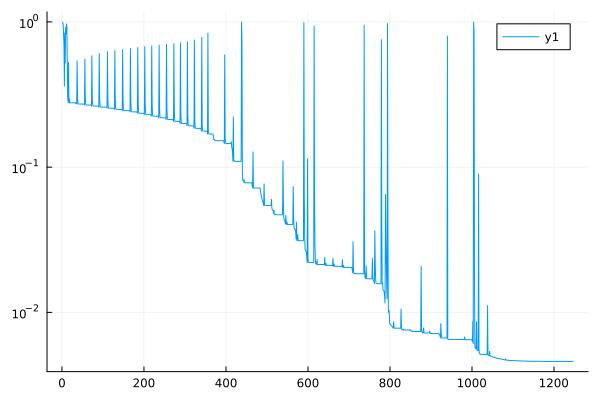

In [25]:
# plot([l1s,l2s])
plot(l1s + m*abs.(l2s),yaxis=:log)

In [15]:
p_new[8]/pi

7.912654680045747

In [26]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
  1.2699655691325273
  1.702864089928985
 10.0
 -3.714497693654256
 -0.027522874573253895
  4.402357268704159
  5.332964357850103
 37.69175811709104
  0.5723700663388693

In [27]:
p - p_new

9-element Vector{Float64}:
  -1.6754306772406917
  -1.0097169093690397
   0.0
  -0.1773226044563696
   0.027522874573253895
  -0.6785437149201607
  -0.2473736816650174
 -34.565873426769194
  -0.5723700663388693

In [50]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
 -0.405000584576826
  0.6772994582342963
 10.0
 -0.4229324447732595
  0.0017893241925168205
  2.468045373367846
  3.377881813015613
  2.843322066914799
 -0.003900006591459169

In [52]:
p - p_new

9-element Vector{Float64}:
 -0.0004645235313384122
  0.015847722325649016
  0.0
  0.017467336665094813
 -0.0017893241925168205
  0.014496995821486003
  0.012511971107777242
  0.2825626234070451
  0.003900006591459169

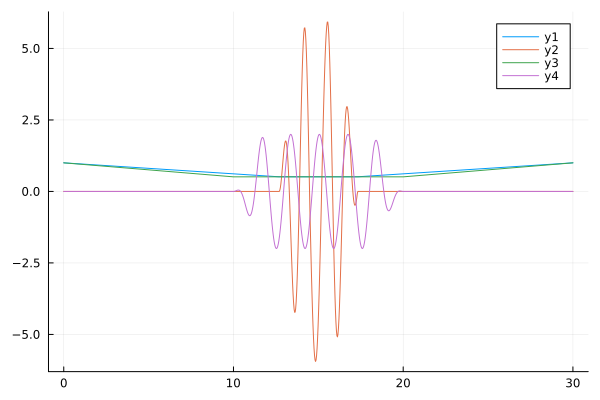

In [107]:
times = LinRange(0,30,1000)
plot(times, [[alpha(p_new,t) for t in times],
             [pulse(p_new,t) for t in times],
             [alpha(p,t) for t in times],
             [pulse(p,t) for t in times]])

In [53]:
# params[end] #[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
l1s[end], l2s[end]

(8.202861676565032e-5, 0.41431799613317744)

In [217]:
p_new = copy(Optim.minimizer(res))

9-element Vector{Float64}:
 -0.405465156302017
  0.6931464917118937
 10.0
 -0.4054741972084596
  0.5418000458087958
  2.4237014880564427
  3.443148196712285
  3.1258846891634198
  0.052889253496627646

In [101]:

forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-10)

retcode: Success
Interpolation: 1st order linear
t: 1000-element Vector{Float64}:
  0.0
  0.03003003003003003
  0.06006006006006006
  0.09009009009009009
  0.12012012012012012
  0.15015015015015015
  0.18018018018018017
  0.21021021021021022
  0.24024024024024024
  0.2702702702702703
  ⋮
 29.75975975975976
 29.78978978978979
 29.81981981981982
 29.84984984984985
 29.87987987987988
 29.90990990990991
 29.93993993993994
 29.96996996996997
 30.0
u: 1000-element Vector{Matrix{ComplexF64}}:
 [0.0 + 0.0im -12.694746782963147 - 24.455949616205622im … 0.13560581855983922 - 0.003927337058381834im 1.5689136759460285 - 0.0003555829988387263im; 1.5438914136931459 + 0.0im 0.23667702089969844 + 1.2094738031882772im … -1.5663165375257906 + 0.0001457230034430623im 0.15108147293050328 - 0.028458648593590374im; … ; 62.82746547287959 + 0.0im 0.8744911662307878 + 0.12239605119046967im … -0.00379360492421821 - 0.0001114663597984746im -0.006882839454721343 - 0.0004503534515507462im; 63.66542063788365 + 0.0i

In [105]:
occs = zeros(1000,2)

for (i,u) in enumerate(sol_f.u)
    occs[i,:] = abs2.(u[1:2,2*N+2])
end

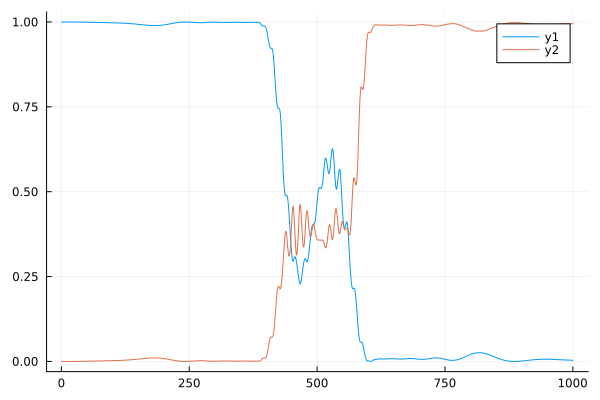

In [109]:
plot(occs)#,yaxis=:log,ylim=(1e-10,1))


In [216]:
abs.(p-p_new)

9-element Vector{Float64}:
 4.986051915789602e-8
 6.87848051961204e-7
 0.0
 9.105766960781914e-6
 4.58087958676856e-8
 4.626983101996274e-6
 1.1469206517844555e-7
 1.1584244674622823e-9
 7.465033723536019e-7

In [29]:
# writedlm("tmp_l1s6.txt",l1s)
# writedlm("tmp_l2s6.txt",l2s)
# writedlm("tmp_params6.txt",params)
# writedlm("tmp_calls6.txt",calls)

In [88]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [89]:
tmp_losses = []
for phi in phis
    push!(tmp_losses,fidel(phi*pi,p_new))
end

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203
┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :log10]
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1641


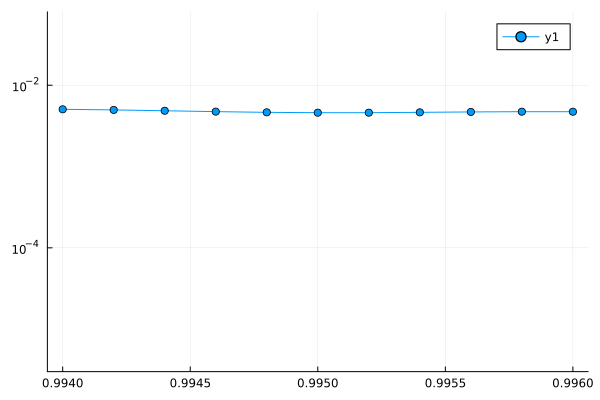

In [39]:
plot(LinRange(0.994,0.996,11),tmp_losses,yscale=:log,marker="o",ylim=(3e-6,8e-2))

In [80]:
using ProgressMeter

In [84]:
phis = cat([0.993,0.99325,0.9935,0.99375,0.994],LinRange(0.994,0.99475,7)[2:end-1],LinRange(0.99475,0.995,7),dims=1)
# phis = [0.993,
# 0.9935,
# 0.994,
# 0.99475,
# 0.9948,
# 0.99485,
# 0.9949,
# 0.99495,
# 0.995]
phis = cat(phis, reverse(0.995 .+ (0.995 .- phis))[2:end],dims=1)
;
# plot(phis,phis,marker="o")

In [85]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   6%|███                                      |  ETA: 0:07:14

Progress:   9%|████                                     |  ETA: 0:06:49

Progress:  12%|█████                                    |  ETA: 0:06:30

Progress:  15%|███████                                  |  ETA: 0:06:15

Progress:  18%|████████                                 |  ETA: 0:05:58

Progress:  21%|█████████                                |  ETA: 0:05:43

Progress:  24%|██████████                               |  ETA: 0:05:32

Progress:  27%|████████████                             |  ETA: 0:05:19

Progress:  30%|█████████████                            |  ETA: 0:05:06

Progress:  33%|██████████████                           |  ETA: 0:04:53

Progress:  36%|███████████████                          |  ETA: 0:04:39

Progress:  39%|█████████████████                        |  ETA: 0:04:27

Progress:  42%|██████████████████                       |  ETA: 0:04:10

Progress:  45%|███████████████████                      |  ETA: 0:03:53

Progress:  48%|████████████████████                     |  ETA: 0:03:38

Progress:  52%|██████████████████████                   |  ETA: 0:03:23

Progress:  55%|███████████████████████                  |  ETA: 0:03:09

Progress:  58%|████████████████████████                 |  ETA: 0:02:55

Progress:  61%|█████████████████████████                |  ETA: 0:02:41

Progress:  64%|███████████████████████████              |  ETA: 0:02:28

Progress:  67%|████████████████████████████             |  ETA: 0:02:15

Progress:  70%|█████████████████████████████            |  ETA: 0:02:03

Progress:  73%|██████████████████████████████           |  ETA: 0:01:50

Progress:  76%|████████████████████████████████         |  ETA: 0:01:38

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:13

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:01

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:49

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:36

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:24

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


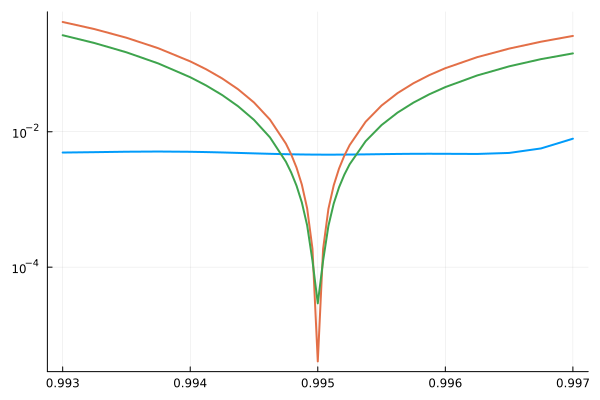

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


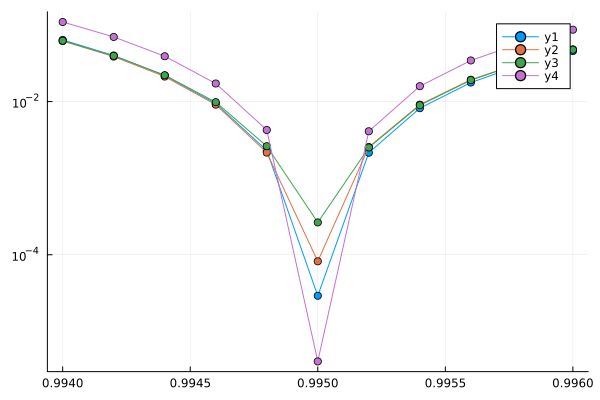

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


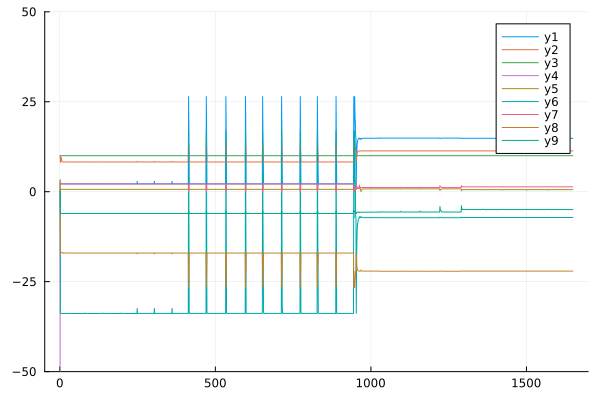

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009